In [58]:
#IMPORT SOME BASIC LIBRARIES 
import requests
import json
import torch
import os
from tqdm import tqdm


from pathlib import Path
from torch.utils.data import DataLoader
import time

In [61]:
#Data load 
with open(r"/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/random_testing/product/prod_full_3139.json", "r") as read_file:
    full = json.load(read_file)

In [62]:
print("length of data :", len(full))

length of data : 3139


In [10]:
#Split the data into three categories
from sklearn.model_selection import train_test_split

train, _ = train_test_split(full, test_size=0.30, random_state=42)
valid, test = train_test_split(_, test_size=0.50, random_state=42)

In [11]:
len(train), len(valid), len(test)

(107, 23, 23)

In [7]:
#Read the dataa and foramting the data 
def read_data(squad):
    
    contexts = []
    questions = []
    answers = []

    for group in squad:
    # for passage in group['paragraphs']:
        context = group['context']
        for qa in group['qas']:
            question = qa['question']
            for answer in qa['answers']:
                contexts.append(context)
                questions.append(question)
                answers.append(answer)

    return contexts, questions, answers

#Call the functions
train_contexts, train_questions, train_answers = read_data(train)
valid_contexts, valid_questions, valid_answers = read_data(valid)
test_contexts, test_questions, test_answers = read_data(test)

In [8]:
len(train_contexts), len(train_answers), len(train_questions)
print("shape of train:>>", len(train_contexts))
print("shape of valid:>>", len(valid_contexts))
print("shape of test:>>", len(test_contexts))

shape of train:>> 35207
shape of valid:>> 7393
shape of test:>> 7321


In [12]:
train_contexts[1], train_questions[1], train_answers[1]

('Because of the rapid succession of technological developments, the architecture and material composition of many products used in daily life have drastically changed over the last decades. As a result, well-adjusted recycling technologies need to be developed and installed to cope with these evolutions. This is essential to guarantee continued access to materials and to reduce the ecological impact of our material consumption. However, limited information is currently available on the material composition of arising waste streams and even less on how these waste streams will evolve. Therefore, this paper presents a methodology to forecast trends in the material composition of waste streams. To demonstrate the applicability and value of the proposed methodology, it is applied to forecast the evolution of plastic housing waste from flat panel display (FPD) TVs, FPD monitors, cathode ray tube (CRT) TVs and CRT monitors. The results of the presented forecasts indicate that a wide variety

In [13]:
def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        gold_text = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        # sometimes squad answers are off by a character or two so we fix this
        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1     # When the gold label is off by one character
        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 2
            answer['answer_end'] = end_idx - 2     # When the gold label is off by two characters
        else:
            answer['answer_end'] = end_idx

add_end_idx(train_answers, train_contexts)
add_end_idx(valid_answers, valid_contexts)
add_end_idx(test_answers, test_contexts)

In [14]:
# You can see that now we get the answer_end also
print(train_questions[-10])
print(train_answers[-10])
print(train_contexts[-10])

What are the products formed?
{'text': 'plastic production waste disposal', 'answer_start': 1639, 'answer_end': 1672}
Along with the increasing amount of plastic production and waste disposal, the presence of microplastics has been confirmed in all compartments of ecosystems. The microplastics in biota is of particular concern due to the potential eco-risks associated with long term exposure and the potential for transportation along food webs. Decapoda represents a diverse taxonomic group within the subphylum Crustacea, and some of which are highly valued in fishery and biological production. The interaction between microplastic pollution and wild populations of decapod crustaceans have been documented less than fish or bivalves but are critical to understand the fates of microplastics in marine eco-systems and enrich the baselines for consumption analyses. Our review systematically summarizes the occurrence, abundance and characteristics of microplastics detected in edible and non-ed

In [15]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
valid_encodings = tokenizer(valid_contexts, valid_questions, truncation=True, padding=True)
test_encodings = tokenizer(test_contexts, test_questions, truncation=True, padding=True)

In [16]:
train_encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [17]:
no_of_encodings = len(valid_encodings['input_ids'])
print(f'We have {no_of_encodings} context-question pairs')

We have 7393 context-question pairs


In [18]:
no_of_encodings = len(test_encodings['input_ids'])
print(f'We have {no_of_encodings} context-question pairs')

We have 7321 context-question pairs


In [19]:
no_of_encodings = len(train_encodings['input_ids'])
print(f'We have {no_of_encodings} context-question pairs')

We have 35207 context-question pairs


In [20]:
print(train_encodings['input_ids'][0])

[101, 2279, 1104, 1103, 6099, 8705, 1104, 12675, 9093, 117, 1103, 4220, 1105, 2578, 5239, 1104, 1242, 2982, 1215, 1107, 3828, 1297, 1138, 23173, 2014, 1166, 1103, 1314, 4397, 119, 1249, 170, 1871, 117, 1218, 118, 10491, 21804, 7951, 1444, 1106, 1129, 1872, 1105, 4631, 1106, 16743, 1114, 1292, 7243, 1116, 119, 1188, 1110, 6818, 1106, 11865, 1598, 2469, 1106, 3881, 1105, 1106, 4851, 1103, 14769, 3772, 1104, 1412, 2578, 8160, 119, 1438, 117, 2609, 1869, 1110, 1971, 1907, 1113, 1103, 2578, 5239, 1104, 19528, 5671, 9136, 1105, 1256, 1750, 1113, 1293, 1292, 5671, 9136, 1209, 23530, 119, 6589, 117, 1142, 2526, 8218, 170, 18576, 1106, 24647, 14652, 1107, 1103, 2578, 5239, 1104, 5671, 9136, 119, 1706, 10541, 1103, 12647, 9538, 5474, 1105, 2860, 1104, 1103, 3000, 18576, 117, 1122, 1110, 3666, 1106, 24647, 1103, 7243, 1104, 5828, 3328, 5671, 1121, 3596, 5962, 3934, 113, 143, 15481, 114, 1794, 1116, 117, 143, 15481, 16884, 117, 5855, 5114, 2007, 7586, 7159, 113, 15531, 1942, 114, 1794, 1116, 1105,

In [21]:
tokenizer.decode(train_encodings['input_ids'][0])

'[CLS] Because of the rapid succession of technological developments, the architecture and material composition of many products used in daily life have drastically changed over the last decades. As a result, well - adjusted recycling technologies need to be developed and installed to cope with these evolutions. This is essential to guarantee continued access to materials and to reduce the ecological impact of our material consumption. However, limited information is currently available on the material composition of arising waste streams and even less on how these waste streams will evolve. Therefore, this paper presents a methodology to forecast trends in the material composition of waste streams. To demonstrate the applicability and value of the proposed methodology, it is applied to forecast the evolution of plastic housing waste from flat panel display ( FPD ) TVs, FPD monitors, cathode ray tube ( CRT ) TVs and CRT monitors. The results of the presented forecasts indicate that a w

In [22]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        # print(i)
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))
        # print(i)

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

        encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

In [23]:
add_token_positions(train_encodings, train_answers)
add_token_positions(valid_encodings, valid_answers)
add_token_positions(test_encodings, test_answers)

In [24]:
train_encodings['start_positions'][:10]

[17, 205, 135, 214, 230, 40, 166, 164, 194, 211]

# Dataset definition 🗄️
We have to define our dataset using the PyTorch Dataset class from torch.utils in order create our dataloaders after that.

In [25]:
class SQuAD_Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

In [26]:
train_dataset = SQuAD_Dataset(train_encodings)
valid_dataset = SQuAD_Dataset(valid_encodings)
test_dataset  = SQuAD_Dataset(test_encodings)

**Dataloader**

In [28]:
from torch.utils.data import DataLoader

# Define the dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)
test_loader  = DataLoader(test_dataset, batch_size=16)

# Load pretrained bert
We are going to use the bert-case-uncased from the huggingface transformers.

In [29]:
from transformers import BertForQuestionAnswering

# model = BertForQuestionAnswering.from_pretrained("bert-base-uncased")

In [30]:
# Check on the available device - use GPU
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(f'Working on {device}')

Working on cuda:1


In [31]:
from transformers import AdamW
import torch.nn as nn

model = BertForQuestionAnswering.from_pretrained('bert-base-cased').to(device)

optim = AdamW(model.parameters(), lr=5e-5)
# optim = AdamW(model.parameters(), lr=3e-5)
# optim = AdamW(model.parameters(), lr=2e-5)

# epochs = 2
epochs = 10
# epochs = 4

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForQuestionAnswering: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and a

In [32]:
val_loader = valid_loader

In [33]:
whole_train_eval_time = time.time()

train_losses = []
val_losses = []

print_every = 100

for epoch in range(epochs):
    epoch_time = time.time()

    # Set model in train mode
    model.train()

    loss_of_epoch = 0

    print("############Train############")

    for batch_idx,batch in enumerate(train_loader): 

        optim.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs[0]
        # do a backwards pass 
        loss.backward()
        # update the weights
        optim.step()
        # Find the total loss
        loss_of_epoch += loss.item()

        if (batch_idx+1) % print_every == 0:
            print("Batch {:} / {:}".format(batch_idx+1,len(train_loader)),"\nLoss:", round(loss.item(),1),"\n")

    loss_of_epoch /= len(train_loader)
    train_losses.append(loss_of_epoch)

    ##########Evaluation##################

    # Set model in evaluation mode
    model.eval()

    print("############Evaluate############")

    loss_of_epoch = 0

    for batch_idx,batch in enumerate(val_loader):

        with torch.no_grad():

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
            loss = outputs[0]
            # Find the total loss
            loss_of_epoch += loss.item()

        if (batch_idx+1) % print_every == 0:
            print("Batch {:} / {:}".format(batch_idx+1,len(val_loader)),"\nLoss:", round(loss.item(),1),"\n")

    loss_of_epoch /= len(val_loader)
    val_losses.append(loss_of_epoch)

    # Print each epoch's time and train/val loss 
    print("\n-------Epoch ", epoch+1,
        "-------"
        "\nTraining Loss:", train_losses[-1],
        "\nValidation Loss:", val_losses[-1],
        "\nTime: ",(time.time() - epoch_time),
        "\n-----------------------",
        "\n\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))

############Train############
Batch 100 / 2201 
Loss: 2.5 

Batch 200 / 2201 
Loss: 1.8 

Batch 300 / 2201 
Loss: 1.6 

Batch 400 / 2201 
Loss: 1.4 

Batch 500 / 2201 
Loss: 1.8 

Batch 600 / 2201 
Loss: 1.7 

Batch 700 / 2201 
Loss: 2.1 

Batch 800 / 2201 
Loss: 1.9 

Batch 900 / 2201 
Loss: 1.9 

Batch 1000 / 2201 
Loss: 2.1 

Batch 1100 / 2201 
Loss: 1.6 

Batch 1200 / 2201 
Loss: 2.3 

Batch 1300 / 2201 
Loss: 1.9 

Batch 1400 / 2201 
Loss: 1.8 

Batch 1500 / 2201 
Loss: 2.0 

Batch 1600 / 2201 
Loss: 1.5 

Batch 1700 / 2201 
Loss: 1.6 

Batch 1800 / 2201 
Loss: 1.6 

Batch 1900 / 2201 
Loss: 1.9 

Batch 2000 / 2201 
Loss: 1.3 

Batch 2100 / 2201 
Loss: 1.9 

Batch 2200 / 2201 
Loss: 1.4 

############Evaluate############
Batch 100 / 463 
Loss: 1.5 

Batch 200 / 463 
Loss: 2.2 

Batch 300 / 463 
Loss: 2.0 

Batch 400 / 463 
Loss: 1.3 


-------Epoch  1 -------
Training Loss: 1.8822752428509766 
Validation Loss: 1.6337626944607844 
Time:  1766.0720829963684 
----------------------- 

Batch 600 / 2201 
Loss: 1.5 

Batch 700 / 2201 
Loss: 1.7 

Batch 800 / 2201 
Loss: 1.3 

Batch 900 / 2201 
Loss: 1.4 

Batch 1000 / 2201 
Loss: 1.3 

Batch 1100 / 2201 
Loss: 1.7 

Batch 1200 / 2201 
Loss: 1.5 

Batch 1300 / 2201 
Loss: 1.8 

Batch 1400 / 2201 
Loss: 1.7 

Batch 1500 / 2201 
Loss: 1.6 

Batch 1600 / 2201 
Loss: 1.6 

Batch 1700 / 2201 
Loss: 1.6 

Batch 1800 / 2201 
Loss: 1.2 

Batch 1900 / 2201 
Loss: 1.2 

Batch 2000 / 2201 
Loss: 1.7 

Batch 2100 / 2201 
Loss: 1.4 

Batch 2200 / 2201 
Loss: 1.6 

############Evaluate############
Batch 100 / 463 
Loss: 1.3 

Batch 200 / 463 
Loss: 2.3 

Batch 300 / 463 
Loss: 1.6 

Batch 400 / 463 
Loss: 1.5 


-------Epoch  9 -------
Training Loss: 1.449923169065854 
Validation Loss: 1.5133100348981359 
Time:  1770.258983373642 
----------------------- 


############Train############
Batch 100 / 2201 
Loss: 1.5 

Batch 200 / 2201 
Loss: 1.6 

Batch 300 / 2201 
Loss: 1.5 

Batch 400 / 2201 
Loss: 1.5 

Batch 500 / 2201 
Loss: 1.8 


**Save the model in my drive in order not to run it each time**

In [36]:
model_path = "/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/product/pretrain_model/product_only/"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/product/pretrain_model/product_only/tokenizer_config.json',
 '/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/product/pretrain_model/product_only/special_tokens_map.json',
 '/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/product/pretrain_model/product_only/vocab.txt',
 '/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/product/pretrain_model/product_only/added_tokens.json',
 '/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/product/pretrain_model/product_only/tokenizer.json')

# Step 12: Plot train and validation losses

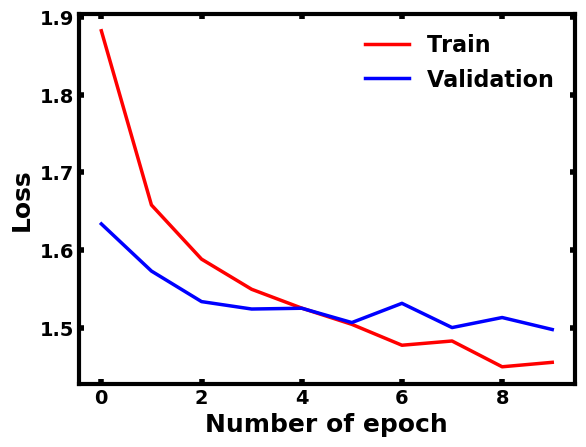

In [37]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_losses)), train_losses, color='red', label= 'Train', linewidth=2.5)
plt.plot(range(len(val_losses)), val_losses, color =  'Blue', label = 'Validation', linewidth=2.5)
#plt.title('Classification loss')
plt.legend(frameon=False,prop={'weight':'bold',"size":16})
plt.xlabel('Number of epoch',fontweight='bold', fontsize=18)
plt.ylabel('Loss',fontweight='bold', fontsize=18)
#plt.title('GP Regression',fontweight='bold')
#plt.axis('square')
from matplotlib import rc

plt.rcParams['axes.linewidth'] = 3

plt.tick_params(axis="x", direction="in",width=4)
plt.tick_params(axis="y", direction="in", width=4)

rc('font', weight='bold')

plt.tick_params(bottom=True, top=True, left=True, right=True)
plt.tick_params(labelbottom=True, labeltop=False, labelleft=True, labelright=False)
plt.xticks(rotation = '0', fontsize = 14)
plt.yticks(rotation = '0', fontsize = 14)
#plt.legend(handles=h, labels=np.arange(0.9,0.85), title="Quality")
#plt.rcParams.update({'legend.fontweight':'bold'}
#plt.savefig('line_plot.pdf')
plt.savefig(r'/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/product/curve_learnin/learning_react.pdf', dpi=5000)
plt.show()#

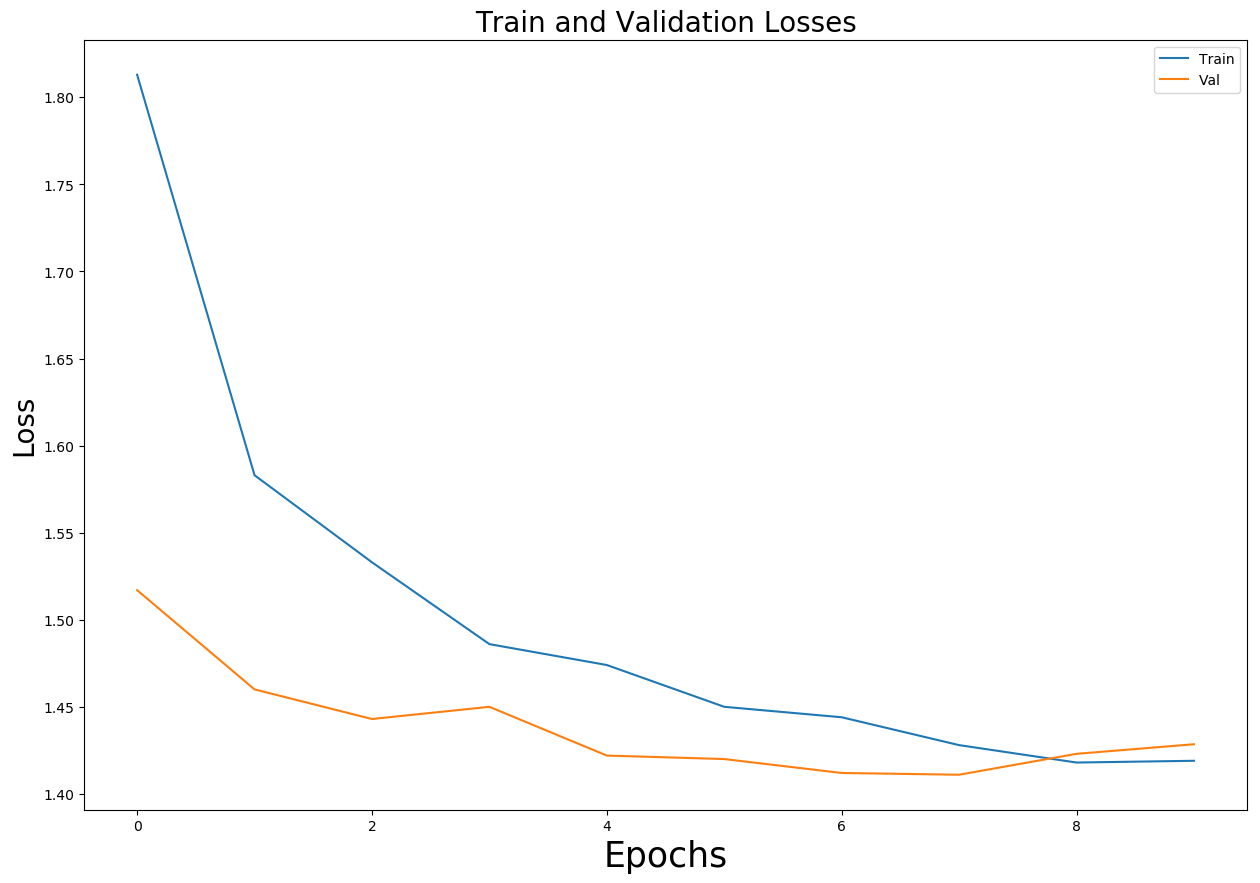

In [5]:
fig,ax = plt.subplots(1,1,figsize=(15,10))

ax.set_title("Train and Validation Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20) 
ax.set_xlabel('Epochs', fontsize = 25) 
_=ax.plot(train_losses)
_=ax.plot(val_losses)
_=ax.legend(('Train','Val'),loc='upper right')













# Test
We are evaluating the model on the validation set by checking the model's predictions for the answer's start and end indexes and comparing with the true ones.

In [29]:
model.eval()

acc = []

for batch in tqdm(valid_loader):
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_true = batch['start_positions'].to(device)
        end_true = batch['end_positions'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)

        start_pred = torch.argmax(outputs['start_logits'], dim=1)
        end_pred = torch.argmax(outputs['end_logits'], dim=1)

        acc.append(((start_pred == start_true).sum()/len(start_pred)).item())
        acc.append(((end_pred == end_true).sum()/len(end_pred)).item())

acc = sum(acc)/len(acc)

print("\n\nT/P\tanswer_start\tanswer_end\n")
for i in range(len(start_true)):
    print(f"true\t{start_true[i]}\t{end_true[i]}\n"
        f"pred\t{start_pred[i]}\t{end_pred[i]}\n")

100%|████████████████████████████████████████████████████████████████| 307/307 [01:18<00:00,  3.93it/s]



T/P	answer_start	answer_end

true	87	88
pred	43	43

true	166	166
pred	43	43

true	18	23
pred	18	23

true	64	66
pred	18	23

true	27	27
pred	27	27

true	30	36
pred	27	27



# Testing

In [6]:
# import json
# with open(r"/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/data/data qna/data_individual/with_dupli/bert/prod_test.json", "r") as read_file:
#     train_ca = json.load(read_file)



In [7]:
#IMPORT SOME BASIC LIBRARIES 
import requests
import json
import torch
import os
from tqdm import tqdm


from pathlib import Path
from torch.utils.data import DataLoader
import time

In [8]:
#Data load 
with open(r"/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/data/data qna/data_individual/with_dupli/prod_train_full_1.json", "r") as read_file:
    full = json.load(read_file)

In [9]:
len(full)

18916

In [10]:
from sklearn.model_selection import train_test_split

train, _ = train_test_split(full, test_size=0.30, random_state=42)
valid, test = train_test_split(_, test_size=0.50, random_state=42)

In [11]:
len(train), len(valid), len(test)

(13241, 2837, 2838)

# Ask question
We are going to use some functions from the official Evaluation Script v2.0 of SQuAD in order to test the fine-tuned model by asking some questions given a context. I have also looked at this notebook which evaluates BERT on SQuAD.

**Respectively, load the saved model**

In [63]:
from transformers import BertForQuestionAnswering, BertTokenizerFast

model_path = "/home/user3/Documents/avan_phd/Objective_3/Objective_3_QnA/result/product/pretrain_model/product_only/"
model = BertForQuestionAnswering.from_pretrained(model_path)
tokenizer = BertTokenizerFast.from_pretrained(model_path)

device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(f'Working on {device}')

model = model.to(device)

Working on cuda:1


In [64]:
##data list
context = []
answerss = []
question =[]

#loop data points
def extractquestions(test):
    for trai in test:
        context.append(trai['context'])
        question.append(trai['qas'][0]['question'])

    for sample in test:
        gold_answers = []
        for ans in sample['qas'][0]['answers']:
            gold_answers.append(ans['text'])
        answerss.append(gold_answers)
        
    return context, answerss, question

#Data for testing
context, answerss, question = extractquestions(full)

In [65]:
F1 = []
preci = []
recal = []

In [66]:
def get_prediction_f1_0(context, question,f):
    inputs = tokenizer.encode_plus(question, context, return_tensors='pt').to(device)
    try:
        outputs = model(**inputs)
        start_logits = outputs[0]
        end_logits = outputs[1]

        def to_list(tensor):
            return tensor.detach().cpu().tolist()

        # convert our start and end logit tensors to lists
        start_logits = to_list(start_logits)[0]
        end_logits = to_list(end_logits)[0]

        # sort our start and end logits from largest to smallest, keeping track of the index
        start_idx_and_logit = sorted(enumerate(start_logits), key=lambda x: x[1], reverse=True)
        end_idx_and_logit = sorted(enumerate(end_logits), key=lambda x: x[1], reverse=True)

        # select the top n (in this case, 5)
#         print(start_idx_and_logit[:5])
#         print(end_idx_and_logit[:5]) 

        start_indexes = [idx for idx, logit in start_idx_and_logit[:5]]
        end_indexes = [idx for idx, logit in end_idx_and_logit[:5]]

        # convert the token ids from a tensor to a list
        tokens = to_list(inputs['input_ids'])[0]

        # question tokens are defined as those between the CLS token (101, at position 0) and first SEP (102) token 
        question_indexes = [i+1 for i, token in enumerate(tokens[1:tokens.index(102)])]

        import collections

        # keep track of all preliminary predictions
        PrelimPrediction = collections.namedtuple( 
            "PrelimPrediction", ["start_index", "end_index", "start_logit", "end_logit"]
        )

        prelim_preds = []
        for start_index in start_indexes:
            for end_index in end_indexes:
                # throw out invalid predictions
                if start_index in question_indexes:
                    continue
                if end_index in question_indexes:
                    continue
                if end_index < start_index:
                    continue
                prelim_preds.append(
                    PrelimPrediction(
                        start_index = start_index,
                        end_index = end_index,
                        start_logit = start_logits[start_index],
                        end_logit = end_logits[end_index]
                    )
                )

        # sort preliminary predictions by their score
        prelim_preds = sorted(prelim_preds, key=lambda x: (x.start_logit + x.end_logit), reverse=True)

        # keep track of all best predictions
        BestPrediction = collections.namedtuple(  # pylint: disable=invalid-name
            "BestPrediction", ["text", "start_logit", "end_logit"]
        )

        nbest = []
        nbest_text =[]
        seen_predictions = []
        
        print("Number of best>>>>", f)
        for pred in prelim_preds:

            # for now we only care about the top 5 best predictions
            if len(nbest) >= f: 
                break

            # loop through predictions according to their start index
            if pred.start_index > 0: # non-null answers have start_index > 0

                text = tokenizer.convert_tokens_to_string(
                    tokenizer.convert_ids_to_tokens(
                        tokens[pred.start_index:pred.end_index+1]
                    )
                )
                # clean whitespace
                text = text.strip()
                text = " ".join(text.split())

                if text in seen_predictions:
                    continue

                # flag this text as being seen -- if we see it again, don't add it to the nbest list
                seen_predictions.append(text) 

                # add this text prediction to a pruned list of the top 5 best predictions
                nbest.append(BestPrediction(text=text, start_logit=pred.start_logit, end_logit=pred.end_logit))

        # and don't forget -- include the null answer!
        nbest.append(BestPrediction(text="", start_logit=start_logits[0], end_logit=end_logits[0]))

    except:
        print('no available')
        
        seen_predictions = ["nothings"]


    return seen_predictions

In [67]:
def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)
    def white_space_fix(text):
        return " ".join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

In [68]:
def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()
    
    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)
    
    common_tokens = set(pred_tokens) & set(truth_tokens)
    
    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0
    
    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)
    
    return 2 * (prec * rec) / (prec + rec)

In [69]:
def exact_match(prediction, truth):
    return bool(normalize_text(prediction) == normalize_text(truth))

In [70]:
def question_answer(context, question,answerss,f):
    prediction = get_prediction_f1_0(context,question,f)
    #em_score = exact_match(prediction, answer)
    #f1_score = compute_f1(prediction, answer)
    temp_f1 = []
    for pre in prediction:
        
        print(answerss, pre)

        if len(answerss) != 0:
            em_score = max((exact_match(pre.replace(" ", ""), answer.replace(" ", ""))) for answer in answerss)
    #         for answer in answerss:
    #             presion, recall = comput_prec_recall(prediction, answer.replace(" ", ""))
    # #         presion, recall = max((comput_prec_recall(prediction, answer)) for answer in answerss)
    #         print(presion, recall)

            f1_score = max((compute_f1(pre.replace(" ", ""), answer.replace(" ", ""))) for answer in answerss)
        
            print(f1_score)
    #         if f1_score == 1.0:
            temp_f1.append(f1_score)
    

    #         elif f1_score == 0:
    #             prediction_0 = get_prediction_f1_0(context,question)
    #             print(prediction_0)

    #             f1_score_0 = max((compute_f1(prediction_0, answer)) for answer in answerss)
    #             print(f1_score_0)
    #             F1.append(f1_score_0)

    #         preci.append(presion)
    #         recal.append(recall)
        else:
            em_score = 0
            f1_score = 0
            temp_f1 = [0]
            
    #if max(temp_f1) <=1.0:
        
    if max(temp_f1) ==1.0:
        F1.append(max(temp_f1))
        
    else:
        temp_f1 = []
        for pre in prediction:

            print(answerss, pre)

            if len(answerss) != 0:
                em_score = max((exact_match(pre, answer)) for answer in answerss)
        #         for answer in answerss:
        #             presion, recall = comput_prec_recall(prediction, answer.replace(" ", ""))
        # #         presion, recall = max((comput_prec_recall(prediction, answer)) for answer in answerss)
        #         print(presion, recall)

                f1_score = max((compute_f1(pre, answer)) for answer in answerss)
                print(f1_score)
        #         if f1_score == 1.0:
                temp_f1.append(f1_score)


        #         elif f1_score == 0:
        #             prediction_0 = get_prediction_f1_0(context,question)
        #             print(prediction_0)

        #             f1_score_0 = max((compute_f1(prediction_0, answer)) for answer in answerss)
        #             print(f1_score_0)
        #             F1.append(f1_score_0)

        #         preci.append(presion)
        #         recal.append(recall)
            else:
                em_score = 0
                f1_score = 0
                temp_f1 = [0]
                
        F1.append(max(temp_f1))

    
    
    
    print(f'Question: {question}')
    print(f'Prediction: {prediction}')
    print(f'True Answer: {answerss}')
    print(f'Exact match: {em_score}')
    print(f'F1 score: {max(temp_f1)}\n')

In [71]:
for i in range(len(full)):
    print(i)
    question_answer(context[i], question[0],answerss[i], len(answerss[i]))

0
Number of best>>>> 3
['renewable energy resource', 'polystyrene', 'pyrolysis oil'] renewable energy resource
1.0
['renewable energy resource', 'polystyrene', 'pyrolysis oil'] renewable energy resource with maximizing economic feasibility and mitigating environmental pollution. To derive the optimal sorting and recycling strategies of plastic waste, a novel optimization model is developed ; it calculates the overall profit by subtracting the profit of recycling plastic from the total annualized cost. Then the model is used to identify the optimal strategy to sort and recycle plastic waste as a renewable energy resource in mixed - integer nonlinear programming that maximizes the overall profit. In the derived optimal sorting and recycling strategy, high - density polyethylene is recycled to produce downgrade plastic ; low - density polyethylene, polypropylene, and polystyrene are recycled as pyrolysis oil
0
['renewable energy resource', 'polystyrene', 'pyrolysis oil'] pyrolysis oil
1.0

Number of best>>>> 5
['sustainable cement mortar', 'cement mortar', 'cement mortars', 'developed thermoset cement mortars', 'eco-friendly cement mortar formulations'] sustainable cement mortar
1.0
['sustainable cement mortar', 'cement mortar', 'cement mortars', 'developed thermoset cement mortars', 'eco-friendly cement mortar formulations'] cement mortar
1.0
['sustainable cement mortar', 'cement mortar', 'cement mortars', 'developed thermoset cement mortars', 'eco-friendly cement mortar formulations'] sustainable cement mortar with the help of a green surface adhesion promoter – a silane coupling agent. The feasibility of the proposed approach was experimentally validated in terms of workability performance and compressive strength in order to meet requirements in practice. The results show that thermoset waste can substitute for at least 15 % of sand in cement mortar, following workability requirements. In addition, the optimal replacement level of thermoset waste for sand in cement m

Number of best>>>> 12
['concrete', 'Their production', 'production', "concrete's durability", 'plastic fibres', 'plastic concrete', 'concrete production', 'elastic concrete materials', 'conventional concrete', 'production', 'sustainable novel green concrete', 'Plastic concrete'] production
1.0
['concrete', 'Their production', 'production', "concrete's durability", 'plastic fibres', 'plastic concrete', 'concrete production', 'elastic concrete materials', 'conventional concrete', 'production', 'sustainable novel green concrete', 'Plastic concrete'] concrete and plastic. Their production
0
['concrete', 'Their production', 'production', "concrete's durability", 'plastic fibres', 'plastic concrete', 'concrete production', 'elastic concrete materials', 'conventional concrete', 'production', 'sustainable novel green concrete', 'Plastic concrete'] Their production
1.0
['concrete', 'Their production', 'production', "concrete's durability", 'plastic fibres', 'plastic concrete', 'concrete product

Number of best>>>> 7
['product price', 'product yield', 'steadily rising oil prices', 'plastic product prices', 'oil prices', 'recycled products', 'low oil prices'] product price and product yield. At current price levels, the most profitable plastic fraction to be recycled is PS rigids, with an internal rate of return of 14 %, whereas the least profitable feed is a mixed polyolefin fraction with a negative internal rate of return in a scenario with steadily rising oil prices
0
['product price', 'product yield', 'steadily rising oil prices', 'plastic product prices', 'oil prices', 'recycled products', 'low oil prices'] oil prices
1.0
['product price', 'product yield', 'steadily rising oil prices', 'plastic product prices', 'oil prices', 'recycled products', 'low oil prices'] steadily rising oil prices
1.0
['product price', 'product yield', 'steadily rising oil prices', 'plastic product prices', 'oil prices', 'recycled products', 'low oil prices'] product price and product yield. At cur

Number of best>>>> 6
['fiber reinforced concrete', 'engineered fibers', 'medium-strength concrete', 'concrete mixes', 'plain concrete', 'concrete'] fiber reinforced concrete
1.0
['fiber reinforced concrete', 'engineered fibers', 'medium-strength concrete', 'concrete mixes', 'plain concrete', 'concrete'] concrete
1.0
['fiber reinforced concrete', 'engineered fibers', 'medium-strength concrete', 'concrete mixes', 'plain concrete', 'concrete'] engineered fibers
1.0
['fiber reinforced concrete', 'engineered fibers', 'medium-strength concrete', 'concrete mixes', 'plain concrete', 'concrete'] fiber reinforced concrete ( FRC ) is a major challenge in the construction industry considering the high cost of engineered fibers
0
['fiber reinforced concrete', 'engineered fibers', 'medium-strength concrete', 'concrete mixes', 'plain concrete', 'concrete'] engineered fibers. Thus, owing to high tensile strength, recycled nylon fiber ( RNF ) derived from nylon waste can be used in FRC as an eco - frie

Number of best>>>> 9
['concrete mixture', 'reinforced concrete beams', 'normal concrete mixtures', 'Three concrete mixtures', 'concrete mixture', 'The concrete mixture', 'concrete properties', 'The reinforced concrete mixture', 'concrete beam test'] concrete mixture if plastic box particles ( PBPs ) are used as a partial substitute for sand in the mixture. Another purpose was to verify the effect of the waste on the flexural behavior of reinforced concrete beams
0
['concrete mixture', 'reinforced concrete beams', 'normal concrete mixtures', 'Three concrete mixtures', 'concrete mixture', 'The concrete mixture', 'concrete properties', 'The reinforced concrete mixture', 'concrete beam test'] reinforced concrete beams
1.0
['concrete mixture', 'reinforced concrete beams', 'normal concrete mixtures', 'Three concrete mixtures', 'concrete mixture', 'The concrete mixture', 'concrete properties', 'The reinforced concrete mixture', 'concrete beam test'] concrete mixture if plastic box particles (

Number of best>>>> 2
['products', 'plastic products'] products
1.0
['products', 'plastic products'] products manufactured by the same technology was performed in order to compare the qualities of products made from original PET, non - weathered PET waste, which was the example of classical recycling, and weathered PET. In the case of products made from weathered PET, certain mechanical and optical properties ( e. g. impact strength and transparency ) were significantly impaired compared to the original PET and the recycled, non - weathered PET. Certain other properties ( e. g. strength and rigidity ) did not change significantly. It was proved that the samples from weathered plastic material can be successfully recycled mechanically and used to manufacture plastic products
0
Question: What are the products formed?
Prediction: ['products', 'products manufactured by the same technology was performed in order to compare the qualities of products made from original PET, non - weathered PET

0
['concrete', 'PP concrete', 'concrete density', 'concrete', 'PP concrete', 'The 10% PP concrete', 'PP concrete cylinders', 'reference concrete', 'efficient eco-friendly concrete', 'structural concrete'] PP concrete. It focuses mainly on workability, hardened density, compressive strength, modulus of elasticity ( MoE ), splitting tensile strength ( STS ), flexural strength, bond strength, temperature effect on compressive strength, shrinkage properties, and chloride ion penetration. The experimental work includes a varying percentage of PP aggregate as 10 % and 20 % of the volume of coarse aggregate and the water - cement ratios as 0. 35, 0. 40, 0. 45, and 0. 50. The experimental results revealed that the workability of concrete increased with the addition of PP aggregate into the mixture. Almost 5 % and 10 % reduction in concrete density can be possible while using 10 % and 20 % PP content, respectively. In terms of compressive strength, MoE, STS, and flexural strength, all the prope

Token indices sequence length is longer than the specified maximum sequence length for this model (601 > 512). Running this sequence through the model will result in indexing errors


Number of best>>>> 1
['phenolic resin enhanced wood products'] phenolic resin enhanced wood products
1.0
Question: What are the products formed?
Prediction: ['phenolic resin enhanced wood products']
True Answer: ['phenolic resin enhanced wood products']
Exact match: True
F1 score: 1.0

104
Number of best>>>> 1
['oil market'] oil market
1.0
Question: What are the products formed?
Prediction: ['oil market']
True Answer: ['oil market']
Exact match: True
F1 score: 1.0

105
Number of best>>>> 1
['production'] production
1.0
Question: What are the products formed?
Prediction: ['production']
True Answer: ['production']
Exact match: True
F1 score: 1.0

106
Number of best>>>> 2
['energy-dispersive', 'acrylonitrile butadiene styrene'] acrylonitrile butadiene styrene
1.0
['energy-dispersive', 'acrylonitrile butadiene styrene'] energy - dispersive X - ray spectroscopy ( EDS ) at an elemental level. The results showed that among various other polymers, acrylonitrile butadiene styrene
0
Question: Wh

Number of best>>>> 1
['monomer recovery'] monomer recovery
1.0
Question: What are the products formed?
Prediction: ['monomer recovery']
True Answer: ['monomer recovery']
Exact match: True
F1 score: 1.0

120
Number of best>>>> 2
['increased production', 'valuable products'] valuable products
1.0
['increased production', 'valuable products'] increased production and consumption of electronic equipment as well as plastic commodities. This results in a large generation of electronic waste ( e - waste ) and plastic waste. The most severe problem associated with these wastes is their informal recycling and improper disposal, threatening the environment and human health. On the other hand, these wastes also provide an opportunity for the recovery of metals and the generation of valuable products
0
Question: What are the products formed?
Prediction: ['valuable products', 'increased production and consumption of electronic equipment as well as plastic commodities. This results in a large genera

Number of best>>>> 1
['energy recovery'] energy recovery
1.0
Question: What are the products formed?
Prediction: ['energy recovery']
True Answer: ['energy recovery']
Exact match: True
F1 score: 1.0

135
Number of best>>>> 2
['crushing product characteristics', 'crushed products'] crushed products
1.0
['crushing product characteristics', 'crushed products'] crushing product characteristics and crushing efficiency of the single tear crushing method, single hammer crushing method, and two - step crushing method were investigated. The study shows that the two - step crushing method could achieve 100 % dissociation of all battery components, and the crushed products
0
Question: What are the products formed?
Prediction: ['crushed products', 'crushing product characteristics and crushing efficiency of the single tear crushing method, single hammer crushing method, and two - step crushing method were investigated. The study shows that the two - step crushing method could achieve 100 % dissocia

Number of best>>>> 3
['plastic products', 'mechanically-recycled convention polypropylene (PP) products', 'high-performance fused PP sample'] plastic products
1.0
['plastic products', 'mechanically-recycled convention polypropylene (PP) products', 'high-performance fused PP sample'] plastic products is very important to solve global plastic pollution in the era of green development and low - carbon economy. Giving that the mainstream of processing plastic waste is still direct mechanical recycling, the unexpected degradation on mechanical properties betrays the intention to recycle plastic waste. Here, based on the temperature sensitivity of interfacial diffusion and orientation retention, we proposed an innovative protocol of recycling biaxially oriented polypropylene ( BOPP ) film waste in high value and efficient manner. Specially, a lamellar assembly of the biaxially - oriented film wastes was constructed layer by layer and then compressed into a sheet near the melting temperature.

Number of best>>>> 8
['affordable clean energy', 'value-added products', 'products', 'oil', 'production', 'beneficial products', 'sustainable production', 'quality products'] products
1.0
['affordable clean energy', 'value-added products', 'products', 'oil', 'production', 'beneficial products', 'sustainable production', 'quality products'] value - added products
1.0
['affordable clean energy', 'value-added products', 'products', 'oil', 'production', 'beneficial products', 'sustainable production', 'quality products'] production
1.0
['affordable clean energy', 'value-added products', 'products', 'oil', 'production', 'beneficial products', 'sustainable production', 'quality products'] oil, biohydrogen, and other renewable fuels are examined. The application of waste plastic in the building and construction industries, production
0
['affordable clean energy', 'value-added products', 'products', 'oil', 'production', 'beneficial products', 'sustainable production', 'quality products'] oil
1

Number of best>>>> 2
['production', 'Polystyrene'] production
1.0
['production', 'Polystyrene'] production of plastic are on the rising trend, leading to the increase in waste generation and consumption of raw materials, making it one of the most significant issues facing densely populated cities. As a result, plastic waste management is becoming one of society's primary concerns, as it has direct effects on the environment and sustainability of urban areas. However, the identification and classification of the different types of plastic remains a challenge, as current techniques still face limitations. Unfortunately, identification technologies cannot classify many types of plastic, and often a particular technology is used to classify certain types of plastic. In this study, we propose a classification methodology that analyses the use of different machine learning algorithms based on the infrared spectrum of polymers. This proposed classification methodology will be able to identify

Number of best>>>> 5
['energy', 'carbon fibers', 'glass fibers', 'energy', 'low energy'] energy
1.0
['energy', 'carbon fibers', 'glass fibers', 'energy', 'low energy'] energy required in the recycling of plastic composite materials is quite low, compared to conventional manufacturing techniques. In this review, we highlight some recent recycling and reusing techniques adopted for plastics and their composite materials. Among all the reported recycling techniques for polymer composites, thermal recycling is best suited for the recycling of carbon fibers ( CFs ) and glass fibers ( GFs ). Through thermal recycling, the properties of recycled materials can meet the properties of virgin materials and energy is significantly lower than chemical recycling. However, mechanical recycling requires very low energy
0
['energy', 'carbon fibers', 'glass fibers', 'energy', 'low energy'] energy required in the recycling of plastic composite materials is quite low, compared to conventional manufacturin

Number of best>>>> 3
['production', 'plastics polystyrene products', 'notably Expanded Polystyrene'] production
1.0
['production', 'plastics polystyrene products', 'notably Expanded Polystyrene'] production and consumption of plastics and polystyrene products ( notably Expanded Polystyrene
0
['production', 'plastics polystyrene products', 'notably Expanded Polystyrene'] production and consumption of plastics and polystyrene products
0
Question: What are the products formed?
Prediction: ['production', 'production and consumption of plastics and polystyrene products ( notably Expanded Polystyrene', 'production and consumption of plastics and polystyrene products']
True Answer: ['production', 'plastics polystyrene products', 'notably Expanded Polystyrene']
Exact match: False
F1 score: 1.0

208
Number of best>>>> 1
['pyrolysis oil products'] pyrolysis oil products
1.0
Question: What are the products formed?
Prediction: ['pyrolysis oil products']
True Answer: ['pyrolysis oil products']
Exac

Number of best>>>> 2
['electric electronic products', 'electric electronic products'] electronic products
0
['electric electronic products', 'electric electronic products'] products
0
['electric electronic products', 'electric electronic products'] electronic products
0.8
['electric electronic products', 'electric electronic products'] products
0.5
Question: What are the products formed?
Prediction: ['electronic products', 'products']
True Answer: ['electric electronic products', 'electric electronic products']
Exact match: False
F1 score: 0.8

222
Number of best>>>> 1
['hydroxyapatite'] hydroxyapatite
1.0
Question: What are the products formed?
Prediction: ['hydroxyapatite']
True Answer: ['hydroxyapatite']
Exact match: True
F1 score: 1.0

223
Number of best>>>> 4
['concrete', 'recycled plastic fibers', 'fiber reinforced concrete', 'fiber reinforced concrete'] concrete
1.0
['concrete', 'recycled plastic fibers', 'fiber reinforced concrete', 'fiber reinforced concrete'] concrete, but it

Number of best>>>> 4
['recycled concrete aggregate', 'adhered mortar', 'asphalt concrete', 'boiling water test'] asphalt concrete containing RCA ( RCA - AC ), due to the high absorption of RCA and the weakness of the adhered mortar
0
['recycled concrete aggregate', 'adhered mortar', 'asphalt concrete', 'boiling water test'] adhered mortar
1.0
['recycled concrete aggregate', 'adhered mortar', 'asphalt concrete', 'boiling water test'] asphalt concrete
1.0
['recycled concrete aggregate', 'adhered mortar', 'asphalt concrete', 'boiling water test'] recycled concrete aggregate ( RCA ) can be successfully adopted to replace natural aggregate ( NA ) for asphalt pavement construction. However, the moisture - induced damage, as one of the pavement engineering performances, is very prominent for asphalt concrete containing RCA ( RCA - AC ), due to the high absorption of RCA and the weakness of the adhered mortar
0
Question: What are the products formed?
Prediction: ['asphalt concrete containing R

Number of best>>>> 5
['high value-added chemicals', 'oil', 'oil', 'production', 'target products'] production
1.0
['high value-added chemicals', 'oil', 'oil', 'production', 'target products'] production of long - chain alkenes. The plasticizers in WPEPBs including bisphenol A ( BPA ) and phthalate ester ( DEHP ) could be efficiently converted into aniline ( ≈15 % ) and 2 - ethylhexanol ( ≈4 % ) due to the high reactivity of NH3 in the SWA process. Compared with the degradation of WPEPBs in supercritical water, the SWA process could reduce side effects and improve the purity of target products
0
['high value-added chemicals', 'oil', 'oil', 'production', 'target products'] high value - added chemicals from WPEPBs by supercritical water ammonia ( SWA ) process without any catalyst. WPEPBs could be converted into two parts by the SWA process : oil and solid residue. More than 80 % of the oil was identified as long - chain alkanes and alkenes due to the decomposition of polyethylene ( PE ) 

Number of best>>>> 2
['soil', 'soils'] soils
1.0
['soil', 'soils'] soil and aquatic environments by e - waste recycling activities in the Lian River Basin, China. The study area included a designated industrial park in the traditional e - waste recycling area ( Guiyu, known as the world's largest e - waste center ), several emerging informal recycling zones, and their surrounding areas and coastal area. A total of 27 PCBs were analyzed, and the highest concentration was found in an emerging site for soil ( 354 ng g−1 ) and in a traditional site for sediment ( 1350 ng g ‐ −1 ) respectively. The pollution levels were significantly higher in both the traditional and emerging recycling areas than in their respective upstream countryside areas ( p = 0. 0356 and 0. 0179, respectively ). Source analysis revealed that the traditional and emerging areas had similar PCB sources mainly associated with three PCB technical mixtures manufactured in Japan ( KC600 ) and the USA ( Aroclor 1260 and Aroc

Number of best>>>> 1
['cumulative energy demand'] cumulative energy demand
1.0
Question: What are the products formed?
Prediction: ['cumulative energy demand']
True Answer: ['cumulative energy demand']
Exact match: True
F1 score: 1.0

281
Number of best>>>> 1
['crude pyrolytic oil'] crude pyrolytic oil
1.0
Question: What are the products formed?
Prediction: ['crude pyrolytic oil']
True Answer: ['crude pyrolytic oil']
Exact match: True
F1 score: 1.0

282
Number of best>>>> 2
['natural soil', 'effective energy dissipation'] natural soil
1.0
['natural soil', 'effective energy dissipation'] natural soil. The film was prepared by introducing covalent bonds and metal – ligand bonds to the gelatin matrix. These covalent bonds, metal – ligand bonds, and inherent hydrogen bonds in the gelatin matrix serve as multiple sacrificial bonds for effective energy dissipation
0
Question: What are the products formed?
Prediction: ['natural soil', 'natural soil. The film was prepared by introducing covale

Number of best>>>> 5
['concrete materials', 'concrete', 'recycled plastic concrete', 'RPC)andnormalconcrete (NC', 'normal concrete'] concrete materials
1.0
['concrete materials', 'concrete', 'recycled plastic concrete', 'RPC)andnormalconcrete (NC', 'normal concrete'] concrete materials can effectively recover waste plastics, but it will also have an impact on the sodium sulfate resistanceperformance of concrete. In this work, at the macro level, the three concentrations ( 3 %, 5 %, and 7 % ) sodium sulfate resistance of recycled plastic concrete ( RPC ) andnormalconcrete ( NC ) were analyzed and evaluated from its appearance, relative mass, compressive strength, andultrasonic wave velocity. From the microscopic aspect, the microstructure and phase composition at 5 % erosion concentration were tested and analyzed by SEM, XRD, and FT - IR. The deterioration mechanism of RPC eroded by sodium sulfate solution was analyzed. Results showed thatthe effect of sodium sulfate solution on RPC is 

1.0
['Liquid packaging board', 'energy recovery', 'fibre', '(2) composite pallet production', '(4) plastic pallet production', 'plastic pallet production', 'consumed energy', 'composite pallet production', 'average production mix', 'energy'] ( 2 ) composite pallet production
1.0
['Liquid packaging board', 'energy recovery', 'fibre', '(2) composite pallet production', '(4) plastic pallet production', 'plastic pallet production', 'consumed energy', 'composite pallet production', 'average production mix', 'energy'] Liquid packaging board is one of the highly demanded packaging mediums for liquid food and beverages, generating substantial waste each year. Even though the fibre part of the liquid packaging board is recycled through a repulping process, the plastic and aluminium are usually used for energy recovery and as alternative raw materials in cement factories. This practice reduces the life span and economic value of plastic and aluminium, which does not fit within a circular economy

Number of best>>>> 2
['value-added products', 'epoxidized styrene-acrylic copolymer'] value - added products
1.0
['value-added products', 'epoxidized styrene-acrylic copolymer'] value - added products. Here, we demonstrate a strategy to reprocess post - consumer recycled carpet waste ( PCRC ) ( containing polyamide, polypropylene and other additives and reinforcing agents ) with polyamide 6 ( PA 6 ) at different weight ratios through reactive extrusion. The phase adhesion of the PCRC and PA 6 was improved significantly with the aid of poly ( ethylene - octene ) - grafted - maleic anhydride copolymer ( POE - g - MA ) and epoxidized styrene - acrylic copolymer
0
Question: What are the products formed?
Prediction: ['value - added products', 'value - added products. Here, we demonstrate a strategy to reprocess post - consumer recycled carpet waste ( PCRC ) ( containing polyamide, polypropylene and other additives and reinforcing agents ) with polyamide 6 ( PA 6 ) at different weight ratios

no available
['oils', 'pyrolysis oils', 'pyrolysis oils'] nothings
0
['oils', 'pyrolysis oils', 'pyrolysis oils'] nothings
0
Question: What are the products formed?
Prediction: ['nothings']
True Answer: ['oils', 'pyrolysis oils', 'pyrolysis oils']
Exact match: False
F1 score: 0

340
Number of best>>>> 2
['products', 'product'] redesigning products
0
['products', 'product'] products
1.0
Question: What are the products formed?
Prediction: ['redesigning products', 'products']
True Answer: ['products', 'product']
Exact match: True
F1 score: 1.0

341
Number of best>>>> 4
['valuable liquid products', 'liquid pyrolysis oil', 'product yields', 'product evolution data'] valuable liquid products
1.0
['valuable liquid products', 'liquid pyrolysis oil', 'product yields', 'product evolution data'] product yields
1.0
['valuable liquid products', 'liquid pyrolysis oil', 'product yields', 'product evolution data'] valuable liquid products that can be used as fuels, chemicals and platform molecules. An

Number of best>>>> 1
['productivity'] productivity
1.0
Question: What are the products formed?
Prediction: ['productivity']
True Answer: ['productivity']
Exact match: True
F1 score: 1.0

355
Number of best>>>> 6
['concrete', 'concrete structures', 'concrete structure', 'conventional concrete', 'concrete steel quantities', 'concrete plastic industries'] concrete
1.0
['concrete', 'concrete structures', 'concrete structure', 'conventional concrete', 'concrete steel quantities', 'concrete plastic industries'] concrete structures
1.0
['concrete', 'concrete structures', 'concrete structure', 'conventional concrete', 'concrete steel quantities', 'concrete plastic industries'] concrete. This not only reduces the amount of unprocessed plastic waste, but also minimizes the need for natural aggregates ; thus, which in turn reduces the environmental impacts of overexploiting aggregate quarries. The goal of this research is to assess the life cycle cost implications of utilizing green recycled plas

Number of best>>>> 3
['production cycle', 'low-emission energy systems', 'recycling products'] production cycle as a chemical feedstock instead of being incinerated or landfilled. However, the predominant focus on technological aspects of chemical recycling for plastic waste narrows evaluations of its potential in contributing to such a transition. Moreover, it leads to significant controversy about its role in the waste hierarchy as a possible competitor to mechanical recycling. To address these gaps in the literature, this study assesses ecological and economic impacts associated with chemical recycling of residual municipal solid waste in Germany. Combining approaches of life cycle assessment and techno - economic analysis, chemical recycling and conventional incineration - based treatment pathways are comparatively evaluated in terms of global warming potential and economic performance ( i. e. fixed capital investment, net present value, dynamic payback period, and levelized cost o

Number of best>>>> 4
['ground motion energy', 'rubber-sand-concrete', 'energy dissipation ability', 'energy dissipation performance'] ground motion energy
1.0
['ground motion energy', 'rubber-sand-concrete', 'energy dissipation ability', 'energy dissipation performance'] ground motion energy. Therefore, a new type of rubber - sand - concrete
0
['ground motion energy', 'rubber-sand-concrete', 'energy dissipation ability', 'energy dissipation performance'] ground motion energy. Therefore, a new type of rubber - sand - concrete ( RSC ), which is composed of a specific formula of rubber particles, sand, and cement, is proposed. The ingredients proportions in the RSC formula were investigated considering the seismic design demand for underground tunnels. The effects of rubber content ( RM ), cement content ( CM ), and rubber particle size ( RPS ) on the mechanical and damping properties such as density, Poisson's ratio, elastic modulus, compressive and tensile strengths, energy dissipation 

Number of best>>>> 4
['concrete', 'recycled GFRP powder (rGP) filled mortar', 'rGP filled mortar', 'concretes'] concrete
1.0
['concrete', 'recycled GFRP powder (rGP) filled mortar', 'rGP filled mortar', 'concretes'] concrete provides a viable approach for waste GFRP recycle. However, expansion induced performance deterioration of concrete is a concern. The expansion mechanism and the effectiveness of five types of modification treatments were comprehensively investigated by testing the physical and mechanical properties, microstructure and hydration kinetics of recycled GFRP powder ( rGP ) filled mortar. The gas of H2, NH3 and CH4 produced by the reaction between rGP and alkaline pore solution was the main cause for the expansion. This expansion can be significantly reduced by adding silica fume and fully eliminated by presoaking rGP in NaOH solution. After modification, the compressive and flexural strength of rGP filled mortar were increased by 67 % [UNK] 100 % and 25 % [UNK] 60 %, r

Number of best>>>> 1
['production'] production
1.0
Question: What are the products formed?
Prediction: ['production']
True Answer: ['production']
Exact match: True
F1 score: 1.0

406
Number of best>>>> 4
['CRA concrete', 'ordinary concrete', 'different fibers', 'high-performance concrete'] CRA concrete
1.0
['CRA concrete', 'ordinary concrete', 'different fibers', 'high-performance concrete'] CRA concrete are generally inferior compared to ordinary concrete
0
['CRA concrete', 'ordinary concrete', 'different fibers', 'high-performance concrete'] CRA concrete are generally inferior compared to ordinary concrete. The performance of CRA concrete can be supplemented using different fibers
0
['CRA concrete', 'ordinary concrete', 'different fibers', 'high-performance concrete'] CRA concrete are generally inferior compared to ordinary concrete. The performance of CRA concrete can be supplemented using different fibers and secondary binder materials. This study encourages the idea of using recyc

Number of best>>>> 4
['high-value products', 'fine recycled concrete waste', 'carbonation products', 'dominant reaction product-aragonite'] carbonation products
1.0
['high-value products', 'fine recycled concrete waste', 'carbonation products', 'dominant reaction product-aragonite'] high - value products
1.0
['high-value products', 'fine recycled concrete waste', 'carbonation products', 'dominant reaction product-aragonite'] fine recycled concrete waste ( FRCW ), aiming to effectively capture CO2 and convert FRCW into high - value products
0
['high-value products', 'fine recycled concrete waste', 'carbonation products', 'dominant reaction product-aragonite'] fine recycled concrete waste
1.0
Question: What are the products formed?
Prediction: ['carbonation products', 'high - value products', 'fine recycled concrete waste ( FRCW ), aiming to effectively capture CO2 and convert FRCW into high - value products', 'fine recycled concrete waste']
True Answer: ['high-value products', 'fine rec

Number of best>>>> 4
['waste plastic products', 'secondary products', 'processed products', 'secondary products use'] secondary products
1.0
['waste plastic products', 'secondary products', 'processed products', 'secondary products use'] waste plastic products. The effect of multistage recycling processes on heavy metal migration and the environmental risk posed by heavy metals during recycling processes were investigated by : ( 1 ) Recycling waste plastics and determining the heavy metal contents in secondary products
0
['waste plastic products', 'secondary products', 'processed products', 'secondary products use'] secondary products ; ( 2 ) Using toxic leaching experiments to assess environmental risks of heavy metal migration in secondary products ; and ( 3 ) Evaluating the effect of recycling processes on the mechanical properties and microstructure of plastics. Results showed that the contents of some harmful heavy metals in processed products
0
['waste plastic products', 'seconda

Number of best>>>> 3
['sustainable products', 'product', 'product'] products
0
['sustainable products', 'product', 'product'] sustainable products
1.0
['sustainable products', 'product', 'product'] products. This study proposes to re - design recycled paper - based containers so that consumers easily recognize visually large contaminants in the paper influencing the consumer to refer to this product
0
Question: What are the products formed?
Prediction: ['products', 'sustainable products', 'products. This study proposes to re - design recycled paper - based containers so that consumers easily recognize visually large contaminants in the paper influencing the consumer to refer to this product']
True Answer: ['sustainable products', 'product', 'product']
Exact match: False
F1 score: 1.0

450
Number of best>>>> 9
['typical regional soils', 'soil contamination', '39 topsoil samples', 'Soil profiles', 'soil samples', 'REE-polluted soil', 'surrounding soil', 'soil', 'soil properties'] soils
0

Number of best>>>> 2
['compost product', 'safe compost product'] compost product
1.0
['compost product', 'safe compost product'] compost product to be used for crop cultivation. Moreover, shifts of microbial community in phylum and genus levels were observed. Microbial agent augmentation led to high quality and safe compost product
0
Question: What are the products formed?
Prediction: ['compost product', 'compost product to be used for crop cultivation. Moreover, shifts of microbial community in phylum and genus levels were observed. Microbial agent augmentation led to high quality and safe compost product']
True Answer: ['compost product', 'safe compost product']
Exact match: False
F1 score: 1.0

464
Number of best>>>> 6
['polystyrene polymers', 'Expanded polystyrene', 'waste expanded polystyrene', 'essential oils', 'polystyrene', 'flower-based essential oils'] essential oils
1.0
['polystyrene polymers', 'Expanded polystyrene', 'waste expanded polystyrene', 'essential oils', 'polystyr

Number of best>>>> 3
['energy recovery', 'fibres', '-processing film production'] fibres
1.0
['energy recovery', 'fibres', '-processing film production'] fibres, is incinerated for energy recovery
0
['energy recovery', 'fibres', '-processing film production'] energy recovery
1.0
Question: What are the products formed?
Prediction: ['fibres', 'fibres, is incinerated for energy recovery', 'energy recovery']
True Answer: ['energy recovery', 'fibres', '-processing film production']
Exact match: True
F1 score: 1.0

478
Number of best>>>> 5
['products', 'replaced products', 'energy matrix', 'energy matrix', 'solar energy'] products
1.0
['products', 'replaced products', 'energy matrix', 'energy matrix', 'solar energy'] replaced products
1.0
['products', 'replaced products', 'energy matrix', 'energy matrix', 'solar energy'] energy matrix. Thus, we assessed the energy matrix
0
['products', 'replaced products', 'energy matrix', 'energy matrix', 'solar energy'] energy matrix
1.0
['products', 'repl

Number of best>>>> 1
['valuable waste product'] valuable waste product
1.0
Question: What are the products formed?
Prediction: ['valuable waste product']
True Answer: ['valuable waste product']
Exact match: True
F1 score: 1.0

493
Number of best>>>> 5
['40 individual product categories', 'Packaging products', 'products', 'new products', 'cap production'] products
1.0
['40 individual product categories', 'Packaging products', 'products', 'new products', 'cap production'] Packaging products
1.0
['40 individual product categories', 'Packaging products', 'products', 'new products', 'cap production'] 40 individual product categories aggregated into nine industrial sectors were examined. An estimated 620 ± 23 kt or 114 kg / capita of these seven plastic polymers was put on the Norwegian market in 2020. Packaging products
0
['40 individual product categories', 'Packaging products', 'products', 'new products', 'cap production'] 40 individual product categories
1.0
['40 individual product categ

Number of best>>>> 1
['factory standardized single-use plastic products'] factory standardized single - use plastic products
1.0
Question: What are the products formed?
Prediction: ['factory standardized single - use plastic products']
True Answer: ['factory standardized single-use plastic products']
Exact match: True
F1 score: 1.0

508
Number of best>>>> 8
['mortar', 'concrete', 'self-compacting concrete', 'plastic fibers', 'self-compacting mortar', ', self-compacting high strength concrete', 'self-compacting light weight concrete', 'environmentally friendly sustainable product'] concrete
1.0
['mortar', 'concrete', 'self-compacting concrete', 'plastic fibers', 'self-compacting mortar', ', self-compacting high strength concrete', 'self-compacting light weight concrete', 'environmentally friendly sustainable product'] mortar or concrete
0
['mortar', 'concrete', 'self-compacting concrete', 'plastic fibers', 'self-compacting mortar', ', self-compacting high strength concrete', 'self-compa

Number of best>>>> 1
['electronic products'] electronic products
1.0
Question: What are the products formed?
Prediction: ['electronic products']
True Answer: ['electronic products']
Exact match: True
F1 score: 1.0

523
no available
['monomer', 'screening extracellular production'] nothings
0
['monomer', 'screening extracellular production'] nothings
0
Question: What are the products formed?
Prediction: ['nothings']
True Answer: ['monomer', 'screening extracellular production']
Exact match: False
F1 score: 0

524
Number of best>>>> 6
['polystyrene, polyethylene terephthalate, clogged materials', 'pyrolysis product yields', 'desired oil/wax', 'boiling point range', 'oil/wax', 'production'] production
1.0
['polystyrene, polyethylene terephthalate, clogged materials', 'pyrolysis product yields', 'desired oil/wax', 'boiling point range', 'oil/wax', 'production'] oil / wax
1.0
['polystyrene, polyethylene terephthalate, clogged materials', 'pyrolysis product yields', 'desired oil/wax', 'boili

Number of best>>>> 6
['huge production', 'products', 'The maximum pyrolytic oil', 'pyrolytic oil', 'pyrolytic oil', 'pyroltic oil'] products of the pyrolysis process are pyrolytic liquid, gas and residue. The maximum pyrolytic oil
0
['huge production', 'products', 'The maximum pyrolytic oil', 'pyrolytic oil', 'pyrolytic oil', 'pyroltic oil'] The maximum pyrolytic oil
1.0
['huge production', 'products', 'The maximum pyrolytic oil', 'pyrolytic oil', 'pyrolytic oil', 'pyroltic oil'] pyrolytic oil
1.0
['huge production', 'products', 'The maximum pyrolytic oil', 'pyrolytic oil', 'pyrolytic oil', 'pyroltic oil'] huge production of face waste masks, PPE kit and gloves pose environmental risks, since existing disposal methods such as incineration and reclamation which are emitting hazardous substances. In the present study covid - 19 medical waste material like waste face waste masks ; gloves and PPE kit ( personal protective equipment ) are considered as the feedstock for the thermal degradat

Number of best>>>> 2
['edible soybean oil', 'monomer feed ratio'] edible soybean oil
1.0
['edible soybean oil', 'monomer feed ratio'] monomer feed ratio
1.0
Question: What are the products formed?
Prediction: ['edible soybean oil', 'monomer feed ratio']
True Answer: ['edible soybean oil', 'monomer feed ratio']
Exact match: True
F1 score: 1.0

554
Number of best>>>> 1
['Polystyrene trays'] Polystyrene trays
1.0
Question: What are the products formed?
Prediction: ['Polystyrene trays']
True Answer: ['Polystyrene trays']
Exact match: True
F1 score: 1.0

555
Number of best>>>> 3
['energy recovery', 'concrete', 'The product design options'] concrete
1.0
['energy recovery', 'concrete', 'The product design options'] energy recovery to volume reduction, generation of pulp, hydrogel, cellulose, and polymer as well as to increase yield stress and viscosity of concrete
0
['energy recovery', 'concrete', 'The product design options'] energy recovery
1.0
Question: What are the products formed?
Predic

Number of best>>>> 1
['fibers'] fibers
1.0
Question: What are the products formed?
Prediction: ['fibers']
True Answer: ['fibers']
Exact match: True
F1 score: 1.0

568
Number of best>>>> 4
['production', 'Prefabricated mortar blocks', 'conventional lightweight mortars', 'mortars'] production
1.0
['production', 'Prefabricated mortar blocks', 'conventional lightweight mortars', 'mortars'] production of new construction materials due to their physical and chemical behaviour. Prefabricated mortar blocks
0
['production', 'Prefabricated mortar blocks', 'conventional lightweight mortars', 'mortars'] production of new construction materials due to their physical and chemical behaviour. Prefabricated mortar blocks have made with Portland cement, sand, water and grinded roof polyurethane based wastes from the automobile industry that replace in different amounts part or all of the aggregates. To try to avoid the mechanical resistance limitation due to the use of roof wastes, the chemical properti

Number of best>>>> 1
['energy generation'] energy generation
1.0
Question: What are the products formed?
Prediction: ['energy generation']
True Answer: ['energy generation']
Exact match: True
F1 score: 1.0

584
Number of best>>>> 2
['edible soybean oil', 'monomer feed ratio'] edible soybean oil
1.0
['edible soybean oil', 'monomer feed ratio'] monomer feed ratio
1.0
Question: What are the products formed?
Prediction: ['edible soybean oil', 'monomer feed ratio']
True Answer: ['edible soybean oil', 'monomer feed ratio']
Exact match: True
F1 score: 1.0

585
Number of best>>>> 1
['Polystyrene trays'] Polystyrene trays
1.0
Question: What are the products formed?
Prediction: ['Polystyrene trays']
True Answer: ['Polystyrene trays']
Exact match: True
F1 score: 1.0

586
Number of best>>>> 3
['energy recovery', 'concrete', 'The product design options'] concrete
1.0
['energy recovery', 'concrete', 'The product design options'] energy recovery to volume reduction, generation of pulp, hydrogel, cell

Number of best>>>> 2
['waste polystyrene', 'pure polystyrene'] pure polystyrene
1.0
['waste polystyrene', 'pure polystyrene'] waste polystyrene and polypropylene on the mechanical properties of pure polystyrene
0
Question: What are the products formed?
Prediction: ['pure polystyrene', 'waste polystyrene and polypropylene on the mechanical properties of pure polystyrene']
True Answer: ['waste polystyrene', 'pure polystyrene']
Exact match: False
F1 score: 1.0

598
Number of best>>>> 1
['fibers'] fibers
1.0
Question: What are the products formed?
Prediction: ['fibers']
True Answer: ['fibers']
Exact match: True
F1 score: 1.0

599
Number of best>>>> 4
['production', 'Prefabricated mortar blocks', 'conventional lightweight mortars', 'mortars'] production
1.0
['production', 'Prefabricated mortar blocks', 'conventional lightweight mortars', 'mortars'] production of new construction materials due to their physical and chemical behaviour. Prefabricated mortar blocks
0
['production', 'Prefabricat

Number of best>>>> 6
['traditional concrete', 'fiberglass waste products', 'wood products', 'concrete mix', 'concrete', 'recycled aggregate concrete'] concrete
1.0
['traditional concrete', 'fiberglass waste products', 'wood products', 'concrete mix', 'concrete', 'recycled aggregate concrete'] fiberglass waste products
1.0
['traditional concrete', 'fiberglass waste products', 'wood products', 'concrete mix', 'concrete', 'recycled aggregate concrete'] concrete. Alternative aggregate elements, primarily as a potential application for recycled resources, are gaining in popularity. Although many new types of aggregate substitutes are being studied, along with granulated slag, rice husk ash, or multiple industrial wastes like fiberglass waste products
0
['traditional concrete', 'fiberglass waste products', 'wood products', 'concrete mix', 'concrete', 'recycled aggregate concrete'] fiberglass waste products, finely ground plastics, paper, and wood products or wastes, sintered sludge granules,

Number of best>>>> 1
['energy consumption'] energy consumption
1.0
Question: What are the products formed?
Prediction: ['energy consumption']
True Answer: ['energy consumption']
Exact match: True
F1 score: 1.0

628
Number of best>>>> 1
['new products'] new products
1.0
Question: What are the products formed?
Prediction: ['new products']
True Answer: ['new products']
Exact match: True
F1 score: 1.0

629
Number of best>>>> 5
['renewable energy based multigenerational waste', 'energy', 'Both energy exergy analyses', 'hydrogen production unit', 'The overall energy exergy efficiencies'] energy
1.0
['renewable energy based multigenerational waste', 'energy', 'Both energy exergy analyses', 'hydrogen production unit', 'The overall energy exergy efficiencies'] energy based multigenerational waste to energy system based on the pyrolysis of polyethylene plastic wastes. The developed system is assessed and simulated using the Aspen Plus and Engineering Equation Solver software packages. The propos

Number of best>>>> 2
['hazardous, high production volume chemicals', 'new products'] new products
1.0
['hazardous, high production volume chemicals', 'new products'] high production volume chemicals. There is concern that these contaminants could leach into the environment or be recycled into new products
0
Question: What are the products formed?
Prediction: ['new products', 'high production volume chemicals. There is concern that these contaminants could leach into the environment or be recycled into new products']
True Answer: ['hazardous, high production volume chemicals', 'new products']
Exact match: False
F1 score: 1.0

643
Number of best>>>> 1
['useful products'] useful products
1.0
Question: What are the products formed?
Prediction: ['useful products']
True Answer: ['useful products']
Exact match: True
F1 score: 1.0

644
Number of best>>>> 1
['high-performance engineering parts'] high - performance engineering parts
1.0
Question: What are the products formed?
Prediction: ['high 

Number of best>>>> 4
['production', 'final product', 'pyrolysis oil', 'pyrolysis product'] production
1.0
['production', 'final product', 'pyrolysis oil', 'pyrolysis product'] production of the final product
0
['production', 'final product', 'pyrolysis oil', 'pyrolysis product'] production of the final product, the distribution of pyrolysis gas, pyrolysis oil
0
['production', 'final product', 'pyrolysis oil', 'pyrolysis product'] pyrolysis oil
1.0
Question: What are the products formed?
Prediction: ['production', 'production of the final product', 'production of the final product, the distribution of pyrolysis gas, pyrolysis oil', 'pyrolysis oil']
True Answer: ['production', 'final product', 'pyrolysis oil', 'pyrolysis product']
Exact match: True
F1 score: 1.0

658
Number of best>>>> 1
['products'] products
1.0
Question: What are the products formed?
Prediction: ['products']
True Answer: ['products']
Exact match: True
F1 score: 1.0

659
Number of best>>>> 1
['petroleum product combusti

Number of best>>>> 5
['added liquid fuels', 'oil', 'product yield', 'liquid fuel production', 'energy requirement'] oil
1.0
['added liquid fuels', 'oil', 'product yield', 'liquid fuel production', 'energy requirement'] oil, hydrocarbons, syngas and deterioration of undesired substances. Generally, advance development of enthusiastic catalysts for the synthesis of bio - oil would be vital for scaling up the pyrolysis process to succeed in commercial manufacture of biofuels from waste plastics. Overall rate treatment depends on operating parameter which determines the process efficiency and product yield. Hence, critical assessment of various parameter that has remarkable effect in the thermo - chemical treatment process was documented in detail. Moreover, endorsements of liquid fuel production
0
['added liquid fuels', 'oil', 'product yield', 'liquid fuel production', 'energy requirement'] oil, hydrocarbons, syngas and deterioration of undesired substances. Generally, advance development

Number of best>>>> 2
['Most food residue products', 'byproduct'] Most food residue products
1.0
['Most food residue products', 'byproduct'] Most food residue products come from fruit, which has a high potential to be used effectively in several biodegradable polymer matrices for a wide range of applications. Fruit waste can be used to help growers earn money and through the composite, the producers save money by repurposing the byproduct
0
Question: What are the products formed?
Prediction: ['Most food residue products', 'Most food residue products come from fruit, which has a high potential to be used effectively in several biodegradable polymer matrices for a wide range of applications. Fruit waste can be used to help growers earn money and through the composite, the producers save money by repurposing the byproduct']
True Answer: ['Most food residue products', 'byproduct']
Exact match: False
F1 score: 1.0

687
Number of best>>>> 4
['concrete waste', 'concrete needs', 'mortar specime

Number of best>>>> 3
['ethylene glycol', '(BHET', 'BHET'] ethylene glycol
1.0
['ethylene glycol', '(BHET', 'BHET'] ethylene glycol ( EG ). Because of this, PET degradation takes a long time and PET accumulates in the environment. Many studies have been conducted to improve PET degrading enzyme to increase the efficiency of PET depolymerization. However, enzymatic PET decomposition is still restricted, making upcycling and recycling difficult. Here, we report a novel PET degrading complex composed of Ideonella sakaiensis PETase and Candida antarctica lipase B ( CALB ) that improves degradability, binding ability and enzyme stability. The reaction mechanism of chimeric PETase ( cPETase ) and chimeric CALB ( cCALB ) was confirmed by PET and bis ( 2 - hydroxyethyl terephthalate ) ( BHET ). cPETase generated BHET
0
['ethylene glycol', '(BHET', 'BHET'] BHET
1.0
Question: What are the products formed?
Prediction: ['ethylene glycol', 'ethylene glycol ( EG ). Because of this, PET degradation ta

Number of best>>>> 3
['electronic products', 'common electronic products', 'products'] electronic products
1.0
['electronic products', 'common electronic products', 'products'] electronic products nearing the end of their useful life. Computers, televisions, VCRs, stereos, copiers, printers, cell phones and fax machines are common electronic products
0
['electronic products', 'common electronic products', 'products'] common electronic products
1.0
Question: What are the products formed?
Prediction: ['electronic products', 'electronic products nearing the end of their useful life. Computers, televisions, VCRs, stereos, copiers, printers, cell phones and fax machines are common electronic products', 'common electronic products']
True Answer: ['electronic products', 'common electronic products', 'products']
Exact match: True
F1 score: 1.0

715
Number of best>>>> 4
['valuable products', 'wax, liquid oil', 'liquid oil', 'produced liquid oil'] valuable products
1.0
['valuable products', 'wax

Number of best>>>> 3
['new value-added products', 'geopolymer production', 'waste concrete'] geopolymer production
1.0
['new value-added products', 'geopolymer production', 'waste concrete'] new value - added products. However, most research efforts have been devoted to the geopolymer derived from the individual fraction separated from CDW. Given the technological complexity presented in separating CDW fractions on a commercial scale, using unseparated CDW ( UCDW ) in geopolymer application can achieve higher environmental and economic benefits. This paper investigated the feasibility of using UCDW consisting of various constituents, i. e., unbound aggregates ( UA ), red clay bricks ( RCB ), waste concrete ( WC ), waste glass ( WG ), and waste tiles ( WT ), in geopolymer production
0
['new value-added products', 'geopolymer production', 'waste concrete'] waste concrete ( WC ), waste glass ( WG ), and waste tiles ( WT ), in geopolymer production
0
Question: What are the products formed?

Number of best>>>> 7
['sustainable recycled products', 'recycled concrete aggregates', 'new products', 'recycled products', 'energy absorption characteristics', 'alternative recycled railway capping layer product', 'energy-absorbing capacity'] recycled products
1.0
['sustainable recycled products', 'recycled concrete aggregates', 'new products', 'recycled products', 'energy absorption characteristics', 'alternative recycled railway capping layer product', 'energy-absorbing capacity'] sustainable recycled products
1.0
['sustainable recycled products', 'recycled concrete aggregates', 'new products', 'recycled products', 'energy absorption characteristics', 'alternative recycled railway capping layer product', 'energy-absorbing capacity'] recycled products in the civil construction industry will reduce the demand for quarry materials, costs associated with landfilling as well as reducing the carbon footprint of future infrastructure projects. This study is focused on the usage of recovere

Number of best>>>> 1
['recycled concrete aggregate'] recycled concrete aggregate
1.0
Question: What are the products formed?
Prediction: ['recycled concrete aggregate']
True Answer: ['recycled concrete aggregate']
Exact match: True
F1 score: 1.0

758
Number of best>>>> 2
['terephthalic acid recovery', 'conversion products'] conversion products
1.0
['terephthalic acid recovery', 'conversion products'] terephthalic acid recovery from the alkaline solutions of the conversion products
0
Question: What are the products formed?
Prediction: ['conversion products', 'terephthalic acid recovery from the alkaline solutions of the conversion products']
True Answer: ['terephthalic acid recovery', 'conversion products']
Exact match: False
F1 score: 1.0

759
Number of best>>>> 1
['liquid gas products'] gas products
0
['liquid gas products'] gas products
0.8
Question: What are the products formed?
Prediction: ['gas products']
True Answer: ['liquid gas products']
Exact match: False
F1 score: 0.8

760
N

Number of best>>>> 3
['Numerous plastic products', 'mass production', 'products'] products
1.0
['Numerous plastic products', 'mass production', 'products'] Numerous plastic products
1.0
['Numerous plastic products', 'mass production', 'products'] products such as water bottle, plastic bags, food container and many more items have mass production
0
Question: What are the products formed?
Prediction: ['products', 'Numerous plastic products', 'products such as water bottle, plastic bags, food container and many more items have mass production']
True Answer: ['Numerous plastic products', 'mass production', 'products']
Exact match: False
F1 score: 1.0

775
Number of best>>>> 2
['promising high-value product', 'large-scale production'] promising high - value product from thermal chemical conversion of waste plastics and securing new applications is an important prerequisite for large - scale production
0
['promising high-value product', 'large-scale production'] promising high - value produc

Number of best>>>> 4
['Gibbs free energy minimization', 'Hydrogen production', 'highest hydrogen production', 'nitrogen production'] Hydrogen production was linearly reduced in the case of conventional biomass with an in increase in the equivalence ratio ; however, there was an optimum equivalence ratio to achieve the highest hydrogen production
0
['Gibbs free energy minimization', 'Hydrogen production', 'highest hydrogen production', 'nitrogen production'] Hydrogen production
1.0
['Gibbs free energy minimization', 'Hydrogen production', 'highest hydrogen production', 'nitrogen production'] Gibbs free energy minimization coupled with Lagrange multiplier approach. The comparison between the performances of biomass and plastic waste gasification is the main issue of this study. Another important novelty and contribution of this study is analytical hierarchy process / technique for order performance by similarity to the ideal solution coupled method that is employed in gasification of con

Number of best>>>> 2
['energy recovery', 'high-value polymeric products'] high - value polymeric products
1.0
['energy recovery', 'high-value polymeric products'] energy recovery ). This article reviews the recycling strategies which allow producing new polymeric materials from waste and the current research trends that could enable new opportunities for creating high - value polymeric products
0
Question: What are the products formed?
Prediction: ['high - value polymeric products', 'energy recovery ). This article reviews the recycling strategies which allow producing new polymeric materials from waste and the current research trends that could enable new opportunities for creating high - value polymeric products']
True Answer: ['energy recovery', 'high-value polymeric products']
Exact match: False
F1 score: 1.0

806
Number of best>>>> 2
['value added products', 'production'] production
1.0
['value added products', 'production'] value added products. Liquefaction of waste plastics via

Number of best>>>> 3
['significant carbon dioxide production', 'high energy demand', 'energy-related challenge'] significant carbon dioxide production
1.0
['significant carbon dioxide production', 'high energy demand', 'energy-related challenge'] high energy demand associated with pyrolysis can lead to significant carbon dioxide production
0
['significant carbon dioxide production', 'high energy demand', 'energy-related challenge'] high energy demand
1.0
Question: What are the products formed?
Prediction: ['significant carbon dioxide production', 'high energy demand associated with pyrolysis can lead to significant carbon dioxide production', 'high energy demand']
True Answer: ['significant carbon dioxide production', 'high energy demand', 'energy-related challenge']
Exact match: True
F1 score: 1.0

820
Number of best>>>> 4
['useful energy-yielding products', 'syngas hydrogen fuel production', 'These energy-yielding products', 'high efficient energy products'] useful energy - yielding 

Number of best>>>> 5
['concrete debris', 'mortars', 'fine recycled concrete aggregates', 'mortar mixtures', 'concrete aggregate waste'] concrete debris like disused tires is highly concerning, not only due to the magnitude of the existing volumes, which are increasing exponentially, but also to the environmental problems that their elimination causes. In the search for new, more ecological construction materials that can reduce the environmental impact produced by industry and the management of its waste, several studies are being conducted that incorporate and replace two or more wastes to prepare cement - based material so as to maximize the environmental benefits. Thus, alternatives are being sought that can reduce the extraction of natural resources, such as river sand. This study analyzed the use of two wastes as a replacement for natural sand in mortars, separately and in combination : fine recycled concrete aggregates
0
['concrete debris', 'mortars', 'fine recycled concrete aggr

Number of best>>>> 2
['agricultural production', 'sustainable agricultural production practices'] agricultural production
1.0
['agricultural production', 'sustainable agricultural production practices'] agricultural production in China. Given the knowledge of plastic mulch film is information - intensive, the lack of information might be the primary constraint for farmers to adopt recycling practices. Additionally, the potential self - selection bias in the information acquisition process raises an empirical challenge in accurately estimating the impact of information acquisition and information intensity on farmers ’ adoption behaviors. To this end, this study first creates a propensity - weighted sample and subsequently employs the multi - valued treatment effects model to analyze how information acquisition influences farmers ’ recycling choices, using the sample data from Yunnan province China. The results indicate that information acquisition exerts a positive and significant impa

Number of best>>>> 5
['produced pyrolysis oil', 'P-oil', '15-year low P-oil revenue price', 'P-oil price', 'P-oil'] produced pyrolysis oil
1.0
['produced pyrolysis oil', 'P-oil', '15-year low P-oil revenue price', 'P-oil price', 'P-oil'] pyrolysis oil
0
['produced pyrolysis oil', 'P-oil', '15-year low P-oil revenue price', 'P-oil price', 'P-oil'] 15 - year low P - oil revenue price
1.0
['produced pyrolysis oil', 'P-oil', '15-year low P-oil revenue price', 'P-oil price', 'P-oil'] produced pyrolysis oil ( P - oil ), ( 5 ) the tipping fees and ( 6 ) the potential to co - locate a PlastPyro plant with a waste plastic sorting facility. For example, the 15 - year low P - oil revenue price
0
['produced pyrolysis oil', 'P-oil', '15-year low P-oil revenue price', 'P-oil price', 'P-oil'] pyrolysis oil ( P - oil ), ( 5 ) the tipping fees and ( 6 ) the potential to co - locate a PlastPyro plant with a waste plastic sorting facility. For example, the 15 - year low P - oil revenue price
0
Question: 

Number of best>>>> 3
['sustainable construction material products', 'energy- resource-intensive construction building sector', 'geopolymer composite products'] geopolymer composite products
1.0
['sustainable construction material products', 'energy- resource-intensive construction building sector', 'geopolymer composite products'] sustainable construction material products. This paper reviews the existing studies on recycling municipal and construction solid waste for the manufacture of geopolymer composites. Special attention is paid to the predominate performance of these geopolymer composite products
0
['sustainable construction material products', 'energy- resource-intensive construction building sector', 'geopolymer composite products'] sustainable construction material products
1.0
Question: What are the products formed?
Prediction: ['geopolymer composite products', 'sustainable construction material products. This paper reviews the existing studies on recycling municipal and con

Number of best>>>> 2
['renewable energy sector', 'solar energy resources'] solar energy resources
1.0
['renewable energy sector', 'solar energy resources'] renewable energy sector with solar energy resources
0
Question: What are the products formed?
Prediction: ['solar energy resources', 'renewable energy sector with solar energy resources']
True Answer: ['renewable energy sector', 'solar energy resources']
Exact match: False
F1 score: 1.0

894
Number of best>>>> 8
['product fractions', 'oil products', 'oil products', 'energy recovery rate', 'oil yield', 'oil samples', 'lower boiling range molecular distribution', 'enhanced mass thermal energy transfer'] oil products, solid residue, and gas ) and the properties of the oil products were examined. At 350 °C and 90 min reaction duration, the conversion ( % ) of 75. 43 %, the oil yield of 39. 33 %, the energy recovery rate of 39. 7 %, the higher heating values ( HHV ) of 43. 83 MJ / kg for the oil samples
0
['product fractions', 'oil produ

Number of best>>>> 1
['production date'] production date
1.0
Question: What are the products formed?
Prediction: ['production date']
True Answer: ['production date']
Exact match: True
F1 score: 1.0

909
Number of best>>>> 6
['road asphalt production', 'potential production', '(neat bitumen', 'soil consolidation activities', 'production', 'bitumen ratio'] production
1.0
['road asphalt production', 'potential production', '(neat bitumen', 'soil consolidation activities', 'production', 'bitumen ratio'] road asphalt production
1.0
['road asphalt production', 'potential production', '(neat bitumen', 'soil consolidation activities', 'production', 'bitumen ratio'] production. The present study investigates the potential production of sustainable superior - performing asphalt mastics ( neat bitumen
0
['road asphalt production', 'potential production', '(neat bitumen', 'soil consolidation activities', 'production', 'bitumen ratio'] production. The present study investigates the potential produc

Number of best>>>> 2
['concrete', 'mortar'] mortar
1.0
['concrete', 'mortar'] concrete due to the acceptable impact on the mechanical properties. However, the workability of concrete containing RPs may decrease significantly that render their practical application. This paper investigated the rheological properties of mortar
0
Question: What are the products formed?
Prediction: ['mortar', 'concrete due to the acceptable impact on the mechanical properties. However, the workability of concrete containing RPs may decrease significantly that render their practical application. This paper investigated the rheological properties of mortar']
True Answer: ['concrete', 'mortar']
Exact match: False
F1 score: 1.0

923
Number of best>>>> 10
['surface soils', 'soil colloids', 'subsurface soil samples', 'soil', 'colloids-soil distribution coefficients', 'soil colloids', 'respective bulk soil', 'multiple soil properties', 'soil', 'soils'] soils
1.0
['surface soils', 'soil colloids', 'subsurface soil

Number of best>>>> 7
['oil absorption', 'oil absorption reaction', 'low oil absorption capacity', 'different oils', 'oil', 'low surface energy', 'high oil absorption'] oil absorption
1.0
['oil absorption', 'oil absorption reaction', 'low oil absorption capacity', 'different oils', 'oil', 'low surface energy', 'high oil absorption'] oil absorption is an attractive approach from the view point of green chemistry. However, the oil absorption reaction is limited by low oil absorption capacity
0
['oil absorption', 'oil absorption reaction', 'low oil absorption capacity', 'different oils', 'oil', 'low surface energy', 'high oil absorption'] oil absorption is an attractive approach from the view point of green chemistry. However, the oil absorption reaction
0
['oil absorption', 'oil absorption reaction', 'low oil absorption capacity', 'different oils', 'oil', 'low surface energy', 'high oil absorption'] oil absorption is an attractive approach from the view point of green chemistry. However, 

Number of best>>>> 5
['important products', 'polystyrene waste recycling', 'polystyrene sulfonic acid', 'expanded polystyrene', 'final product'] polystyrene waste recycling
1.0
['important products', 'polystyrene waste recycling', 'polystyrene sulfonic acid', 'expanded polystyrene', 'final product'] important products
1.0
['important products', 'polystyrene waste recycling', 'polystyrene sulfonic acid', 'expanded polystyrene', 'final product'] polystyrene waste recycling. Initially, polystyrene sulfonic acid ( 1 ) was facilely obtained in good yield by sulphonation of styrofoam ( expanded polystyrene, EPS ). Thereafter, it was used to synthesis of pseudopolyrotaxane ( 2 ). The chemical structure of the newly synthesized polymers ( 1 ) and ( 2 ) was established by their spectral analysis such as FT - IR, 1H -, 13C -, and cosy - NMR spectroscopy. The surface morphology and the thermal stability of these two polymers were investigated by scanning electron microscopy ( SEM ) and thermal gr

Number of best>>>> 1
['waste product'] waste product
1.0
Question: What are the products formed?
Prediction: ['waste product']
True Answer: ['waste product']
Exact match: True
F1 score: 1.0

962
Number of best>>>> 3
['hydrocarbon liquid oil', 'hydrocarbon oil', 'energy'] hydrocarbon liquid oil
1.0
['hydrocarbon liquid oil', 'hydrocarbon oil', 'energy'] hydrocarbon liquid oil ( HC - Oil ) by employing Catalytic Thermo Liquefaction ( CTL ). The resulting process for liquefaction of plastic was termed as Poly - Urja process and produced hydrocarbon oil
0
['hydrocarbon liquid oil', 'hydrocarbon oil', 'energy'] oil
0
Question: What are the products formed?
Prediction: ['hydrocarbon liquid oil', 'hydrocarbon liquid oil ( HC - Oil ) by employing Catalytic Thermo Liquefaction ( CTL ). The resulting process for liquefaction of plastic was termed as Poly - Urja process and produced hydrocarbon oil', 'oil']
True Answer: ['hydrocarbon liquid oil', 'hydrocarbon oil', 'energy']
Exact match: False
F1

Number of best>>>> 4
['production', 'resulting concrete', 'plastic concrete', 'concrete composites'] production
1.0
['production', 'resulting concrete', 'plastic concrete', 'concrete composites'] production of plastic aggregate to be used as a substitute for natural aggregates. However, the results have shown that the plastic aggregate reduces the strength properties of resulting concrete
0
['production', 'resulting concrete', 'plastic concrete', 'concrete composites'] production of plastic aggregate to be used as a substitute for natural aggregates. However, the results have shown that the plastic aggregate reduces the strength properties of resulting concrete limiting its application to non - structural components. Nano graphite platelets ( NGPs ) are nanofillers that significantly improve the density and hardness of the cementitious composite due to reduction in porosity and reinforcement in microstructure. In the current study, NGPs have been utilized to increase the strength of pl

Number of best>>>> 6
['concrete slurry waste', 'CSW-MSWIBA mortar', 'wet precast lightweight concrete', 'CSW-MSWIBA mortar', 'mortar', 'industrial-scale production'] concrete slurry waste ( CSW ) and municipal solid waste incineration bottom ash ( MSWIBA ) could be recycled into cold bonded lightweight aggregates ( CBLA ). However, the mechanism by which the CSW - MSWIBA mortar
0
['concrete slurry waste', 'CSW-MSWIBA mortar', 'wet precast lightweight concrete', 'CSW-MSWIBA mortar', 'mortar', 'industrial-scale production'] concrete slurry waste ( CSW ) and municipal solid waste incineration bottom ash ( MSWIBA ) could be recycled into cold bonded lightweight aggregates ( CBLA ). However, the mechanism by which the CSW - MSWIBA mortar hardened and developed strength remains unexplored. Furthermore, the investigation in the previous study was limited to using the CBLA for wet precast lightweight concrete
0
['concrete slurry waste', 'CSW-MSWIBA mortar', 'wet precast lightweight concrete', 

Number of best>>>> 1
['hand blended mortar'] hand blended mortar
1.0
Question: What are the products formed?
Prediction: ['hand blended mortar']
True Answer: ['hand blended mortar']
Exact match: True
F1 score: 1.0

1003
Number of best>>>> 5
['recycled plastic natural fibers', 'petroleum products', 'Recycled plastic natural fibers composites', 'lower natural fibers', 'production'] production
1.0
['recycled plastic natural fibers', 'petroleum products', 'Recycled plastic natural fibers composites', 'lower natural fibers', 'production'] Recycled plastic natural fibers composites will support a variety of industries because the raw materials cost is lower and natural fibers are a green resource that develops abundantly as opposed to synthetic - based polymers derived from petroleum products. With all of the current strict rules and media scrutiny being applied on modern manufacturing, it is only logical to begin concentrating on the production
0
['recycled plastic natural fibers', 'petrole

Number of best>>>> 5
['bitumen', 'waste cooking oil', 'waste vegetable oil non-treated PET particles', 'activation energy healing index', 'waste vegetable oil waste plastics'] bitumen
1.0
['bitumen', 'waste cooking oil', 'waste vegetable oil non-treated PET particles', 'activation energy healing index', 'waste vegetable oil waste plastics'] bitumen to improve short and long - term aging of bituminous composites used in roadway constructions. A concern with PET is its low compatibility with bitumen leading to its segregation ; here, we functionalized PET with waste cooking oil
0
['bitumen', 'waste cooking oil', 'waste vegetable oil non-treated PET particles', 'activation energy healing index', 'waste vegetable oil waste plastics'] bitumen to improve short and long - term aging of bituminous composites used in roadway constructions. A concern with PET is its low compatibility with bitumen leading to its segregation ; here, we functionalized PET with waste cooking oil to enhance its compa

Number of best>>>> 4
['concrete', 'geopolymer mortars', 'recycled waste concrete', 'mortars'] concrete. Recently, geopolymer mortars
0
['concrete', 'geopolymer mortars', 'recycled waste concrete', 'mortars'] mortars
1.0
['concrete', 'geopolymer mortars', 'recycled waste concrete', 'mortars'] geopolymer mortars
1.0
['concrete', 'geopolymer mortars', 'recycled waste concrete', 'mortars'] concrete
1.0
Question: What are the products formed?
Prediction: ['concrete. Recently, geopolymer mortars', 'mortars', 'geopolymer mortars', 'concrete']
True Answer: ['concrete', 'geopolymer mortars', 'recycled waste concrete', 'mortars']
Exact match: True
F1 score: 1.0

1033
Number of best>>>> 6
['concrete', 'fibers', 'fiber-reinforced concrete', 'fiber-reinforced recycled concrete', 'ordinary concrete', 'recycled concrete'] fibers
1.0
['concrete', 'fibers', 'fiber-reinforced concrete', 'fiber-reinforced recycled concrete', 'ordinary concrete', 'recycled concrete'] fibers on fresh and hardened propertie

Number of best>>>> 1
['final product'] final product
1.0
Question: What are the products formed?
Prediction: ['final product']
True Answer: ['final product']
Exact match: True
F1 score: 1.0

1048
Number of best>>>> 2
['concrete', 'waste glass concrete'] concrete
1.0
['concrete', 'waste glass concrete'] concrete has shown great promise in solid waste management because there is a high volume of concrete in civil infrastructure. However, a consensus on the effects of waste glass in concrete has not been achieved. Some researchers reported that the use of waste glass improved the properties of concrete, but some researchers reported opposite results. The inconsistent results of the effect of waste glass hinder the acceptance of glass in producing concrete. This review aims to clarify the debates and attempts to elucidate the opposite viewpoints. To this end, this paper reviews different results reported by different research groups and proposes new perspectives based on analyzing underlyi

Number of best>>>> 2
['production', 'self-compacting concrete'] production
1.0
['production', 'self-compacting concrete'] production of self - compacting concrete
0
Question: What are the products formed?
Prediction: ['production', 'production of self - compacting concrete']
True Answer: ['production', 'self-compacting concrete']
Exact match: False
F1 score: 1.0

1065
Number of best>>>> 2
['The worldwide production', 'different products'] different products
1.0
['The worldwide production', 'different products'] The worldwide production of polymeric foam materials is growing due to their advantageous properties of light weight, high thermal insulation, good strength, resistance and rigidity. Society creates ever increasing amounts of poly - urethane ( PU ) waste. A major part of this waste can be recycled or recovered in order to be put into further use. The PU industry is committed to assist and play its part in the process. The recycling and recovery of PU foam cover a range of mechan

Number of best>>>> 2
['production', 'self-compacting concrete'] production
1.0
['production', 'self-compacting concrete'] production of self - compacting concrete
0
Question: What are the products formed?
Prediction: ['production', 'production of self - compacting concrete']
True Answer: ['production', 'self-compacting concrete']
Exact match: False
F1 score: 1.0

1081
Number of best>>>> 3
['product yield', 'pyrolysis oil yield', 'pyrolysis oil'] pyrolysis oil
1.0
['product yield', 'pyrolysis oil yield', 'pyrolysis oil'] pyrolysis oil yield
1.0
['product yield', 'pyrolysis oil yield', 'pyrolysis oil'] product yield and chemical composition were investigated. Results showed that the pyrolysis oil
0
Question: What are the products formed?
Prediction: ['pyrolysis oil', 'pyrolysis oil yield', 'product yield and chemical composition were investigated. Results showed that the pyrolysis oil']
True Answer: ['product yield', 'pyrolysis oil yield', 'pyrolysis oil']
Exact match: False
F1 score: 1.

Number of best>>>> 5
['valuable products', 'product distribution', 'oils', 'oil', 'oil'] oils
1.0
['valuable products', 'product distribution', 'oils', 'oil', 'oil'] product distribution to obtain oils
0
['valuable products', 'product distribution', 'oils', 'oil', 'oil'] valuable products. By modulating the catalyst properties and operating conditions, it is possible to direct the product distribution to obtain oils
0
['valuable products', 'product distribution', 'oils', 'oil', 'oil'] product distribution
1.0
['valuable products', 'product distribution', 'oils', 'oil', 'oil'] valuable products
1.0
Question: What are the products formed?
Prediction: ['oils', 'product distribution to obtain oils', 'valuable products. By modulating the catalyst properties and operating conditions, it is possible to direct the product distribution to obtain oils', 'product distribution', 'valuable products']
True Answer: ['valuable products', 'product distribution', 'oils', 'oil', 'oil']
Exact match: True


Number of best>>>> 4
['common bitumen type', 'PET modified bitumen', 'bitumen binder', 'concrete paving mixture'] common bitumen type
1.0
['common bitumen type', 'PET modified bitumen', 'bitumen binder', 'concrete paving mixture'] PET modified bitumen
1.0
['common bitumen type', 'PET modified bitumen', 'bitumen binder', 'concrete paving mixture'] common bitumen type used for local road surfacing in Australia. The evaluation of various contents of PET modified bitumen
0
['common bitumen type', 'PET modified bitumen', 'bitumen binder', 'concrete paving mixture'] PET modified bitumen is carried out through two stages for unaged and aged conditions. Dynamic Shear Rheometer ( DSR ), Rolling Thin Film Oven ( RTFOT ) and Pressure Aging Vessel ( PAV ) tests were utilised to investigate the rutting, fatigue and aging of bitumen binder. The results showed that the ideal content of waste plastic is 6 – 8 % to improve the rutting and aging resistances. Moreover, 8 % PET improves the fatigue cracki

Number of best>>>> 2
['The hydrothermally generated products', 'precious byproducts'] The hydrothermally generated products
1.0
['The hydrothermally generated products', 'precious byproducts'] The hydrothermally generated products ( hydrolysates ), either solid fractions ( hydrochar60 and hydrochar30 ), liquid fractions ( liquid60 and liquid30 ), and a mixture of thereof ( solid - liquid - mix60 and solid - liquid - mix30 ) were further utilized via AD batch experiments alongside a control non - treated digester. The lignocellulosic biomass was effectively solubilized in solid - and liquid - fraction after hydrothermal30 by 1. 04 and 1. 50 times tCOD and by 1. 72 and 1. 47 times TVFAs than the corresponding hydrothermal60, respectively. Additionally, the hemicellulose contents in the solid hydrochar fractions were significantly reduced ( p < 0. 05 ) by 86. 10 – 93. 47 % over non - thermally treated biomass. The cumulative CH4 harvest improved by 1. 4, 2. 5, 2. 1, 3. 4, 6. 6, and 10. 0 

Number of best>>>> 5
['glass fibers', 'bast fibers', 'wood fibers', 'date palm leaf fibers', 'bamboo fibers'] bast fibers
1.0
['glass fibers', 'bast fibers', 'wood fibers', 'date palm leaf fibers', 'bamboo fibers'] glass fibers
1.0
['glass fibers', 'bast fibers', 'wood fibers', 'date palm leaf fibers', 'bamboo fibers'] glass fibers that are artificial reinforcements and bast fibers
0
['glass fibers', 'bast fibers', 'wood fibers', 'date palm leaf fibers', 'bamboo fibers'] wood fibers
1.0
['glass fibers', 'bast fibers', 'wood fibers', 'date palm leaf fibers', 'bamboo fibers'] bast fibers, wood fibers
0
Question: What are the products formed?
Prediction: ['bast fibers', 'glass fibers', 'glass fibers that are artificial reinforcements and bast fibers', 'wood fibers', 'bast fibers, wood fibers']
True Answer: ['glass fibers', 'bast fibers', 'wood fibers', 'date palm leaf fibers', 'bamboo fibers']
Exact match: False
F1 score: 1.0

1139
Number of best>>>> 3
['production', 'The liquid product',

Number of best>>>> 3
['liquid oil', 'production', 'main product'] production
1.0
['liquid oil', 'production', 'main product'] production of waxes and increased the production of gasoline - range hydrocarbons and aromatics. MgO catalyst led to high coke formation from polyolefins and PLA. Lactic acid, lactide and propanoic acid were examples of valuable chemicals recovered from the pyrolysis of PLA. Lactide was the main product
0
['liquid oil', 'production', 'main product'] liquid oil. Catalysts affected not only the pyrolysis yield, but also the proportions of liquid oil and wax in pyrolysis liquids. Alkenes, alkanes, and aromatics were the main compounds in the pyrolysis liquids. Spent FCC catalyst reduced the production
0
Question: What are the products formed?
Prediction: ['production', 'production of waxes and increased the production of gasoline - range hydrocarbons and aromatics. MgO catalyst led to high coke formation from polyolefins and PLA. Lactic acid, lactide and propanoic 

Number of best>>>> 5
['electronic product', 'waste electronic products', 'Acrylonitrile-butadiene-styrene', 'high impact-resistance polystyrene', 'acrylonitrile-butadiene-styrene'] electronic products
0
['electronic product', 'waste electronic products', 'Acrylonitrile-butadiene-styrene', 'high impact-resistance polystyrene', 'acrylonitrile-butadiene-styrene'] waste electronic products
1.0
['electronic product', 'waste electronic products', 'Acrylonitrile-butadiene-styrene', 'high impact-resistance polystyrene', 'acrylonitrile-butadiene-styrene'] electronic products is also increasing sharply. Acrylonitrile - butadiene - styrene
0
['electronic product', 'waste electronic products', 'Acrylonitrile-butadiene-styrene', 'high impact-resistance polystyrene', 'acrylonitrile-butadiene-styrene'] Acrylonitrile - butadiene - styrene
1.0
['electronic product', 'waste electronic products', 'Acrylonitrile-butadiene-styrene', 'high impact-resistance polystyrene', 'acrylonitrile-butadiene-styrene'] w

Number of best>>>> 10
['concrete composites', 'concrete strength', 'concrete', 'recycled plastic fibers', 'recycled carpet fibers', 'recycled steel fibers', 'waste product fibers', 'energy absorption', 'important concrete properties', 'recycled fibers'] concrete composites
1.0
['concrete composites', 'concrete strength', 'concrete', 'recycled plastic fibers', 'recycled carpet fibers', 'recycled steel fibers', 'waste product fibers', 'energy absorption', 'important concrete properties', 'recycled fibers'] concrete composites. Each of the elements gives the concrete strength ; however, the reuse of these wastes not only makes the concrete economical and sustainable, but also helps in decreasing environmental pollution. There are a number of different types of waste materials such as plastics, carpets, steels, tires, glass, and several types of ashes. In this paper, a comprehensive review was carried out on the influence of recycled plastic fibers
0
['concrete composites', 'concrete stren

Number of best>>>> 2
['high-value-added formic acid', 'remarkable formic acid production rate'] remarkable formic acid production rate
1.0
['high-value-added formic acid', 'remarkable formic acid production rate'] high - value - added formic acid
1.0
Question: What are the products formed?
Prediction: ['remarkable formic acid production rate', 'high - value - added formic acid']
True Answer: ['high-value-added formic acid', 'remarkable formic acid production rate']
Exact match: True
F1 score: 1.0

1198
Number of best>>>> 1
['A high-performance polymeric industrial resin'] A high - performance polymeric industrial resin
1.0
Question: What are the products formed?
Prediction: ['A high - performance polymeric industrial resin']
True Answer: ['A high-performance polymeric industrial resin']
Exact match: True
F1 score: 1.0

1199
Number of best>>>> 2
['Several plastic-based products', 'energy'] energy
1.0
['Several plastic-based products', 'energy'] Several plastic - based products are used 

Number of best>>>> 8
['sustainable, greener production', 'concrete mixture', 'production', 'high-standard concrete', 'concrete mixtures', 'pure concrete blocks', 'designed concrete mixtures', 'concrete blocks'] production
1.0
['sustainable, greener production', 'concrete mixture', 'production', 'high-standard concrete', 'concrete mixtures', 'pure concrete blocks', 'designed concrete mixtures', 'concrete blocks'] production of graphene sheets from waste plastics, further their utilization into the enhancement of compression and tensile strength of cementing concrete mixture. A modified binary pyrolysis approach was followed for the production of graphene sheets from waste plastic. Further, the potential of synthesized graphene sheets was tested for making the high - standard concrete. In this regard, four concrete mixtures having different ratios of waste plastic derived graphene sheets ( WGS ) ( 0. 10 %, 0. 5 %, 1. 0 %, and 1. 5 % ) along with pure concrete blocks
0
['sustainable, gree

Number of best>>>> 4
['IT peripheral products', 'sixteen unregulated products', 'air treatment products', 'Electronics products'] sixteen unregulated products
1.0
['IT peripheral products', 'sixteen unregulated products', 'air treatment products', 'Electronics products'] IT peripheral products and MobileMuster only considers mobile phones. A large proportion of E - waste from other categories is still unregulated. This study aims to estimate e - waste generation from this “ unregulated ” e - waste stream by a Weibull distribution - based sales - stock - lifespan model from 2010 to 2030. A total of sixteen unregulated products
0
['IT peripheral products', 'sixteen unregulated products', 'air treatment products', 'Electronics products'] unregulated products
0
['IT peripheral products', 'sixteen unregulated products', 'air treatment products', 'Electronics products'] IT peripheral products
1.0
Question: What are the products formed?
Prediction: ['sixteen unregulated products', 'IT periphe

Number of best>>>> 2
['materials waste, cost, transportation, energy CO2 emissions', 'energy consumption'] energy consumption
1.0
['materials waste, cost, transportation, energy CO2 emissions', 'energy consumption'] energy and CO2 emissions. Moreover, it applies simulation techniques to optimise recycling facility management and produce a generic formula in the materials recycling facilities ( MRF ) topology design and transportation distance calculations. The procedure eventually enables predictions of operation through the optimisation of MRF number at the cost of transportation, energy consumption
0
Question: What are the products formed?
Prediction: ['energy consumption', 'energy and CO2 emissions. Moreover, it applies simulation techniques to optimise recycling facility management and produce a generic formula in the materials recycling facilities ( MRF ) topology design and transportation distance calculations. The procedure eventually enables predictions of operation through the

Number of best>>>> 1
['aluminium foil'] aluminium foil
1.0
Question: What are the products formed?
Prediction: ['aluminium foil']
True Answer: ['aluminium foil']
Exact match: True
F1 score: 1.0

1259
Number of best>>>> 3
['acrylonitrile-butadiene-styrene', 'energy consumption', 'production'] production
1.0
['acrylonitrile-butadiene-styrene', 'energy consumption', 'production'] energy consumption, transportation and WEEE disassembling processes. Based on the results, we find that recycled plastics from WEEEs demonstrate better performance on most environmental aspects except for ozone depletion as compared to the production
0
['acrylonitrile-butadiene-styrene', 'energy consumption', 'production'] acrylonitrile - butadiene - styrene ( ABS ), polypropylene ( PP ) and polystyrene ( PS ) being the three main components. In 2018, the estimated total electricity consumption and greenhouse gas emissions caused by Chinese WEEE plastics recycling reached 238. 6 million kWh and 712. 1 kt CO2 eq, 

Number of best>>>> 3
['low value-added waste plastics', 'soil', 'This high value-added universal recycling method'] soil
1.0
['low value-added waste plastics', 'soil', 'This high value-added universal recycling method'] low value - added waste plastics. In the current research, a universal and mild strategy for recycling blending waste plastics to fabricate blending plastic - g - growing substrate ( BP - GS ) with superabsorbing and flexible properties was developed. The incompatibility between blending waste plastics was successfully overcome, and the effects of several parameters on the synthesis and water absorption of BP - GS were established. Furthermore, the prepared BP - GS possessed high water - absorbing capacity ( 1188 % ), excellent porous structure and flexible properties. Mechanisms study demonstrated that the blending plastics formed uniform structure via crosslinking of macromolecular free radicals, and additives such as superabsorbent polymer ( SAP ) and polyolefin elas

Number of best>>>> 2
['production', 'DBP oil absorption test'] production
1.0
['production', 'DBP oil absorption test'] production and utilization of conventional CBs, a broad consensus among the industrialist is to replace CBs with equally effective material. RCB has the potential to replace the conventional CB in polymer matrix solving dual pollution problems. In this work, the RCB obtained from batch pyrolysis was investigated by Fourier transform infrared spectroscopy, scanning electron microscopy, and X - ray diffraction. The surface area of RCB estimated by the BET method, the DBP oil absorption test
0
Question: What are the products formed?
Prediction: ['production', 'production and utilization of conventional CBs, a broad consensus among the industrialist is to replace CBs with equally effective material. RCB has the potential to replace the conventional CB in polymer matrix solving dual pollution problems. In this work, the RCB obtained from batch pyrolysis was investigated by

Number of best>>>> 1
['low free energy'] low free energy
1.0
Question: What are the products formed?
Prediction: ['low free energy']
True Answer: ['low free energy']
Exact match: True
F1 score: 1.0

1302
Number of best>>>> 2
['production scenarios', 'low carbon energy upgrade'] production scenarios
1.0
['production scenarios', 'low carbon energy upgrade'] production scenarios. However, only 18 – 40 % of carbon stored in plastic is biobased carbon, equivalent to approximately 31 – 48 gigatons of carbon dioxide. Without any low carbon energy upgrade
0
Question: What are the products formed?
Prediction: ['production scenarios', 'production scenarios. However, only 18 – 40 % of carbon stored in plastic is biobased carbon, equivalent to approximately 31 – 48 gigatons of carbon dioxide. Without any low carbon energy upgrade']
True Answer: ['production scenarios', 'low carbon energy upgrade']
Exact match: False
F1 score: 1.0

1303
Number of best>>>> 2
['high value liquid crystal product', 'va

Number of best>>>> 2
['energy potential', 'energy'] energy
1.0
['energy potential', 'energy'] energy potential
1.0
Question: What are the products formed?
Prediction: ['energy', 'energy potential']
True Answer: ['energy potential', 'energy']
Exact match: True
F1 score: 1.0

1316
Number of best>>>> 6
['polystyrene plastic', 'polystyrene plastic waste', 'waste transparent polystyrene plastic waste', 'waste transparent polystyrene plastic sample', 'transparent polystyrene plastic waste', 'waste polystyrene plastic'] waste polystyrene plastic
1.0
['polystyrene plastic', 'polystyrene plastic waste', 'waste transparent polystyrene plastic waste', 'waste transparent polystyrene plastic sample', 'transparent polystyrene plastic waste', 'waste polystyrene plastic'] waste polystyrene plastic into solvent is one of the cost effective and easier process for managing the polystyrene plastic waste
0
['polystyrene plastic', 'polystyrene plastic waste', 'waste transparent polystyrene plastic waste', '

Number of best>>>> 1
['energy-absorbing property'] energy - absorbing property
1.0
Question: What are the products formed?
Prediction: ['energy - absorbing property']
True Answer: ['energy-absorbing property']
Exact match: True
F1 score: 1.0

1347
Number of best>>>> 1
['concrete'] concrete
1.0
Question: What are the products formed?
Prediction: ['concrete']
True Answer: ['concrete']
Exact match: True
F1 score: 1.0

1348
Number of best>>>> 3
['soil', 'soil manganese concentrations', 'local heavy metal soil contamination'] soil
1.0
['soil', 'soil manganese concentrations', 'local heavy metal soil contamination'] soil ( n = 10 ), water ( n = 10 ) and hair ( n = 44 ) of children in areas surrounding Jakarta ( Indonesia ), where e - waste is being or has been conducted in the past, and in a reference unexposed site. Chronic exposure to Mn, Pb, Hg, As and Cd and its associations with attention and executive function, characterised with the Trail Making Test ( TMT ), along with academic perfo

Number of best>>>> 2
['ethylene glycol', 'valuable products'] valuable products
1.0
['ethylene glycol', 'valuable products'] ethylene glycol of TPA. Concurrently, PLA was dissolved in chloroform at different time and mixed with glycerol which acts as plasticizer to form PLA / glycerol plastic. It was found that the longer dissolution time, the higher the percentage of PLA dissolved. From FTIR analysis, the functional group of PLA has changed indicated that the reaction between dissolved PLA and glycerol has been taken placed. The results indicate that PET degradation can occur at low cost and on this basis. Ergo, this formation of valuable products
0
Question: What are the products formed?
Prediction: ['valuable products', 'ethylene glycol of TPA. Concurrently, PLA was dissolved in chloroform at different time and mixed with glycerol which acts as plasticizer to form PLA / glycerol plastic. It was found that the longer dissolution time, the higher the percentage of PLA dissolved. From 

Number of best>>>> 3
['cement mortars', 'cement mortars', 'mortars'] cement mortars
1.0
['cement mortars', 'cement mortars', 'mortars'] cement mortars. The mechanical, durability and microstructure properties of the cement mortars
0
['cement mortars', 'cement mortars', 'mortars'] mortars
1.0
Question: What are the products formed?
Prediction: ['cement mortars', 'cement mortars. The mechanical, durability and microstructure properties of the cement mortars', 'mortars']
True Answer: ['cement mortars', 'cement mortars', 'mortars']
Exact match: True
F1 score: 1.0

1378
Number of best>>>> 1
['concrete'] concrete
1.0
Question: What are the products formed?
Prediction: ['concrete']
True Answer: ['concrete']
Exact match: True
F1 score: 1.0

1379
Number of best>>>> 3
['concrete', 'remaining reinforced concrete structures', 'recycled concrete aggregate'] concrete
1.0
['concrete', 'remaining reinforced concrete structures', 'recycled concrete aggregate'] concrete taken out of slabs and foundation

Number of best>>>> 3
['soil stabilization', 'soil behavior', 'soil-GP-dolomitic lime compacted blends'] soil stabilization is a promising use as a precursor of forming geopolymers and avoid its discard in landfills as well as decreasing the consumption of traditional binders like lime and cement. Thus, the impact of low, intermediate, and high contents of recycled - glass powder ( GP ) waste on soil behavior
0
['soil stabilization', 'soil behavior', 'soil-GP-dolomitic lime compacted blends'] soil stabilization
1.0
['soil stabilization', 'soil behavior', 'soil-GP-dolomitic lime compacted blends'] soil behavior
1.0
Question: What are the products formed?
Prediction: ['soil stabilization is a promising use as a precursor of forming geopolymers and avoid its discard in landfills as well as decreasing the consumption of traditional binders like lime and cement. Thus, the impact of low, intermediate, and high contents of recycled - glass powder ( GP ) waste on soil behavior', 'soil stabiliza

Number of best>>>> 1
['value-added materials'] value - added materials
1.0
Question: What are the products formed?
Prediction: ['value - added materials']
True Answer: ['value-added materials']
Exact match: True
F1 score: 1.0

1408
Number of best>>>> 2
['new products', 'fine recycled concrete aggregate'] new products
1.0
['new products', 'fine recycled concrete aggregate'] new products are required to be more sustainable. With the promulgation and legislation of construction sustainability, different strategies to manage urban solid wastes as secondary construction resources have been implemented to produce sustainable construction materials. To recycle two main urban solid wastes effectively and efficiently : municipal solid waste incineration ash and construction & demolition waste, this study aims to develop an innovative type of controlled low - strength material ( CLSM ) using a mix of fine recycled concrete aggregate
0
Question: What are the products formed?
Prediction: ['new pro

Number of best>>>> 1
['plastic product manufacturing'] plastic product manufacturing
1.0
Question: What are the products formed?
Prediction: ['plastic product manufacturing']
True Answer: ['plastic product manufacturing']
Exact match: True
F1 score: 1.0

1424
Number of best>>>> 7
['H2 production', 'hydrolytic monomer ethylene glycol', 'high added-value chemicals', 'The monomer terephthalic acid yield', 'Increased H2 production rate', 'sustainable production', 'value-added solar chemicals'] H2 production
1.0
['H2 production', 'hydrolytic monomer ethylene glycol', 'high added-value chemicals', 'The monomer terephthalic acid yield', 'Increased H2 production rate', 'sustainable production', 'value-added solar chemicals'] H2 production with carbonized polymer dots - graphitic carbon nitride ( CPDs - CN ) as catalyst. PET plastic is a “ greener ” alternative feedstock where its hydrolytic monomer ethylene glycol is converted into high added - value chemicals
0
['H2 production', 'hydrolytic m

Number of best>>>> 1
['production'] microtiter plates
0
['production'] microtiter plates
0
Question: What are the products formed?
Prediction: ['microtiter plates']
True Answer: ['production']
Exact match: False
F1 score: 0

1441
Number of best>>>> 3
['production', 'alkali-activated mortars', 'recycled concrete aggregates'] production
1.0
['production', 'alkali-activated mortars', 'recycled concrete aggregates'] production of alkali - activated mortars
0
['production', 'alkali-activated mortars', 'recycled concrete aggregates'] production of alkali - activated mortars with recycled concrete aggregates
0
Question: What are the products formed?
Prediction: ['production', 'production of alkali - activated mortars', 'production of alkali - activated mortars with recycled concrete aggregates']
True Answer: ['production', 'alkali-activated mortars', 'recycled concrete aggregates']
Exact match: False
F1 score: 1.0

1442
Number of best>>>> 1
['plastic product manufacturing'] plastic product ma

Number of best>>>> 8
['concrete', 'green concrete', 'plastic concrete', 'irradiated (treated) regular (untreated) plastic concrete', 'resulting concrete', 'Regular plastic waste concrete', 'plastic waste concrete', "green concrete's long-term sustainability"] concrete
1.0
['concrete', 'green concrete', 'plastic concrete', 'irradiated (treated) regular (untreated) plastic concrete', 'resulting concrete', 'Regular plastic waste concrete', 'plastic waste concrete', "green concrete's long-term sustainability"] concrete. Meanwhile, global sand scarcity worries environmentalists. To reach sustainable development goals, cement and fine aggregate must be substituted with other abundant waste / natural materials. This study aimed to develop a green concrete
0
['concrete', 'green concrete', 'plastic concrete', 'irradiated (treated) regular (untreated) plastic concrete', 'resulting concrete', 'Regular plastic waste concrete', 'plastic waste concrete', "green concrete's long-term sustainability"] 

Number of best>>>> 2
['self-compacting concrete', 'concrete'] self - compacting concrete
1.0
['self-compacting concrete', 'concrete'] concrete
1.0
Question: What are the products formed?
Prediction: ['self - compacting concrete', 'concrete']
True Answer: ['self-compacting concrete', 'concrete']
Exact match: True
F1 score: 1.0

1471
Number of best>>>> 3
['esthetic products', 'product', 'energy fuel form polymers'] products
0
['esthetic products', 'product', 'energy fuel form polymers'] products with shorter life cycle as compared to conventional materials. Rapid increase in population in last fifty years has significantly increased the demand of polymers which possess grave threat to the environment as most of the synthetic polymers are non - biodegradable. Thus, recycling is only dynamic and obvious alternative to conserve environment and reduce cost of waste disposal. Recycling of thermosets is difficult as compared to thermoplastics as former cannot be remolded and remelted into anot

Number of best>>>> 3
['high energy consumption', 'sustainable production', 'products'] high energy consumption
1.0
['high energy consumption', 'sustainable production', 'products'] high energy consumption, and slow reaction kinetics. The scope of this manuscript is to give a clear overview on the recent development of waste valorization strategies in polymeric matrices for the sustainable production
0
['high energy consumption', 'sustainable production', 'products'] sustainable production
1.0
Question: What are the products formed?
Prediction: ['high energy consumption', 'high energy consumption, and slow reaction kinetics. The scope of this manuscript is to give a clear overview on the recent development of waste valorization strategies in polymeric matrices for the sustainable production', 'sustainable production']
True Answer: ['high energy consumption', 'sustainable production', 'products']
Exact match: True
F1 score: 1.0

1486
Number of best>>>> 4
['waste brick concrete', 'recycle

Number of best>>>> 2
['mortars', 'mortar'] mortars
1.0
['mortars', 'mortar'] mortars made with G and FG, an improvement in strength was found compared to their respective pastes, which is attributed to the fact that the microns G particles that did not react with the alkaline activation can act as fillers, allowing them to support higher loads. Finally, mortars
0
Question: What are the products formed?
Prediction: ['mortars', 'mortars made with G and FG, an improvement in strength was found compared to their respective pastes, which is attributed to the fact that the microns G particles that did not react with the alkaline activation can act as fillers, allowing them to support higher loads. Finally, mortars']
True Answer: ['mortars', 'mortar']
Exact match: False
F1 score: 1.0

1502
Number of best>>>> 1
['recycled products'] recycled products
1.0
Question: What are the products formed?
Prediction: ['recycled products']
True Answer: ['recycled products']
Exact match: True
F1 score: 1.0


Number of best>>>> 3
['energy', 'rising energy crisis', 'energy recovery'] energy crisis
0
['energy', 'rising energy crisis', 'energy recovery'] energy
1.0
['energy', 'rising energy crisis', 'energy recovery'] energy crisis in the country, and to reduce the environmental pollution caused by ELVs. The road transportation system is considered an important element in the recycling flow of ELVs. The System Dynamics modeling is used to estimate the amount of energy recovered from ELVs considering the conditions of the road transportation network. The results indicate that the recycling of ELVs has the potential to provide a potential source of energy to boost economic activity in the country. Likewise, an increase in the paved road length would promote the recycling of ELVs and increase the potential for energy recovery
0
Question: What are the products formed?
Prediction: ['energy crisis', 'energy', 'energy crisis in the country, and to reduce the environmental pollution caused by ELVs. Th

Number of best>>>> 5
['useful energy products', 'bioenergy', 'renewable energy source', 'final energy products', 'sustainable bioenergy'] bioenergy
1.0
['useful energy products', 'bioenergy', 'renewable energy source', 'final energy products', 'sustainable bioenergy'] bioenergy can help salvage this situation as a renewable energy source that makes use of recycled waste materials to create useful energy products
0
['useful energy products', 'bioenergy', 'renewable energy source', 'final energy products', 'sustainable bioenergy'] bioenergy can help salvage this situation as a renewable energy source
0
['useful energy products', 'bioenergy', 'renewable energy source', 'final energy products', 'sustainable bioenergy'] bioenergy can help salvage this situation as a renewable energy source that makes use of recycled waste materials to create useful energy products. This review study found that the development of sustainable bioenergy
0
['useful energy products', 'bioenergy', 'renewable ener

no available
['bitumen', 'waste vegetable oil', 'bio-oil treatment', 'oil', 'o l - t r e t e d bitumen', 'bitumen samples', 'l - t r e t e d bitumen', 't e d bitumen', 'bitumen', 'bitumens'] nothings
0
['bitumen', 'waste vegetable oil', 'bio-oil treatment', 'oil', 'o l - t r e t e d bitumen', 'bitumen samples', 'l - t r e t e d bitumen', 't e d bitumen', 'bitumen', 'bitumens'] nothings
0
Question: What are the products formed?
Prediction: ['nothings']
True Answer: ['bitumen', 'waste vegetable oil', 'bio-oil treatment', 'oil', 'o l - t r e t e d bitumen', 'bitumen samples', 'l - t r e t e d bitumen', 't e d bitumen', 'bitumen', 'bitumens']
Exact match: False
F1 score: 0

1543
Number of best>>>> 8
['vegetable production', 'increased production', 'products', 'production', 'green energy', 'liquid products', 'gaseous products', 'solid products'] production
1.0
['vegetable production', 'increased production', 'products', 'production', 'green energy', 'liquid products', 'gaseous products', 's

Number of best>>>> 2
['energy-saving sustainable solution', 'recycled concrete aggregate'] recycled concrete aggregate
1.0
['energy-saving sustainable solution', 'recycled concrete aggregate'] energy - saving and sustainable solution. The purpose of this study is to evaluate the deformation behavior of two types of C & D waste materials, namely recycled concrete aggregate
0
Question: What are the products formed?
Prediction: ['recycled concrete aggregate', 'energy - saving and sustainable solution. The purpose of this study is to evaluate the deformation behavior of two types of C & D waste materials, namely recycled concrete aggregate']
True Answer: ['energy-saving sustainable solution', 'recycled concrete aggregate']
Exact match: False
F1 score: 1.0

1558
Number of best>>>> 2
['economically-viable environmentally-friendly mass production procedure', 'energy'] energy
1.0
['economically-viable environmentally-friendly mass production procedure', 'energy'] energy consumed in separation 

Number of best>>>> 1
['commercial products'] commercial products
1.0
Question: What are the products formed?
Prediction: ['commercial products']
True Answer: ['commercial products']
Exact match: True
F1 score: 1.0

1574
Number of best>>>> 3
['concrete', 'low production costs', 'high embedded energy'] concrete
1.0
['concrete', 'low production costs', 'high embedded energy'] concrete can be effectively used for construction purposes. Today, composite material with thermoplastic matrix has gained popularity due to its advantage with recyclability, reduced weight, and low production costs
0
['concrete', 'low production costs', 'high embedded energy'] concrete can be effectively used for construction purposes. Today, composite material with thermoplastic matrix has gained popularity due to its advantage with recyclability, reduced weight, and low production costs. Waste management and recycling of materials are beneficial both environmentally and economically. Recycling helps in waste minim

Number of best>>>> 9
['new products', 'product', 'polymer product', 'recovered energy', 'energy sources', 'energy recovery', 'energy', 'investigated product', 'product'] energy
1.0
['new products', 'product', 'polymer product', 'recovered energy', 'energy sources', 'energy recovery', 'energy', 'investigated product', 'product'] product where the recycled material is used. For example, the Circular Footprint Formula in the framework for Product Environmental Footprints ( PEF ) assigns less than 45 % of the benefits of recycling to a polymer product sent to recycling. Our calculations indicate that this creates an incorrect climate incentive for incineration of renewable LDPE, when the recovered energy
0
['new products', 'product', 'polymer product', 'recovered energy', 'energy sources', 'energy recovery', 'energy', 'investigated product', 'product'] energy substitutes energy sources
0
['new products', 'product', 'polymer product', 'recovered energy', 'energy sources', 'energy recovery',

Number of best>>>> 3
['OGS products', 'short product lifetimes', 'OGS products'] household - scale off - grid solar ( OGS ) products
0
['OGS products', 'short product lifetimes', 'OGS products'] OGS products
1.0
['OGS products', 'short product lifetimes', 'OGS products'] OGS products poses a significant environmental risk. Based on a systematic literature review of 52 papers, the dynamics of SSA's OGS market, the drivers of OGS waste, the environmental and health impactions of OGS waste, the barriers to waste management, and potential circular economy solutions to address SSA's OGS waste flow are analysed. The market landscape is decentralised and predominantly unregulated. The lifetime of OGS products is found to be short ( less than four years ), limited by affordability constraints, the lack of local technical expertise, detrimental usage habits, and low access to maintenance and repair services. The widespread uptake of OGS products and short product lifetimes
0
Question: What are 

Number of best>>>> 4
['energy vectors', 'energy', 'valuable products', 'product distribution'] energy vectors
1.0
['energy vectors', 'energy', 'valuable products', 'product distribution'] energy vectors and fuels. Catalytic and non - catalytic pyrolysis, gasification, and partial oxidation technologies can be employed to produce hydrogen, syngas, chemicals, fuels, or energy, providing more efficient and environmentally sound options compared to landfill disposal. Product distribution optimization, experiment, reactor, and process design as well as pollutant formation control can largely benefit from accurate and predictive reactor models. Chemical kinetic models constitute a core part of reactive flow modeling approaches, together with heat and mass transfer models. Mechanistic models provide insights into the degradation process of polymers and into the chemical dynamics involved in the transformation of a polymer or a polymer mixture in valuable products
0
['energy vectors', 'energy'

Number of best>>>> 6
['value-added products', 'product yields', 'energy consumption', 'oil yield', 'pyrolysisproduct yields', 'energy usage variables'] product yields
1.0
['value-added products', 'product yields', 'energy consumption', 'oil yield', 'pyrolysisproduct yields', 'energy usage variables'] product yields, synergy, and energy consumption
0
['value-added products', 'product yields', 'energy consumption', 'oil yield', 'pyrolysisproduct yields', 'energy usage variables'] energy consumption
1.0
['value-added products', 'product yields', 'energy consumption', 'oil yield', 'pyrolysisproduct yields', 'energy usage variables'] product yields, synergy, and energy consumption. As the torrefaction temperature increases, oil yield ( 48. 3 – 59. 6 wt % ) and char yield ( 24. 3 – 29 wt % ) increase while gas yield ( 27. 4 – 11. 4 wt % ) decreases. Catalytic co - pyrolysis showed a significant level of synergy when compared to non - catalytic co - pyrolysis. For the conversion ( % ), a posi

Number of best>>>> 5
['pyrolysis liquid oil', 'maximum liquid oil', 'liquid oil yield', 'liquid oil', 'The liquid oil’s fuel properties'] liquid oil
1.0
['pyrolysis liquid oil', 'maximum liquid oil', 'liquid oil yield', 'liquid oil', 'The liquid oil’s fuel properties'] pyrolysis liquid oil
1.0
['pyrolysis liquid oil', 'maximum liquid oil', 'liquid oil yield', 'liquid oil', 'The liquid oil’s fuel properties'] liquid oil using density, pour point, API gravity, flash point, viscosity, calorific value, carbon residue, ATSM distillation, and GC – MS. The thermal pyrolysis produced maximum liquid oil
0
['pyrolysis liquid oil', 'maximum liquid oil', 'liquid oil yield', 'liquid oil', 'The liquid oil’s fuel properties'] pyrolysis liquid oil using density, pour point, API gravity, flash point, viscosity, calorific value, carbon residue, ATSM distillation, and GC – MS. The thermal pyrolysis produced maximum liquid oil
0
['pyrolysis liquid oil', 'maximum liquid oil', 'liquid oil yield', 'liquid oi

Number of best>>>> 5
['pyrolysis liquid oil', 'maximum liquid oil', 'liquid oil yield', 'liquid oil', 'The liquid oil’s fuel properties'] liquid oil
1.0
['pyrolysis liquid oil', 'maximum liquid oil', 'liquid oil yield', 'liquid oil', 'The liquid oil’s fuel properties'] pyrolysis liquid oil
1.0
['pyrolysis liquid oil', 'maximum liquid oil', 'liquid oil yield', 'liquid oil', 'The liquid oil’s fuel properties'] liquid oil using density, pour point, API gravity, flash point, viscosity, calorific value, carbon residue, ATSM distillation, and GC – MS. The thermal pyrolysis produced maximum liquid oil
0
['pyrolysis liquid oil', 'maximum liquid oil', 'liquid oil yield', 'liquid oil', 'The liquid oil’s fuel properties'] pyrolysis liquid oil using density, pour point, API gravity, flash point, viscosity, calorific value, carbon residue, ATSM distillation, and GC – MS. The thermal pyrolysis produced maximum liquid oil
0
['pyrolysis liquid oil', 'maximum liquid oil', 'liquid oil yield', 'liquid oi

Number of best>>>> 3
['bitumen-based materials', 'bitumen', 'neat bitumen'] bitumen - based materials
1.0
['bitumen-based materials', 'bitumen', 'neat bitumen'] bitumen - based materials that give cohesion to the whole asphalt mixture. They consist of filler ( with a passing by mass percentage ranging from 70 to 100 for a sieve size of 0. 063 mm ) and bitumen. Nine asphalt solutions prepared using three percentages of filler content ( 10, 15, and 20 % ) by the total weight of neat bitumen
0
['bitumen-based materials', 'bitumen', 'neat bitumen'] bitumen
1.0
Question: What are the products formed?
Prediction: ['bitumen - based materials', 'bitumen - based materials that give cohesion to the whole asphalt mixture. They consist of filler ( with a passing by mass percentage ranging from 70 to 100 for a sieve size of 0. 063 mm ) and bitumen. Nine asphalt solutions prepared using three percentages of filler content ( 10, 15, and 20 % ) by the total weight of neat bitumen', 'bitumen']
True Ans

Number of best>>>> 3
['high purity product', 'product usage', 'value-added products'] high purity product
1.0
['high purity product', 'product usage', 'value-added products'] high purity product from multi - elemental leach solution has recently gained interest and is reviewed. Current recycling techniques at a commercial scale are preferably based on pyrometallurgy ( smelting - refining ), where electronic waste is only a fraction of the total feed stream. Electronic components such as monolithic ceramic capacitors, tantalum capacitors, integrated circuits, and central processing units mounted on the PCBs are important due to precious metals'presence. The futuristic recycling perspective should treat base and precious metal - rich components separately with minimal environmental effect, end product usage, and maximum economic benefit. Sustainable processing routes for converting discarded PCBs into value - added products
0
['high purity product', 'product usage', 'value-added products

Number of best>>>> 4
['monomers', 'polyolefin pyrolysis products', 'products', 'C12 + products'] polyolefin pyrolysis products
1.0
['monomers', 'polyolefin pyrolysis products', 'products', 'C12 + products'] monomers from polyolefins in one or multiple steps is challenging due to their chemical inertness. In the present work, a tandem micro - pyrolyzer coupled to comprehensive two - dimensional gas chromatography and FID / ToF - MS detectors was utilized to study the performance of industrial formulations of steam - treated FCC catalysts and HZSM - 5 additives for the in - line catalytic upgrading of polyolefin pyrolysis products
0
['monomers', 'polyolefin pyrolysis products', 'products', 'C12 + products'] polyolefin pyrolysis products towards light olefins and aromatics in two steps. When upgrading pyrolysis vapors from LDPE over the steam - treated catalysts at 600 °C, CH4 yields did not exceed 0. 5 wt % due to their low acidity. The FCC catalyst formulations obtained higher yields of

Number of best>>>> 12
['Concrete production', 'heavy-weight concrete production', 'sustainable concretes', 'seawater-mixed concrete mixes', 'concrete mixtures', 'structural concrete', 'heavy-weight concretes', 'concrete strength', 'fresh water-mixed concrete', 'concrete', 'concrete', 'sustainable concrete production'] concrete
1.0
['Concrete production', 'heavy-weight concrete production', 'sustainable concretes', 'seawater-mixed concrete mixes', 'concrete mixtures', 'structural concrete', 'heavy-weight concretes', 'concrete strength', 'fresh water-mixed concrete', 'concrete', 'concrete', 'sustainable concrete production'] heavy - weight concrete
0
['Concrete production', 'heavy-weight concrete production', 'sustainable concretes', 'seawater-mixed concrete mixes', 'concrete mixtures', 'structural concrete', 'heavy-weight concretes', 'concrete strength', 'fresh water-mixed concrete', 'concrete', 'concrete', 'sustainable concrete production'] Concrete production entails a high amount of 

Number of best>>>> 3
['low embodied energy construction materials', '-products', 'concrete'] concrete
1.0
['low embodied energy construction materials', '-products', 'concrete'] concrete ), industrial by - products
0
['low embodied energy construction materials', '-products', 'concrete'] low embodied energy construction materials. Rammed earth ( RE ) is often considered to be one such material. However, many modern RE variations incorporate cement : a significant contributor to global CO2 emissions. RE materials with low greenhouse gas emissions have been developed as replacements for conventional construction materials. In this series, we examine the strength development, durability and sustainability, via life cycle assessment, of these new materials. This paper explores the cradle - to - gate greenhouse gas emissions of RE materials incorporating recycled waste ( crushed brick and concrete
0
Question: What are the products formed?
Prediction: ['concrete', 'concrete ), industrial by 

Number of best>>>> 7
['macro fibers', 'macro fibers', 'concrete', 'resulting concrete', 'plain concrete', 'recycled macro fibers', 'The macro fibers'] macro fibers, in which the macro fibers characterized by a fixed - length have been produced using a manual process of low efficiency and high cost, making it impossible for use in a practical application. In the present study, a shredding machine has been therefore used to efficiently process waste GFRP wind turbine blades into macro fibers of hybrid lengths lesser than 100 mm for being incorporated into concrete. A series of tests were carried out to investigate the properties of the resulting concrete
0
['macro fibers', 'macro fibers', 'concrete', 'resulting concrete', 'plain concrete', 'recycled macro fibers', 'The macro fibers'] resulting concrete
1.0
['macro fibers', 'macro fibers', 'concrete', 'resulting concrete', 'plain concrete', 'recycled macro fibers', 'The macro fibers'] macro fibers
1.0
['macro fibers', 'macro fibers', 'con

Number of best>>>> 5
['production', 'production costs', 'distinct product applications', 'products', 'composites production totals'] production
1.0
['production', 'production costs', 'distinct product applications', 'products', 'composites production totals'] production of thermoplastic composites using recycled high - density polyethylene as a matrix material. In total, nine alternative composites were studied in terms of their production costs
0
['production', 'production costs', 'distinct product applications', 'products', 'composites production totals'] production of thermoplastic composites using recycled high - density polyethylene as a matrix material. In total, nine alternative composites were studied in terms of their production costs, as well as their climate change impacts in three distinct product applications
0
['production', 'production costs', 'distinct product applications', 'products', 'composites production totals'] production of thermoplastic composites using recycle

Number of best>>>> 1
['energy savings'] energy savings
1.0
Question: What are the products formed?
Prediction: ['energy savings']
True Answer: ['energy savings']
Exact match: True
F1 score: 1.0

1772
Number of best>>>> 2
['maximum H2 production', 'products'] maximum H2 production
1.0
['maximum H2 production', 'products'] maximum H2 production of 28. 8 mmol g feed − 1 and 63 vol % at 850 °C. The carbon / RM nanocomposites were comprehensively evaluated by multiple characterizations. High - resolution TEM indicated considerable carbon nanotubes ( CNTs ) depositing on the RM surface that modified iron sites dispersion and diminished nanoparticle size of iron at higher temperature of ≥ 800 °C. XRD and XPS results confirmed that higher temperature provided carbon components surrounding iron species to form metallic iron. The carbon / RMs were initially applied to chromium ( VI ) removal in sewage. RM - 800 delivered high - profile adsorption capacity of 193. 8 mg g−1, mainly attributed to t

Number of best>>>> 11
['production', 'concrete composites', 'palm oil fuel ash', 'metalized plastic waste (MPW) fibers', 'Six concrete mixes', 'MPW fibers', 'A different concrete mixtures', 'concretes', 'concrete mixtures', 'sustainable concrete', 'MPW fibers'] production of concrete composites was investigated by assessing the mechanical properties and ultrasonic pulse velocity. Six concrete mixes
0
['production', 'concrete composites', 'palm oil fuel ash', 'metalized plastic waste (MPW) fibers', 'Six concrete mixes', 'MPW fibers', 'A different concrete mixtures', 'concretes', 'concrete mixtures', 'sustainable concrete', 'MPW fibers'] concrete composites was investigated by assessing the mechanical properties and ultrasonic pulse velocity. Six concrete mixes
0
['production', 'concrete composites', 'palm oil fuel ash', 'metalized plastic waste (MPW) fibers', 'Six concrete mixes', 'MPW fibers', 'A different concrete mixtures', 'concretes', 'concrete mixtures', 'sustainable concrete', 'M

Number of best>>>> 2
['production', 'products'] production of fired clay brick. The introduction of fly ash declined physical and compressive strength of products
0
['production', 'products'] products
1.0
Question: What are the products formed?
Prediction: ['production of fired clay brick. The introduction of fly ash declined physical and compressive strength of products', 'products']
True Answer: ['production', 'products']
Exact match: True
F1 score: 1.0

1801
Number of best>>>> 2
['plastic products', 'soil'] plastic products
1.0
['plastic products', 'soil'] plastic products ( e. g., household appliances, packaging, construction, medicine, electronics, and automotive and aerospace components. ), which has lead to adverse environmental impact and resource depletion. One of the solutions to address this problem is recycling of plastic products. Plastic recycling is the output of intermediate stages of collection, sorting by type, and processing of polymers. Plastic recycling reduces the

Number of best>>>> 1
['end-products'] end - products
1.0
Question: What are the products formed?
Prediction: ['end - products']
True Answer: ['end-products']
Exact match: True
F1 score: 1.0

1816
Number of best>>>> 1
['polystyrene'] polystyrene
1.0
Question: What are the products formed?
Prediction: ['polystyrene']
True Answer: ['polystyrene']
Exact match: True
F1 score: 1.0

1817
Number of best>>>> 1
['polystyrene'] polystyrene
1.0
Question: What are the products formed?
Prediction: ['polystyrene']
True Answer: ['polystyrene']
Exact match: True
F1 score: 1.0

1818
Number of best>>>> 1
['high-value products'] high - value products
1.0
Question: What are the products formed?
Prediction: ['high - value products']
True Answer: ['high-value products']
Exact match: True
F1 score: 1.0

1819
Number of best>>>> 6
['partially replaced cement-based composite mortars', 'composite mortars', 'control mortar', 'Composite mortars', 'composite mortars', 'concrete constructions'] composite mortars
1.0


Number of best>>>> 2
['food production', 'food production devices'] food production
1.0
['food production', 'food production devices'] food production, many of them incorporating farms into the urban context. However, farming in freshwater bodies remains largely unexplored and constitutes a great opportunity for innovation when land is scarce. Physical requirements for floating farming demand water barrier, solid, inert, and food - grade material with sufficient natural light transmittance, and lightweight, large - scale, complex - shaped components. Therefore, Polyethylene Terephthalate ( PET ) is presented in this paper as an ideal material for the fabrication of deployable floating farm modules, and Fused Deposition Modeling ( FDM ) is selected as the most appropriate manufacturing process for the required geometries. Today, recycled polymers in 3D Printing have progressed as a more sustainable feed for small - scale applications. However, there are limited built examples of Additiv

Number of best>>>> 3
['automobile production', 'considerably increased production', 'aquatic soil systems'] automobile production
1.0
['automobile production', 'considerably increased production', 'aquatic soil systems'] automobile production, the electronics, and construction industries — show life cycles of < 1 year and substantial return flows worldwide of about 150 million tonnes per annum. Today, forecasts of considerably increased production
0
['automobile production', 'considerably increased production', 'aquatic soil systems'] considerably increased production
1.0
Question: What are the products formed?
Prediction: ['automobile production', 'automobile production, the electronics, and construction industries — show life cycles of < 1 year and substantial return flows worldwide of about 150 million tonnes per annum. Today, forecasts of considerably increased production', 'considerably increased production']
True Answer: ['automobile production', 'considerably increased productio

Number of best>>>> 1
['crude oil'] crude oil
1.0
Question: What are the products formed?
Prediction: ['crude oil']
True Answer: ['crude oil']
Exact match: True
F1 score: 1.0

1860
Number of best>>>> 3
['pharmaceutical products', 'oil', 'plastic products'] plastic products
1.0
['pharmaceutical products', 'oil', 'plastic products'] oil, CO2 emission and reduces the quantity of waste to be disposed. Phthalates, BPA and others should be banned in plastic products
0
['pharmaceutical products', 'oil', 'plastic products'] pharmaceutical products etc. Majorly plastics are being used everywhere like in packaging, water bottles etc. We have about to reach the stage where we require to produce biodegradable or recyclable plastic. It reduces the usage of oil, CO2 emission and reduces the quantity of waste to be disposed. Phthalates, BPA and others should be banned in plastic products
0
Question: What are the products formed?
Prediction: ['plastic products', 'oil, CO2 emission and reduces the quant

Number of best>>>> 5
['precast products', 'mortar', 'concrete', 'fibre', 'construction products'] mortar
1.0
['precast products', 'mortar', 'concrete', 'fibre', 'construction products'] mortar, concrete
0
['precast products', 'mortar', 'concrete', 'fibre', 'construction products'] fibre in the mortar
0
['precast products', 'mortar', 'concrete', 'fibre', 'construction products'] concrete
1.0
['precast products', 'mortar', 'concrete', 'fibre', 'construction products'] fibre
1.0
Question: What are the products formed?
Prediction: ['mortar', 'mortar, concrete', 'fibre in the mortar', 'concrete', 'fibre']
True Answer: ['precast products', 'mortar', 'concrete', 'fibre', 'construction products']
Exact match: True
F1 score: 1.0

1875
Number of best>>>> 4
['products', 'product level', 'WEEE products', 'small WEEE products'] products
1.0
['products', 'product level', 'WEEE products', 'small WEEE products'] products in this waste stream. Therefore, targeted demanufacturing and appropriate materia

Number of best>>>> 3
['liquid non-product discharge', 'The maximum average algae production', 'maximum average productivity'] The maximum average algae production
1.0
['liquid non-product discharge', 'The maximum average algae production', 'maximum average productivity'] The maximum average algae production was 122 ± 61 g VS m−2 with a maximum average productivity
0
['liquid non-product discharge', 'The maximum average algae production', 'maximum average productivity'] maximum average productivity
1.0
Question: What are the products formed?
Prediction: ['The maximum average algae production', 'The maximum average algae production was 122 ± 61 g VS m−2 with a maximum average productivity', 'maximum average productivity']
True Answer: ['liquid non-product discharge', 'The maximum average algae production', 'maximum average productivity']
Exact match: True
F1 score: 1.0

1889
Number of best>>>> 5
['PCB waste concrete’s compressive flexural strengths', 'The concrete’s compressive flexural 

Number of best>>>> 3
['tailings recycled aggregate concrete', 'concrete-filled steel tube (CFT) columns', 'energy dissipation capacity'] concrete - filled steel tube ( CFT ) columns
1.0
['tailings recycled aggregate concrete', 'concrete-filled steel tube (CFT) columns', 'energy dissipation capacity'] concrete - filled steel tube ( CFT ) columns. Six full - scale TRAC filled square steel tube ( TRACFST ) columns were tested under axial static load and lateral cyclic load, and the results were verified by the finite element method ( FEM ). The principal parameters were substitution rate of RAC ( 0 %, 50 %, 100 % ) and axial load ratio ( 0. 3, 0. 5 ). The failure mode of the specimens was presented. Based on the experimental data, the hysteresis curves, skeleton curves, ductility, energy dissipation capacity
0
['tailings recycled aggregate concrete', 'concrete-filled steel tube (CFT) columns', 'energy dissipation capacity'] energy dissipation capacity
1.0
Question: What are the products f

Number of best>>>> 2
['non-renewable energy', 'production plant'] production plant
1.0
['non-renewable energy', 'production plant'] non - renewable energy
1.0
Question: What are the products formed?
Prediction: ['production plant', 'non - renewable energy']
True Answer: ['non-renewable energy', 'production plant']
Exact match: True
F1 score: 1.0

1920
Number of best>>>> 5
['byproduct', 'production', 'single glass fibers', 'wood cellulose fibers', 'value-added products'] production
1.0
['byproduct', 'production', 'single glass fibers', 'wood cellulose fibers', 'value-added products'] production of wood composites reinforced by NPCB via a solid - state shear milling ( S3M ) process. The S3M pretreatment successfully exfoliated NPCB into single glass fibers
0
['byproduct', 'production', 'single glass fibers', 'wood cellulose fibers', 'value-added products'] production of wood composites reinforced by NPCB via a solid - state shear milling ( S3M ) process. The S3M pretreatment successfully

Number of best>>>> 2
['filament production', 'high impact polystyrene'] filament production through FFF 3 - D printing. Waste polylactic acid ( PLA ) and acrylonitrile butadiene styrene
0
['filament production', 'high impact polystyrene'] acrylonitrile butadiene styrene
0
['filament production', 'high impact polystyrene'] filament production through FFF 3 - D printing. Waste polylactic acid ( PLA ) and acrylonitrile butadiene styrene
0.23529411764705882
['filament production', 'high impact polystyrene'] acrylonitrile butadiene styrene
0
Question: What are the products formed?
Prediction: ['filament production through FFF 3 - D printing. Waste polylactic acid ( PLA ) and acrylonitrile butadiene styrene', 'acrylonitrile butadiene styrene']
True Answer: ['filament production', 'high impact polystyrene']
Exact match: False
F1 score: 0.23529411764705882

1935
Number of best>>>> 8
['soil environment', 'electrical electronic products', 'organic heavy metal-contaminated soil', 'soil', 'organic

Number of best>>>> 4
['energy demand', 'waste concrete chunks', 'concrete performance', 'pristine granite aggregate concrete'] energy demand or low yield. In the present study, an attempt has been made to employ thermo - mechanical beneficiation to obtain high - quality coarse and fine aggregates, with high yield ( > 90 % ). Heating temperature, feed size and residing duration are variables that have been optimized. When waste concrete chunks
0
['energy demand', 'waste concrete chunks', 'concrete performance', 'pristine granite aggregate concrete'] waste concrete chunks
1.0
['energy demand', 'waste concrete chunks', 'concrete performance', 'pristine granite aggregate concrete'] pristine granite aggregate concrete
1.0
['energy demand', 'waste concrete chunks', 'concrete performance', 'pristine granite aggregate concrete'] concrete performance comparable to that of pristine granite aggregate concrete
0
Question: What are the products formed?
Prediction: ['energy demand or low yield. In t

Number of best>>>> 2
['significant recoverable energy footprint', 'production'] production
1.0
['significant recoverable energy footprint', 'production'] significant recoverable energy footprint disposed of after a single use or a very short lifetime. Recovering these materials could reduce their carbon footprint by displacing the production
0
Question: What are the products formed?
Prediction: ['production', 'significant recoverable energy footprint disposed of after a single use or a very short lifetime. Recovering these materials could reduce their carbon footprint by displacing the production']
True Answer: ['significant recoverable energy footprint', 'production']
Exact match: False
F1 score: 1.0

1965
Number of best>>>> 7
['Polystyrene waste', 'useful energy source', 'polystyrene', 'liquid products', 'oil product', 'liquid oil', 'alternative energy source'] liquid products
1.0
['Polystyrene waste', 'useful energy source', 'polystyrene', 'liquid products', 'oil product', 'liquid o

Number of best>>>> 2
['material- energy-intensive processes', 'sustainable circular production systems'] energy - intensive processes
0
['material- energy-intensive processes', 'sustainable circular production systems'] energy - intensive processes. However, adapting processes and integrating recycled materials is necessary for more sustainable and circular production systems
0
['material- energy-intensive processes', 'sustainable circular production systems'] energy - intensive processes
0.3333333333333333
['material- energy-intensive processes', 'sustainable circular production systems'] energy - intensive processes. However, adapting processes and integrating recycled materials is necessary for more sustainable and circular production systems
0.34782608695652173
Question: What are the products formed?
Prediction: ['energy - intensive processes', 'energy - intensive processes. However, adapting processes and integrating recycled materials is necessary for more sustainable and circula

Number of best>>>> 4
['valuable by-product', 'converter dust production', 'converter production', 'steel production'] converter dust production was reduced by 9. 95 % and 10. 99 % along with a Fe reduction of 12. 98 % and 16. 58 % in the dust, respectively. Combined with the distinguishing features of converter dust and the advantages of the recently developed process, a new converter flue gas recycling ( CFGR ) process is proposed to recover and treat the waste gas and dust in the flue gas and recycles them for converter production. The CFGR process can not only reduce the generation of converter dust from the source, but also fully recycle the dust produced in the steelmaking process. It adheres to the principle of no waste generated in the steel production
0
['valuable by-product', 'converter dust production', 'converter production', 'steel production'] converter dust production
1.0
['valuable by-product', 'converter dust production', 'converter production', 'steel production'] stee

Number of best>>>> 3
['energy chemical resource', 'energy recovery', 'significant energy inputs'] significant energy inputs
1.0
['energy chemical resource', 'energy recovery', 'significant energy inputs'] energy recovery from plastics via incineration generates air pollutants and toxic compounds, while chemical conversion requires significant energy inputs
0
['energy chemical resource', 'energy recovery', 'significant energy inputs'] energy recovery
1.0
Question: What are the products formed?
Prediction: ['significant energy inputs', 'energy recovery from plastics via incineration generates air pollutants and toxic compounds, while chemical conversion requires significant energy inputs', 'energy recovery']
True Answer: ['energy chemical resource', 'energy recovery', 'significant energy inputs']
Exact match: True
F1 score: 1.0

2008
Number of best>>>> 2
['93% BHET conversion', 'The readily polymerizable isolated monomers'] The readily polymerizable isolated monomers
1.0
['93% BHET conve

Number of best>>>> 1
['Each product'] Each product
1.0
Question: What are the products formed?
Prediction: ['Each product']
True Answer: ['Each product']
Exact match: True
F1 score: 1.0

2023
Number of best>>>> 1
['products'] products
1.0
Question: What are the products formed?
Prediction: ['products']
True Answer: ['products']
Exact match: True
F1 score: 1.0

2024
Number of best>>>> 3
['energy chemical resource', 'energy recovery', 'significant energy inputs'] significant energy inputs
1.0
['energy chemical resource', 'energy recovery', 'significant energy inputs'] energy recovery from plastics via incineration generates air pollutants and toxic compounds, while chemical conversion requires significant energy inputs
0
['energy chemical resource', 'energy recovery', 'significant energy inputs'] energy recovery
1.0
Question: What are the products formed?
Prediction: ['significant energy inputs', 'energy recovery from plastics via incineration generates air pollutants and toxic compounds

Number of best>>>> 1
['global production network (GPN) framework'] global production network
0
['global production network (GPN) framework'] global production network
0.7499999999999999
Question: What are the products formed?
Prediction: ['global production network']
True Answer: ['global production network (GPN) framework']
Exact match: False
F1 score: 0.7499999999999999

2037
Number of best>>>> 4
['plastics products', 'Eighteen mortar mixes', 'ordinary Portland cement-based mortar', 'mortar'] mortar mixes
0
['plastics products', 'Eighteen mortar mixes', 'ordinary Portland cement-based mortar', 'mortar'] mortar
1.0
['plastics products', 'Eighteen mortar mixes', 'ordinary Portland cement-based mortar', 'mortar'] Eighteen mortar mixes
1.0
['plastics products', 'Eighteen mortar mixes', 'ordinary Portland cement-based mortar', 'mortar'] plastics products, total degradation is not achievable, and masks may remain in the form of microplastics for several years in the environment. Therefore,

Number of best>>>> 1
['The production'] The production
1.0
Question: What are the products formed?
Prediction: ['The production']
True Answer: ['The production']
Exact match: True
F1 score: 1.0

2052
Number of best>>>> 1
['expanded polystyrene'] expanded polystyrene
1.0
Question: What are the products formed?
Prediction: ['expanded polystyrene']
True Answer: ['expanded polystyrene']
Exact match: True
F1 score: 1.0

2053
Number of best>>>> 1
['chemical products'] chemical products
1.0
Question: What are the products formed?
Prediction: ['chemical products']
True Answer: ['chemical products']
Exact match: True
F1 score: 1.0

2054
Number of best>>>> 2
['energy geostructures', 'recycled concrete aggregate'] energy geostructures
1.0
['energy geostructures', 'recycled concrete aggregate'] recycled concrete aggregate
1.0
Question: What are the products formed?
Prediction: ['energy geostructures', 'recycled concrete aggregate']
True Answer: ['energy geostructures', 'recycled concrete aggregate

Number of best>>>> 1
['expanded polystyrene'] expanded polystyrene
1.0
Question: What are the products formed?
Prediction: ['expanded polystyrene']
True Answer: ['expanded polystyrene']
Exact match: True
F1 score: 1.0

2067
Number of best>>>> 1
['chemical products'] chemical products
1.0
Question: What are the products formed?
Prediction: ['chemical products']
True Answer: ['chemical products']
Exact match: True
F1 score: 1.0

2068
Number of best>>>> 2
['energy geostructures', 'recycled concrete aggregate'] energy geostructures
1.0
['energy geostructures', 'recycled concrete aggregate'] recycled concrete aggregate
1.0
Question: What are the products formed?
Prediction: ['energy geostructures', 'recycled concrete aggregate']
True Answer: ['energy geostructures', 'recycled concrete aggregate']
Exact match: True
F1 score: 1.0

2069
Number of best>>>> 1
['∼50% styrene-based polymers'] [UNK] % styrene - based polymers
0
['∼50% styrene-based polymers'] [UNK] % styrene - based polymers
0.2857

Number of best>>>> 2
['energy recovery', 'recyclable products'] energy recovery
1.0
['energy recovery', 'recyclable products'] energy recovery ; however, parts of the residues are rejected and sent to landfills. Rejects can be processed and used as refuse - derived fuel ( RDF ) ; nevertheless, an assessment of the fuel properties is relevant. This work evaluated the fuel potential of rejected MSW by manually sorting recyclable products
0
Question: What are the products formed?
Prediction: ['energy recovery', 'energy recovery ; however, parts of the residues are rejected and sent to landfills. Rejects can be processed and used as refuse - derived fuel ( RDF ) ; nevertheless, an assessment of the fuel properties is relevant. This work evaluated the fuel potential of rejected MSW by manually sorting recyclable products']
True Answer: ['energy recovery', 'recyclable products']
Exact match: False
F1 score: 1.0

2080
Number of best>>>> 7
['soil', 'concrete', 'engine oil', 'green sustainable 

Number of best>>>> 7
['High value-added use', 'renewable energy', 'energy storage techniques', 'energy research', 'energy storage material', 'plastics based thermal energy material', 'energy storage performance'] energy storage techniques
1.0
['High value-added use', 'renewable energy', 'energy storage techniques', 'energy research', 'energy storage material', 'plastics based thermal energy material', 'energy storage performance'] energy storage techniques to be always at the core of energy research. A protocol which could solve the pollution brought by waste plastics and making an energy storage material is highly meaningful. Herein, we found waste plastics could serve as a supporting material for the encapsulation of phase change material ( PCMs ), it would not only solve the leakage problem of PCMs in phase transition process, but also makes contribution to the problem of waste plastic pollution to the environment and ecology. Paraffin wax ( PW ) was used as a phase change material 

Number of best>>>> 2
['single-use plastic products', 'industrial-scale production'] single - use plastic products
1.0
['single-use plastic products', 'industrial-scale production'] single - use plastic products. A common strategy to reduce polymeric waste is via mechanical recycling, a low cost and efficient process. However, from an industrial point of view, the reliability of this process is more easily achieved by a downgrade in the final properties of these materials, which limits the usage of recycled - based materials to less demanding applications. Furthermore, due to the intrinsic heterogeneity of the PP or PET waste, the use of these materials in industrial processing, tuned and developed for virgin neat materials, poses serious integrity problems. This aspect is particularly relevant in the case of plastics originating from the food packaging industry. This work explores the possibility of incorporating either PP or PET originated from plastic solid waste ( PSW ), in pipe man

Number of best>>>> 6
['production', 'mortar', 'self-compacting mortar', 'mortars', 'reference mortar', 'masonry mortars'] production
1.0
['production', 'mortar', 'self-compacting mortar', 'mortars', 'reference mortar', 'masonry mortars'] production of mortar
0
['production', 'mortar', 'self-compacting mortar', 'mortars', 'reference mortar', 'masonry mortars'] mortar
1.0
['production', 'mortar', 'self-compacting mortar', 'mortars', 'reference mortar', 'masonry mortars'] production of mortar could decrease the amount of waste going into landfills and reduce the consumption of natural resources. This paper investigated the feasibility of using recycled sand from crushed brick ( RBS ) in the self - compacting mortar ( SCM ). The crushed limestone sand was partially replaced with RBS at different levels ( 0, 5, 10, 25 and 50 % ). The properties at fresh state, mechanical behavoir, drying shrinkage and durability of SCM were discussed. As the substitution of limestone sand by RBS increased, 

Number of best>>>> 3
['Bioenergy pathways', 'energy', 'collection, separation, delivery) energy recovery technologies'] energy
1.0
['Bioenergy pathways', 'energy', 'collection, separation, delivery) energy recovery technologies'] energy ( WTE ) technologies are potential solutions to address two major societal challenges : climate change and a lack of sustainable municipal solid waste ( MSW ) diversion solutions. This study identifies and addresses the absence of an integrated decision - making framework that includes upstream operations ( collection, separation, and delivery ) and energy recovery technologies
0
['Bioenergy pathways', 'energy', 'collection, separation, delivery) energy recovery technologies'] Bioenergy pathways based on waste - to - energy
0
Question: What are the products formed?
Prediction: ['energy', 'energy ( WTE ) technologies are potential solutions to address two major societal challenges : climate change and a lack of sustainable municipal solid waste ( MSW ) d

Number of best>>>> 1
['product transformation salience'] product transformation salience
1.0
Question: What are the products formed?
Prediction: ['product transformation salience']
True Answer: ['product transformation salience']
Exact match: True
F1 score: 1.0

2152
Number of best>>>> 3
['material energy recovery', '0.350 m3/kg VSadded', 'paper plastic products'] 68 tons CO2 eq. / 100 tons MSW. The negative emissions result from the export of electricity, compost, and RDF as well as recycling of paper and plastic products
0
['material energy recovery', '0.350 m3/kg VSadded', 'paper plastic products'] energy recovery was carried out. It involves the material recovery and segregation stage ( MRSS ), organic extraction ( pulping ), thermophilic anaerobic digestion ( AD ), composting, effluent treatment plant ( ETP ), and biogas genset stages producing : 11. 90 % recyclables, 33 % refused derived fuel ( RDF ), 5 % compost of total waste received, 70 m3 / day recyclable water and 0. 435 MW

Number of best>>>> 1
['product service design'] product
0
['product service design'] product
0.5
Question: What are the products formed?
Prediction: ['product']
True Answer: ['product service design']
Exact match: False
F1 score: 0.5

2168
Number of best>>>> 4
['food packaging production', 'bioplastics raw material production', 'global warming potential non-renewable energy use', 'food production'] food packaging production
1.0
['food packaging production', 'bioplastics raw material production', 'global warming potential non-renewable energy use', 'food production'] food packaging production, end - of - life management and food waste prevention across the entire food packaging life - cycle. Following a review of 111 papers, 19 were identified for further investigation and data extraction. Quantitative analysis for five LCA impact categories, as well as hotspot analysis and end - of - life scenario analysis for global warming potential were conducted. The resulting picture is conflictin

Number of best>>>> 1
['soil samples'] soil samples
1.0
Question: What are the products formed?
Prediction: ['soil samples']
True Answer: ['soil samples']
Exact match: True
F1 score: 1.0

2182
Number of best>>>> 8
['production', 'recycled aggregate concrete', 'new product implementation', 'extensive energy consumption', 'dynamic building energy performance', 'energy', 'heating energy', 'energy aspects'] production
1.0
['production', 'recycled aggregate concrete', 'new product implementation', 'extensive energy consumption', 'dynamic building energy performance', 'energy', 'heating energy', 'energy aspects'] energy
1.0
['production', 'recycled aggregate concrete', 'new product implementation', 'extensive energy consumption', 'dynamic building energy performance', 'energy', 'heating energy', 'energy aspects'] production of recycled aggregate concrete ( RAC ) with high replacement ratio ( 50 % ) of natural coarse aggregate. Upscaling RAC from material laboratory testing to new product impl

Number of best>>>> 1
['energy'] energy
1.0
Question: What are the products formed?
Prediction: ['energy']
True Answer: ['energy']
Exact match: True
F1 score: 1.0

2195
Number of best>>>> 8
['production', 'recycled aggregate concrete', 'new product implementation', 'extensive energy consumption', 'dynamic building energy performance', 'energy', 'heating energy', 'energy aspects'] production
1.0
['production', 'recycled aggregate concrete', 'new product implementation', 'extensive energy consumption', 'dynamic building energy performance', 'energy', 'heating energy', 'energy aspects'] energy
1.0
['production', 'recycled aggregate concrete', 'new product implementation', 'extensive energy consumption', 'dynamic building energy performance', 'energy', 'heating energy', 'energy aspects'] production of recycled aggregate concrete ( RAC ) with high replacement ratio ( 50 % ) of natural coarse aggregate. Upscaling RAC from material laboratory testing to new product implementation – ventilated 

Number of best>>>> 5
['production period', 'production periods', 'manufacturer’s recycled content product', 'product’s source mix decision', 'recycled products'] production period
1.0
['production period', 'production periods', 'manufacturer’s recycled content product', 'product’s source mix decision', 'recycled products'] production period ) or average ( e. g., across many production periods ). Such claims are manifested through the choice of certification and generate demand for the manufacturer ’ s recycled content product
0
['production period', 'production periods', 'manufacturer’s recycled content product', 'product’s source mix decision', 'recycled products'] production period ) or average ( e. g., across many production periods ). Such claims are manifested through the choice of certification and generate demand for the manufacturer ’ s recycled content product. However, since the amount of usable recycled input available from local sources is often limited and uncertain, and e

Number of best>>>> 3
['soil', 'valuable products', 'fibers'] fibers
1.0
['soil', 'valuable products', 'fibers'] soil and water but also accumulates in landfills and must be treated properly. In addition, plastic waste, especially polyethylene terephthalate bottles, deteriorates for a long time, so there is an urgent need to recycle them into valuable products. To solve the environmental pollution mentioned above, a feasible zero - waste method has been developed that converts 100 % of fly ash into a lightweight composite aerogel reinforced with recycled polyethylene terephthalate fiber. In this study, raw fly ash is bound to the skeleton of the fibers
0
['soil', 'valuable products', 'fibers'] soil
1.0
Question: What are the products formed?
Prediction: ['fibers', 'soil and water but also accumulates in landfills and must be treated properly. In addition, plastic waste, especially polyethylene terephthalate bottles, deteriorates for a long time, so there is an urgent need to recycle the

Number of best>>>> 1
['energy'] energy
1.0
Question: What are the products formed?
Prediction: ['energy']
True Answer: ['energy']
Exact match: True
F1 score: 1.0

2238
Number of best>>>> 2
['CNMs production', 'production'] production
1.0
['CNMs production', 'production'] CNMs production
1.0
Question: What are the products formed?
Prediction: ['production', 'CNMs production']
True Answer: ['CNMs production', 'production']
Exact match: True
F1 score: 1.0

2239
Number of best>>>> 1
['concrete construction'] concrete construction
1.0
Question: What are the products formed?
Prediction: ['concrete construction']
True Answer: ['concrete construction']
Exact match: True
F1 score: 1.0

2240
Number of best>>>> 2
['absorbed energy', 'higher penetration threshold energy'] higher penetration threshold energy
1.0
['absorbed energy', 'higher penetration threshold energy'] absorbed energy. This behaviour demonstrated the higher load - carrying capacity of the PALS panels, attributed to the higher duct

Number of best>>>> 4
['high added value applications', 'energy recovery', 'recycled products', 'energy'] energy recovery
1.0
['high added value applications', 'energy recovery', 'recycled products', 'energy'] energy recovery. Upcycling is considered to be better aligned with Circular Economy principles and its implementation in the industry requires a comprehensive analysis of environmental impacts. Despite the importance of this topic, only a few studies can be found in the literature. Furthermore, the lack of uniformity and consensus in LCA modelling can lead to the conclusion that upcycling causes the biggest environmental burdens. Therefore, downcycling or incineration are shown as preferable options, regardless of the irreversible loss of the plastics ’ potential to be recirculated. To avoid this error, we have emphasised the importance of including the market share for recycled products
0
['high added value applications', 'energy recovery', 'recycled products', 'energy'] energy
1

Number of best>>>> 2
['concrete technology', 'concrete'] concrete technology
1.0
['concrete technology', 'concrete'] concrete
1.0
Question: What are the products formed?
Prediction: ['concrete technology', 'concrete']
True Answer: ['concrete technology', 'concrete']
Exact match: True
F1 score: 1.0

2266
Number of best>>>> 2
['products', 'product'] products
1.0
['products', 'product'] products to be shared by more than one product
0
Question: What are the products formed?
Prediction: ['products', 'products to be shared by more than one product']
True Answer: ['products', 'product']
Exact match: False
F1 score: 1.0

2267
Number of best>>>> 3
['significant energy-saving resource-recovery opportunities', 'energy', "India's energy demands"] energy - saving and resource - recovery opportunities. By transforming the energy in the plastics into fuel for an engine, it is possible to recuperate the energy. Bio feed stocks produced ethanol may be able to assist India's energy demands
0
['signific

Number of best>>>> 3
['gas products', 'production', 'gas oil yield'] production
1.0
['gas products', 'production', 'gas oil yield'] gas products from 29 wt % to 47 wt % with 4. 19 mmol / g H2 formed, and improved the selectivity of BTX ( benzene, toluene, xylene ) whilst inhibiting the production
0
['gas products', 'production', 'gas oil yield'] gas products
1.0
Question: What are the products formed?
Prediction: ['production', 'gas products from 29 wt % to 47 wt % with 4. 19 mmol / g H2 formed, and improved the selectivity of BTX ( benzene, toluene, xylene ) whilst inhibiting the production', 'gas products']
True Answer: ['gas products', 'production', 'gas oil yield']
Exact match: True
F1 score: 1.0

2281
Number of best>>>> 2
['product', 'Soil erosion'] product
1.0
['product', 'Soil erosion'] product that has been damaged or destroyed to its original state is called “ reverse logistics ”, which is distinct from “ waste management ”. The primary focus of waste management is collecting 

Number of best>>>> 4
['energy', 'production', 'products', 'soybean oil sludge fatty acid'] production of hot asphalt mixes ( Hot Asphalt Mixtures – HMA ) has been used in paving due to virgin materials. However, the use of high percentages to its RAP damage is susceptible to failure at low temperatures due to fatigue. The addition of rejuvenating agents can restore the properties of the recovered binder. In this sense, research that addresses solutions with industrial parts and by - products
0
['energy', 'production', 'products', 'soybean oil sludge fatty acid'] energy and the increase in the economy justify the reduction of the circular environmental impact, which seeks to reduce the circular environmental impact. The use of recycled asphalt pavement ( Reclaimed Asphalt Pavement – RAP ) in the production of hot asphalt mixes ( Hot Asphalt Mixtures – HMA ) has been used in paving due to virgin materials. However, the use of high percentages to its RAP damage is susceptible to failure a

Number of best>>>> 1
['non-food consumer products'] non - food consumer products
1.0
Question: What are the products formed?
Prediction: ['non - food consumer products']
True Answer: ['non-food consumer products']
Exact match: True
F1 score: 1.0

2310
Number of best>>>> 3
['energy conservation', '(mining, production, usage, waste, recycle', 'valuable products'] production
0
['energy conservation', '(mining, production, usage, waste, recycle', 'valuable products'] production, usage, waste, recycle ), followed by proposing a standard system to promote the OAA standardized recycling management. We found that : During 2000 to 2050, 1 ) around 75 % of China's OAA were not recycled annually, or even being recycled, most of which were downgraded into less valuable products
0
['energy conservation', '(mining, production, usage, waste, recycle', 'valuable products'] energy conservation. Owing to the limited lifespan of automobiles, the huge wave of obsolete automotive aluminum ( OAA ) has come.

Number of best>>>> 1
['electric electronic waste products'] products
0
['electric electronic waste products'] products
0.4
Question: What are the products formed?
Prediction: ['products']
True Answer: ['electric electronic waste products']
Exact match: False
F1 score: 0.4

2324
Number of best>>>> 2
['waste products', 'PCC boilers'] waste products from the petrochemical industry and one waste recycled low - density polyethylene ( LDPE ) were used as binders. Therefore, the addition of waste binders was investigated to use the briquettes as carriers to reduce waste. The compressive strength, CS ( MPa ), impact resistance index, IRI ( − ), friability index, FR ( % ), abrasion resistance, AR ( % ), and water resistance index, WRI ( % ) of the briquettes were determined to evaluate the mechanical strength of the briquettes. The binderless briquettes had a maximum CS of 3. 4 MPa, higher than the minimum CS of bituminous coal ( 2. 1 MPa ). The optimal concentration for each binder, based on m

Number of best>>>> 1
['electric electronic waste products'] products
0
['electric electronic waste products'] products
0.4
Question: What are the products formed?
Prediction: ['products']
True Answer: ['electric electronic waste products']
Exact match: False
F1 score: 0.4

2338
Number of best>>>> 1
['key energy source'] key energy source
1.0
Question: What are the products formed?
Prediction: ['key energy source']
True Answer: ['key energy source']
Exact match: True
F1 score: 1.0

2339
Number of best>>>> 6
['soil', 'production', 'value-added products', 'product', 'pyro-oil', 'energy conservation'] production
1.0
['soil', 'production', 'value-added products', 'product', 'pyro-oil', 'energy conservation'] soil, groundwater, marine, and land creatures. It also emits several toxic gases in open environment when heated up. The ceaseless demands for plastic materials due to wide applications generated a high volume of plastic waste which can impact sustainability development. The present stu

Number of best>>>> 2
['energy', 'energy recovery'] energy recovery
1.0
['energy', 'energy recovery'] energy
1.0
Question: What are the products formed?
Prediction: ['energy recovery', 'energy']
True Answer: ['energy', 'energy recovery']
Exact match: True
F1 score: 1.0

2351
Number of best>>>> 1
['waste production'] waste production
1.0
Question: What are the products formed?
Prediction: ['waste production']
True Answer: ['waste production']
Exact match: True
F1 score: 1.0

2352
Number of best>>>> 1
['production'] production
1.0
Question: What are the products formed?
Prediction: ['production']
True Answer: ['production']
Exact match: True
F1 score: 1.0

2353
Number of best>>>> 1
['rhamnose monomers'] monomers
0
['rhamnose monomers'] monomers
0.6666666666666666
Question: What are the products formed?
Prediction: ['monomers']
True Answer: ['rhamnose monomers']
Exact match: False
F1 score: 0.6666666666666666

2354
Number of best>>>> 2
['The high energy consumption', 'energy-efficient mate

Number of best>>>> 1
['production'] production
1.0
Question: What are the products formed?
Prediction: ['production']
True Answer: ['production']
Exact match: True
F1 score: 1.0

2366
Number of best>>>> 1
['material energy costs'] energy costs of €97. 42 ± 1. 95 per battery pack. Anode recovery
0
['material energy costs'] energy costs of €97. 42 ± 1. 95 per battery pack. Anode recovery
0.25
Question: What are the products formed?
Prediction: ['energy costs of €97. 42 ± 1. 95 per battery pack. Anode recovery']
True Answer: ['material energy costs']
Exact match: False
F1 score: 0.25

2367
Number of best>>>> 3
['waste products', 'current solid waste management energy recovery production', 'energy recovery technologies'] waste products
1.0
['waste products', 'current solid waste management energy recovery production', 'energy recovery technologies'] waste products are promising practices that positively impact sustainable goals. Several developed countries possess excellent solid waste man

Number of best>>>> 1
['lignocellulosic waste fibres'] lignocellulosic waste fibres
1.0
Question: What are the products formed?
Prediction: ['lignocellulosic waste fibres']
True Answer: ['lignocellulosic waste fibres']
Exact match: True
F1 score: 1.0

2381
Number of best>>>> 2
['waste-expanded polystyrene', 'waste-expended polystyrene'] waste - expanded polystyrene
1.0
['waste-expanded polystyrene', 'waste-expended polystyrene'] waste - expanded polystyrene and waste polycarbonate as precursors to make HCPs adsorbents for O2 / N2 adsorption. Characterization analysis were performed to determine the adsorbents'morphology and structure. The fine adsorbent was waste - expended polystyrene
0
Question: What are the products formed?
Prediction: ['waste - expanded polystyrene', "waste - expanded polystyrene and waste polycarbonate as precursors to make HCPs adsorbents for O2 / N2 adsorption. Characterization analysis were performed to determine the adsorbents'morphology and structure. The fine

Number of best>>>> 12
['mortar', 'blended fabric fibres', 'Three different hybrid recycled fabric fibres', 'Kevlar/Nylon Nomex/Nylon fibres', 'The fibre content', 'hybrid fabric fibres', 'optimum fibre blend ratio', 'Kevlar/Nomex fibres', 'The hybrid fabric fibres', 'especially highly hydrophilic Kevlar/Nomex fibres', 'hydration products', 'fibre-matrix interface'] mortar
1.0
['mortar', 'blended fabric fibres', 'Three different hybrid recycled fabric fibres', 'Kevlar/Nylon Nomex/Nylon fibres', 'The fibre content', 'hybrid fabric fibres', 'optimum fibre blend ratio', 'Kevlar/Nomex fibres', 'The hybrid fabric fibres', 'especially highly hydrophilic Kevlar/Nomex fibres', 'hydration products', 'fibre-matrix interface'] mortar incorporating blended fabric fibres
0
['mortar', 'blended fabric fibres', 'Three different hybrid recycled fabric fibres', 'Kevlar/Nylon Nomex/Nylon fibres', 'The fibre content', 'hybrid fabric fibres', 'optimum fibre blend ratio', 'Kevlar/Nomex fibres', 'The hybrid f

Number of best>>>> 2
['primary energy consumption CO2 emissions', 'energy savings'] energy savings
1.0
['primary energy consumption CO2 emissions', 'energy savings'] primary energy consumption and CO2 emissions, together with assumptions on energy savings
0
Question: What are the products formed?
Prediction: ['energy savings', 'primary energy consumption and CO2 emissions, together with assumptions on energy savings']
True Answer: ['primary energy consumption CO2 emissions', 'energy savings']
Exact match: False
F1 score: 1.0

2409
Number of best>>>> 4
['ceramic tile production', 'concrete', 'eco-friendly concrete', 'environmentally friendly concrete'] concrete
1.0
['ceramic tile production', 'concrete', 'eco-friendly concrete', 'environmentally friendly concrete'] concrete to improve its strength and other durability factors. In this review, the study is focused on the conduct of concrete made with the replacement of coarse aggregate with waste made from ceramic tile. Ceramic waste can

Number of best>>>> 4
['geopolymer mortar', 'attached microfibers', 'embodied energy', 'geopolymer mortar'] geopolymer mortar
1.0
['geopolymer mortar', 'attached microfibers', 'embodied energy', 'geopolymer mortar'] geopolymer mortar, and their synergetic effects are still unclear. To fill this gap, this study investigated the engineering properties, microstructure, and eco - efficiency of geopolymer mortar incorporating RCR and RGC, with the mix ratios of 10 : 0, 7 : 3, 5 : 5, 3 : 7, and 0 : 10. The results showed that the synergetic use of RCR and RGC counteracted their adverse effects. The incorporation of RGC increased the relatively low flowability, compressive, and splitting tensile strengths as well as reduced the drying shrinkage caused by RCR. On the other hand, the incorporation of RCR improved the fresh density, flexural strength, high - temperature resistance, sorptivity, and chloride resistance degraded by RGC. These different influences of RCR and RGC on the performances w

Number of best>>>> 2
['cost effective ABS plasticproducts', 'Polystyrene'] cost effective ABS plasticproducts
1.0
['cost effective ABS plasticproducts', 'Polystyrene'] cost effective ABS plasticproducts including toys manufacturing. The screened out micro plastic particles were chemically refined to obtain the pro form of Polypropylene ( PP ) and Polystyrene
0
Question: What are the products formed?
Prediction: ['cost effective ABS plasticproducts', 'cost effective ABS plasticproducts including toys manufacturing. The screened out micro plastic particles were chemically refined to obtain the pro form of Polypropylene ( PP ) and Polystyrene']
True Answer: ['cost effective ABS plasticproducts', 'Polystyrene']
Exact match: False
F1 score: 1.0

2436
Number of best>>>> 1
['value-added organic products'] value - added organic products
1.0
Question: What are the products formed?
Prediction: ['value - added organic products']
True Answer: ['value-added organic products']
Exact match: True
F1 s

Number of best>>>> 9
['concrete reuse', 'concrete recycling', 'crushed concrete waste', 'soil organic matter', 'concrete properties', 'concrete', 'concrete', 'concrete concrete leaching', 'recycled concrete waste'] concrete reuse and recycling. One of the environmental concerns linked to concrete recycling is the leaching and spread of hexavalent chromium ( Cr ( VI ) ). In the present study the Cr ( VI ) leaching from crushed concrete waste
0
['concrete reuse', 'concrete recycling', 'crushed concrete waste', 'soil organic matter', 'concrete properties', 'concrete', 'concrete', 'concrete concrete leaching', 'recycled concrete waste'] concrete reuse and recycling. One of the environmental concerns linked to concrete recycling is the leaching and spread of hexavalent chromium ( Cr ( VI ) ). In the present study the Cr ( VI ) leaching from crushed concrete waste and the effects of soil organic matter ( SOM ) on chromium ( Cr ) speciation has been investigated in realistic reuse scenarios b

Number of best>>>> 2
['Acrylonitrile styrene acrylate', 'The fracture energy'] The fracture energy
1.0
['Acrylonitrile styrene acrylate', 'The fracture energy'] Acrylonitrile styrene acrylate ( ASA ) plastic and stamp sand are both waste materials that impose a significant burden on the environment. This study investigates the potential of using stamp sand and ASA plastic composite as the pavement structure. It should be noted that this new material does not use the asphalt binder. A series of lab tests usually used for asphalt pavement materials were employed for the stamp sand and ASA plastic composite material. The high - temperature properties were analyzed by the Hamburg wheel tracking device ( HWTD ), while the low - temperature performance was measured by the disc - shaped compact tension ( DCT ) test. The tensile strength ratio ( TSR ) was used to determine the moisture susceptibility and the dynamic modulus was used to assess the deformation characterize under various loads an

Number of best>>>> 4
['soil properties', 'soil organic carbon', 'soil salinization', 'soil nitrate-nitrogen'] soil properties
1.0
['soil properties', 'soil organic carbon', 'soil salinization', 'soil nitrate-nitrogen'] soil properties and crop yield and the driving factors through sampling and survey questionnaire. The linear mixed - effects model revealed the four main factors affecting RPF content, ranked as follows : plastic film mulching years > government recycling policy > spacing between rows > recycling methods ( 0. 47493 > 0. 25635 > 0. 23380 > 0. 17001 ). The contribution value of plastic film thickness was very low ( R2 ( M ) = 0. 099 ). The plastic film width and spacing within rows did not significantly affect RPF content. The structural equation model showed that the RPF had both direct ( −0. 111 ) and indirect ( −0. 010 ) effects on maize yield. A 1 kg ha−1 increase in RPF content decreased maize yield by 27. 67 kg ha−1. RPF did not directly affect soil organic carbon
0


Number of best>>>> 2
['recycled aggregate concrete', 'recycled concrete'] recycled concrete
1.0
['recycled aggregate concrete', 'recycled concrete'] recycled aggregate concrete
1.0
Question: What are the products formed?
Prediction: ['recycled concrete', 'recycled aggregate concrete']
True Answer: ['recycled aggregate concrete', 'recycled concrete']
Exact match: True
F1 score: 1.0

2497
Number of best>>>> 1
['long product lifetimes'] long product lifetimes
1.0
Question: What are the products formed?
Prediction: ['long product lifetimes']
True Answer: ['long product lifetimes']
Exact match: True
F1 score: 1.0

2498
Number of best>>>> 8
['multiple targeted products', 'value-added bioproducts', 'production', 'value-added bioproducts', 'energy production', 'healthcare products', 'biofuels production', 'high energy security'] value - added bioproducts. This review also deals with the conversion of multiple biofuels such as liquid, solid, gaseous, and bioelectricity from organic waste resour

Number of best>>>> 3
['recycled coarse aggregate concrete', 'natural concrete', 'concrete damage plastic (CDP) model'] recycled coarse aggregate concrete
1.0
['recycled coarse aggregate concrete', 'natural concrete', 'concrete damage plastic (CDP) model'] recycled coarse aggregate concrete ( RCAC ) with different substitution rates at C25 and C35 strength grades is lacking, which is the basic theory for design and simulation. Therefore, this ignored problem was studied through experiment, theoretical analysis and simulation. Firstly, the load - deformation full curve, failure process and failure mode of 48 RCAC prismatic specimens were studied by uniaxial compression test. Secondly, the peak compressive stress, elastic modulus, peak compressive strain, and ultimate compressive strain of RCAC with different substitution rates under different strengths were analyzed, and the formula was proposed. Then, it was found that the slope of the descending section of the stress – strain curve flu

Number of best>>>> 1
['critical energy power sources'] critical energy power sources
1.0
Question: What are the products formed?
Prediction: ['critical energy power sources']
True Answer: ['critical energy power sources']
Exact match: True
F1 score: 1.0

2528
Number of best>>>> 4
['concrete', 'concrete mix ratio', 'M20 concrete', 'heat-processed PET-modified concrete'] concrete
1.0
['concrete', 'concrete mix ratio', 'M20 concrete', 'heat-processed PET-modified concrete'] concrete. The mix design adopts a concrete mix ratio of 1 : 2 : 4 for grade M25, 0. 55 water / cement ratio, ordinary Portland cement ( OPC ) as the binder, varying proportions of heat - processed waste PET and river sand as fine aggregates, and granite as coarse aggregate. Results indicate that workability increased with increasing percentages of waste PET plastics until the 40 % PET level, beyond which workability reduces. Compressive and split tensile strength decreased with increasing percentages of waste PET plast

Number of best>>>> 6
['concrete structures', "concrete's overall consistency", 'concrete specimens', 'PPE fibers', 'reinforcement concrete', 'The PPE fibers'] concrete structures to improve its mechanical properties. We first to cut the inner nose wire and ear loops, then distribute the PPE material among five different mixed styles. The PPE were applied by volume at 0 %, 1 %, 1. 5 %, 2. 0 %, and 2. 5 %, with tests focusing on UCS, STS, FS, and PV to determine the concrete's overall consistency and assess the improvement in its mechanical properties. The results showed that adding PPE improves the strength properties and general performance of the concrete specimens. The pattern of rising intensity started to fade after 2 %. The findings demonstrated that adding PPE fibers enhanced the UCS by 9. 4 % at the optimum 2 % PPE. The PPE fibers
0
['concrete structures', "concrete's overall consistency", 'concrete specimens', 'PPE fibers', 'reinforcement concrete', 'The PPE fibers'] concrete s

Number of best>>>> 8
['expanded polystyrene foam', 'production', 'lightweight concrete', 'EPS aggregate concretes', 'concretes', 'semi-carrier lightweight concrete', 'new concretes', 'modified EPS aggregate concretes'] production
1.0
['expanded polystyrene foam', 'production', 'lightweight concrete', 'EPS aggregate concretes', 'concretes', 'semi-carrier lightweight concrete', 'new concretes', 'modified EPS aggregate concretes'] production of a new type of lightweight concrete was aimed by means of being used instead of sand. This disadvantage of EPS aggregate concretes
0
['expanded polystyrene foam', 'production', 'lightweight concrete', 'EPS aggregate concretes', 'concretes', 'semi-carrier lightweight concrete', 'new concretes', 'modified EPS aggregate concretes'] production of a new type of lightweight concrete
0
['expanded polystyrene foam', 'production', 'lightweight concrete', 'EPS aggregate concretes', 'concretes', 'semi-carrier lightweight concrete', 'new concretes', 'modified E

Number of best>>>> 7
['raw materials production', 'main co-products recycling', 'main product', 'products', 'co-products recycling', 'main product recycling', 'virgin co-products production'] products
1.0
['raw materials production', 'main co-products recycling', 'main product', 'products', 'co-products recycling', 'main product recycling', 'virgin co-products production'] products recycling, and their contribution to the impacts from the overall recycling process. Cobalt was the main product due to the highest market value, Li2CO3, nickel, Na2SO4, and graphite were co - products which require additional recycling procedures to obtain. Results suggest co - products recycling doubled the net greenhouse gas emission, and the economic gain decreased by $ 26 compared to the main product recycling ( per kg Co recycled ). Conversely, human health impacts were mitigated by co - products recycling due to avoiding virgin co - products production
0
['raw materials production', 'main co-products 

Number of best>>>> 4
['alternative energy-based fuels', 'polystyrene', 'phenolic products', 'production'] production
1.0
['alternative energy-based fuels', 'polystyrene', 'phenolic products', 'production'] polystyrene ( PS ) to generate aromatic hydrocarbons using HZSM - 5 ( Zeolite Socony Mobil - 5, hydrogen, Aluminosilicate ) as a catalyst. The results indicated that employing HZSM - 5 in the catalytic conversion of PC facilitated the synthesis of aromatic hydrocarbons in comparison to the non - catalytic run. A competitive reaction between aromatic hydrocarbons and aromatic oxygenates was observed within the studied temperature region, and catalytic degradation temperature of 700 °C maximized the competing reaction towards the formation of targeted aromatic hydrocarbons at the expense of phenolic products. Catalyst type also played a vital role in the catalytic decomposition of PC wastes, and HZSM - 5 with different Si / Al molar ratios produced more aromatic hydrocarbons than HY ( 

Number of best>>>> 1
['waste production'] waste production
1.0
Question: What are the products formed?
Prediction: ['waste production']
True Answer: ['waste production']
Exact match: True
F1 score: 1.0

2600
no available
['energy recovery', 'valuable products'] nothings
0
['energy recovery', 'valuable products'] nothings
0
Question: What are the products formed?
Prediction: ['nothings']
True Answer: ['energy recovery', 'valuable products']
Exact match: False
F1 score: 0

2601
Number of best>>>> 1
['polyurethane aminolysis products'] polyurethane aminolysis products
1.0
Question: What are the products formed?
Prediction: ['polyurethane aminolysis products']
True Answer: ['polyurethane aminolysis products']
Exact match: True
F1 score: 1.0

2602
Number of best>>>> 2
['polystyrene', 'acrylonitrile butadiene styrene'] acrylonitrile butadiene styrene
1.0
['polystyrene', 'acrylonitrile butadiene styrene'] polystyrene ( PS ), acrylonitrile butadiene styrene
0
Question: What are the products fo

Number of best>>>> 1
['energy recovery recycling rates'] energy recovery
0
['energy recovery recycling rates'] energy recovery
0.6666666666666666
Question: What are the products formed?
Prediction: ['energy recovery']
True Answer: ['energy recovery recycling rates']
Exact match: False
F1 score: 0.6666666666666666

2613
Number of best>>>> 1
['PVA) fiber recycled aggregate concrete'] polyvinyl alcohol ( PVA ) fiber recycled aggregate concrete
0
['PVA) fiber recycled aggregate concrete'] polyvinyl alcohol ( PVA ) fiber recycled aggregate concrete
0.8333333333333333
Question: What are the products formed?
Prediction: ['polyvinyl alcohol ( PVA ) fiber recycled aggregate concrete']
True Answer: ['PVA) fiber recycled aggregate concrete']
Exact match: False
F1 score: 0.8333333333333333

2614
Number of best>>>> 1
['consumer product companies'] consumer product companies
1.0
Question: What are the products formed?
Prediction: ['consumer product companies']
True Answer: ['consumer product compani

Number of best>>>> 8
['energy', 'Ongoing energy renovation', 'lightweight concrete', 'prefabricated concrete elements', 'energy renovation efforts', 'energy renovation', 'normal-weight lightweight concrete', 'normal-weight concrete waste'] energy renovation
1.0
['energy', 'Ongoing energy renovation', 'lightweight concrete', 'prefabricated concrete elements', 'energy renovation efforts', 'energy renovation', 'normal-weight lightweight concrete', 'normal-weight concrete waste'] energy renovation uses an increasing number of emerging materials that pose a challenge for recycling. As a response, a novel technological system has been proposed to recycle CDW ( including insulation mineral wool and lightweight concrete
0
['energy', 'Ongoing energy renovation', 'lightweight concrete', 'prefabricated concrete elements', 'energy renovation efforts', 'energy renovation', 'normal-weight lightweight concrete', 'normal-weight concrete waste'] energy renovation uses an increasing number of emerging m

Number of best>>>> 1
['solid-phase product layer'] solid - phase product layer
1.0
Question: What are the products formed?
Prediction: ['solid - phase product layer']
True Answer: ['solid-phase product layer']
Exact match: True
F1 score: 1.0

2642
Number of best>>>> 1
['urban solid waste production'] urban solid waste production
1.0
Question: What are the products formed?
Prediction: ['urban solid waste production']
True Answer: ['urban solid waste production']
Exact match: True
F1 score: 1.0

2643
Number of best>>>> 4
['electronic products', 'product quality', 'soil', 'e.g., water, soil, leachate, blood sera, rainwater'] soil
1.0
['electronic products', 'product quality', 'soil', 'e.g., water, soil, leachate, blood sera, rainwater'] electronic products due to their unique properties that improve product quality and performance. Ubiquities and persistence of some PFAS detected in environmental samples ( water, soil
0
['electronic products', 'product quality', 'soil', 'e.g., water, soil

Number of best>>>> 1
['waste expanded polystyrene'] waste expanded polystyrene
1.0
Question: What are the products formed?
Prediction: ['waste expanded polystyrene']
True Answer: ['waste expanded polystyrene']
Exact match: True
F1 score: 1.0

2657
Number of best>>>> 4
['recycled concrete aggregate', 'fiber-reinforced pervious concrete mixes', 'fibers', 'pervious concrete'] pervious concrete mixes
0
['recycled concrete aggregate', 'fiber-reinforced pervious concrete mixes', 'fibers', 'pervious concrete'] fibers
1.0
['recycled concrete aggregate', 'fiber-reinforced pervious concrete mixes', 'fibers', 'pervious concrete'] pervious concrete mixes. For this purpose, mixes were prepared with 25 %, 50 %, 75 %, and 100 % ( by weight ) RCA as coarse aggregate, and cement was partially replaced with 10 % silica fume ( SF ) and 1 %, 2 %, and 3 % nano - clay ( NC ). In order to enhance the mechanical strength of mixes, steel fiber ( STF ) and waste plastic fiber ( WPF ) were incorporated in the mi

Number of best>>>> 2
['soil aggregates', 'soil total nitrogen'] soil aggregates
1.0
['soil aggregates', 'soil total nitrogen'] soil aggregates and are associated with dissolved organic matter ( DOM ) components. Excitation emission spectroscopy and parallel factor analysis ( EEM - PARAFAC ) were used to evaluate the influence of different grass mulches among aggregates. The results indicated that legumes had a more significant impact on the distribution of aggregates and DOM content than gramineae grass mulching. Leguminous grass mulching significantly increased the proportion of macroaggregates > 250 μm ( 74. 65 % – 83. 50 % ) and aggregates associated with dissolved organic carbon ( DOC ), especially in microaggregates < 250 μm ( 172. 27 mg kg−1 to 391. 55 mg kg−1 ). In addition, leguminous grass mulching ( CV and WC ) contributed more to the increase in soil total nitrogen
0
Question: What are the products formed?
Prediction: ['soil aggregates', 'soil aggregates and are associated w

Number of best>>>> 7
['mortar', 'concrete', 'production', 'unused by-products', 'self-compacting mortars', '15 mortars', 'mortars'] production of unused by - products such as granulated blast furnace slag. This research aims to use a fine fraction of construction and demolition ( C & D ) waste as a substitute for natural sand and, ground granulated blast furnace slag ( GGBFS ) as a substitute for cement for the manufacture of self - compacting mortars
0
['mortar', 'concrete', 'production', 'unused by-products', 'self-compacting mortars', '15 mortars', 'mortars'] concrete has inevitably led to serious ecological impacts. On the other hand, the steel industry is always accompanied by the production of unused by - products such as granulated blast furnace slag. This research aims to use a fine fraction of construction and demolition ( C & D ) waste as a substitute for natural sand and, ground granulated blast furnace slag ( GGBFS ) as a substitute for cement for the manufacture of self - 

Number of best>>>> 3
['structural concrete', 'concrete', 'concrete'] concrete
1.0
['structural concrete', 'concrete', 'concrete'] structural concrete
1.0
['structural concrete', 'concrete', 'concrete'] concrete to scale back the quantity of pandemic - generated waste ending up in landfills. The shredded isolation gowns were added to aggregates at 0. 01 %, 0. 02 %, and 0. 03 % of the volume of concrete
0
Question: What are the products formed?
Prediction: ['concrete', 'structural concrete', 'concrete to scale back the quantity of pandemic - generated waste ending up in landfills. The shredded isolation gowns were added to aggregates at 0. 01 %, 0. 02 %, and 0. 03 % of the volume of concrete']
True Answer: ['structural concrete', 'concrete', 'concrete']
Exact match: False
F1 score: 1.0

2697
Number of best>>>> 4
['increasing energy demand', 'energy (WtE) co-combustion strategy', 'noils', 'concrete approach'] increasing energy demand
1.0
['increasing energy demand', 'energy (WtE) co-combu

Number of best>>>> 1
['products'] products
1.0
Question: What are the products formed?
Prediction: ['products']
True Answer: ['products']
Exact match: True
F1 score: 1.0

2711
Number of best>>>> 2
['energy plants', 'possible energy savings'] energy plants
1.0
['energy plants', 'possible energy savings'] possible energy savings
1.0
Question: What are the products formed?
Prediction: ['energy plants', 'possible energy savings']
True Answer: ['energy plants', 'possible energy savings']
Exact match: True
F1 score: 1.0

2712
Number of best>>>> 6
['3D concrete printing attracts', '3D printing mortar', 'printing mortar', 'mortar', 'mortar', '3D concrete printing'] 3D concrete printing attracts worldwide attention due to its digital - construction advantages, meanwhile, the problems of pollution caused by construction and demolition waste as well as the shortage of river sand become more and more serious. Based on it, this research tries to verify the printability of 3D printing mortar
0
['3D 

Number of best>>>> 4
['waste products', 'fibers', 'regenerated cellulose fibers', 'fibers'] fibers
1.0
['waste products', 'fibers', 'regenerated cellulose fibers', 'fibers'] fibers were thrown away as offal, resulting in the waste of resources and environmental problems. In this paper, waste viscose films were successfully dissolved in NaOH solution by a simple swelling and shearing method. We studied the effects of NaOH concentration and soaking temperature on the dissolution of waste viscose film, and analyzed the dissolving mechanism. Then, regenerated cellulose fibers
0
['waste products', 'fibers', 'regenerated cellulose fibers', 'fibers'] waste products has aroused widespread concern. For quality assurance and unpredictable accident, many viscose films or fibers
0
['waste products', 'fibers', 'regenerated cellulose fibers', 'fibers'] waste products has aroused widespread concern. For quality assurance and unpredictable accident, many viscose films or fibers were thrown away as off

Number of best>>>> 2
['soil treatment industries', 'organic inorganic fibers'] soil treatment industries
1.0
['soil treatment industries', 'organic inorganic fibers'] soil treatment industries. The use and recirculation of process water allowed to segregate and concentrate the gypsum from the 2 – 12 mm C & DF into a specific fraction ( 55 – 65 % gypsum content ) representing 40 % of the total mass. Other constituents were sorted based on their relative density, size and shapes ; thanks to hydraulic classification and physical sorting forming four more fractions with high recycling potential : coarse aggregates ( 15 % ), fine aggregates ( 9. 4 % ), organic and inorganic fibers
0
Question: What are the products formed?
Prediction: ['soil treatment industries', 'soil treatment industries. The use and recirculation of process water allowed to segregate and concentrate the gypsum from the 2 – 12 mm C & DF into a specific fraction ( 55 – 65 % gypsum content ) representing 40 % of the total m

Number of best>>>> 1
['reduced production disposal impacts'] production
0
['reduced production disposal impacts'] production
0.4
Question: What are the products formed?
Prediction: ['production']
True Answer: ['reduced production disposal impacts']
Exact match: False
F1 score: 0.4

2753
no available
['liquid fuel production', 'The abundant production', 'boilers', 'significant energy contribution', 'liquid oil production'] nothings
0
['liquid fuel production', 'The abundant production', 'boilers', 'significant energy contribution', 'liquid oil production'] nothings
0
Question: What are the products formed?
Prediction: ['nothings']
True Answer: ['liquid fuel production', 'The abundant production', 'boilers', 'significant energy contribution', 'liquid oil production']
Exact match: False
F1 score: 0

2754
Number of best>>>> 3
['final product', 'clay-based ceramic products', 'products’ physical, mechanical, environmental performance'] products
0
['final product', 'clay-based ceramic product

Number of best>>>> 1
['Recycled aggregate concrete'] Recycled aggregate concrete
1.0
Question: What are the products formed?
Prediction: ['Recycled aggregate concrete']
True Answer: ['Recycled aggregate concrete']
Exact match: True
F1 score: 1.0

2768
Number of best>>>> 1
['energy'] energy
1.0
Question: What are the products formed?
Prediction: ['energy']
True Answer: ['energy']
Exact match: True
F1 score: 1.0

2769
Number of best>>>> 1
['production logistics processes'] production
0
['production logistics processes'] production
0.5
Question: What are the products formed?
Prediction: ['production']
True Answer: ['production logistics processes']
Exact match: False
F1 score: 0.5

2770
Number of best>>>> 5
['energy', 'Chinese energy structure', 'energy', 'RDF production', 'energy structure'] energy is still the best choice. A process - oriented life cycle assessment for municipal solid waste ( MSW ) was performed on the basis of full - scale operational data to compare the carbon footpri

Number of best>>>> 4
['plastic products', 'production', 'certain plastic products', 'production efficiency'] production
1.0
['plastic products', 'production', 'certain plastic products', 'production efficiency'] production, sales, and use of certain plastic products
0
['plastic products', 'production', 'certain plastic products', 'production efficiency'] production, sales, and use of certain plastic products, such as plastic bags, disposable straws and agricultural mulch. Since the policy was officially implemented on January 1, 2021, people ’ s lives in China have been considerably affected, and it has also attracted widespread attention from news media. In this study, 310 pieces of news items and information about the OFSCPP published in the first quarter of 2021 from the Baidu News website from which 44, 94, 90, 26, and 49 statements from producers, retailers, consumers, managers, and experts were extracted. The extracted words and expressions were then analyzed using the Latent Dir

Number of best>>>> 6
['bioproducts', 'bioenergy', 'energy-driven processes', 'biorefining non-energy products', '(product-driven biorefining', 'product-driven biorefining'] energy - driven processes were frequently assessed and compared. However, comparative environmental assessments of biorefining non - energy products
0
['bioproducts', 'bioenergy', 'energy-driven processes', 'biorefining non-energy products', '(product-driven biorefining', 'product-driven biorefining'] energy - driven processes
1.0
['bioproducts', 'bioenergy', 'energy-driven processes', 'biorefining non-energy products', '(product-driven biorefining', 'product-driven biorefining'] biorefining non - energy products
1.0
['bioproducts', 'bioenergy', 'energy-driven processes', 'biorefining non-energy products', '(product-driven biorefining', 'product-driven biorefining'] non - energy products
0
['bioproducts', 'bioenergy', 'energy-driven processes', 'biorefining non-energy products', '(product-driven biorefining', 'produ

Number of best>>>> 3
['value-added keratin-based bioproducts', 'energy resources recovery', 'value-added applications'] value - added keratin - based bioproducts
1.0
['value-added keratin-based bioproducts', 'energy resources recovery', 'value-added applications'] value - added keratin - based bioproducts with a broad application, distribution, and marketability potential. Valorisation of keratinous wastes increases the value of the wastes and enables more sustainable waste management towards a circular bioeconomy. The abundance of keratinous wastes as feedstock from agro - industrial processing, wool processing, and grooming industry benefits biorefinery and extraction of keratins, which could be the optimal solution for developing an ecologically and economically sustainable keratin - based economy. The transition from the current traditional linear models that are deleterious to the environment, which end energy and resources recovery through disposal by incineration and landfilling

Number of best>>>> 2
['FRP-confined concrete', 'CFRP-confined concrete'] Geopolymeric recycled aggregate concrete ( GRAC ) can greatly facilitate sustainability in the construction industry by the simultaneous utilization of solid waste - based recycled aggregate and eco - friendly binder – geopolymer. This study presents an experimental investigation on the mechanical behaviors of GRAC confined by carbon fiber - reinforced polymer ( CFRP ) jackets under both monotonic and cyclic compressive loading. A total of 24 CFRP - confined GRAC specimens were fabricated and tested, in which four aggregate replacement ratios ( i. e., 0 %, 25 %, 50 %, and 100 % ) and two thicknesses of CFRP jackets ( i. e., 1 and 2 layers ) were considered. The failure patterns, compressive stress - strain behavior, and axial - lateral strain responses of CFRP - confined GRAC were investigated and compared. The characteristics of stress - strain relationships were also discussed in terms of the peak stress, ultima

Number of best>>>> 3
['PE plastics oil', 'The obtained oil phase', 'oil phase'] oil phase
1.0
['PE plastics oil', 'The obtained oil phase', 'oil phase'] PE plastics oil or wax, aqueous, gas and solid ( only in PE waste ) phases were formed. The obtained oil phase
0
['PE plastics oil', 'The obtained oil phase', 'oil phase'] The obtained oil phase
1.0
Question: What are the products formed?
Prediction: ['oil phase', 'PE plastics oil or wax, aqueous, gas and solid ( only in PE waste ) phases were formed. The obtained oil phase', 'The obtained oil phase']
True Answer: ['PE plastics oil', 'The obtained oil phase', 'oil phase']
Exact match: True
F1 score: 1.0

2840
Number of best>>>> 1
['consumption production waste'] production waste
0
['consumption production waste'] production waste
0.8
Question: What are the products formed?
Prediction: ['production waste']
True Answer: ['consumption production waste']
Exact match: False
F1 score: 0.8

2841
Number of best>>>> 8
['recycled concrete', 'ene

Number of best>>>> 1
['aluminum foil'] aluminum foil
1.0
Question: What are the products formed?
Prediction: ['aluminum foil']
True Answer: ['aluminum foil']
Exact match: True
F1 score: 1.0

2855
Number of best>>>> 2
['net zero energy buildings', 'energy'] energy
1.0
['net zero energy buildings', 'energy'] energy buildings
0
Question: What are the products formed?
Prediction: ['energy', 'energy buildings']
True Answer: ['net zero energy buildings', 'energy']
Exact match: False
F1 score: 1.0

2856
Number of best>>>> 2
['aggregate thermal insulation concrete', 'concrete'] concrete
1.0
['aggregate thermal insulation concrete', 'concrete'] aggregate thermal insulation concrete
1.0
Question: What are the products formed?
Prediction: ['concrete', 'aggregate thermal insulation concrete']
True Answer: ['aggregate thermal insulation concrete', 'concrete']
Exact match: True
F1 score: 1.0

2857
Number of best>>>> 1
['clean energy source'] clean energy source
1.0
Question: What are the products fo

Number of best>>>> 6
['low-embodied energy building materials', 'glass-fibre', 'concrete specimens', 'concrete standard', 'earth concrete literature', 'autoclaved aerated concrete'] concrete standard AS 3600 and rammed earth standards ( NZS 4297 - 4299 ), handbook ( HB 195 ) and rammed earth and concrete literature. Results showed that existing testing procedures specified for concrete specimens
0
['low-embodied energy building materials', 'glass-fibre', 'concrete specimens', 'concrete standard', 'earth concrete literature', 'autoclaved aerated concrete'] concrete specimens
1.0
['low-embodied energy building materials', 'glass-fibre', 'concrete specimens', 'concrete standard', 'earth concrete literature', 'autoclaved aerated concrete'] low - embodied energy building materials can significantly contribute to reducing global greenhouse gas emissions. However, these new building materials must be properly understood before they can or will be adopted by the construction industry. Rammed e

Number of best>>>> 2
['concrete', 'high-strength alkali-activated mortars'] concrete
1.0
['concrete', 'high-strength alkali-activated mortars'] concrete or as partial replacement for cement. In this study, waste bottle glass nanoparticles ( WBGNPs ) were incorporated as a precursor combined with ground blast furnace slag ( GBFS ) and fly ash ( FA ) to achieve high - strength alkali - activated mortars
0
Question: What are the products formed?
Prediction: ['concrete', 'concrete or as partial replacement for cement. In this study, waste bottle glass nanoparticles ( WBGNPs ) were incorporated as a precursor combined with ground blast furnace slag ( GBFS ) and fly ash ( FA ) to achieve high - strength alkali - activated mortars']
True Answer: ['concrete', 'high-strength alkali-activated mortars']
Exact match: False
F1 score: 1.0

2885
Number of best>>>> 2
['production', 'The production'] production
1.0
['production', 'The production'] production of building materials. The advantages and di

Number of best>>>> 1
['concrete aggregates'] concrete aggregates
1.0
Question: What are the products formed?
Prediction: ['concrete aggregates']
True Answer: ['concrete aggregates']
Exact match: True
F1 score: 1.0

2899
Number of best>>>> 1
['energy'] energy
1.0
Question: What are the products formed?
Prediction: ['energy']
True Answer: ['energy']
Exact match: True
F1 score: 1.0

2900
Number of best>>>> 6
['energy technologies', 'valorized products', 'oil', 'energy', 'energy routes', 'energy efficiency'] energy technologies into direct and indirect approaches taking the Circular Economy perspective. The direct approach involves incinerating MSW for heat recovery. The indirect approach, including thermochemical and biochemical processes, is more complicated but attractive due to the variety of the valorized products – such as syngas, bio - oil
0
['energy technologies', 'valorized products', 'oil', 'energy', 'energy routes', 'energy efficiency'] energy technologies into direct and indire

Number of best>>>> 4
['principal European shellfish products', 'promising shellfish derived products', 'shellfish-derived products', 'shellfish derived products'] principal European shellfish products
1.0
['principal European shellfish products', 'promising shellfish derived products', 'shellfish-derived products', 'shellfish derived products'] shellfish products
0
['principal European shellfish products', 'promising shellfish derived products', 'shellfish-derived products', 'shellfish derived products'] principal European shellfish products. Later, the chemical and structural composition of bivalves, cephalopods, and crustaceans shells is explained. Furthermore, the main relevant processes applicable to the shellfish solid waste for the isolation of useful chemicals are presented, with a view to propose a biorefinery model based on the most promising shellfish derived products
0
['principal European shellfish products', 'promising shellfish derived products', 'shellfish-derived produc

Number of best>>>> 4
['commercial products', 'Other products', 'energy recovery', 'products'] products
1.0
['commercial products', 'Other products', 'energy recovery', 'products'] commercial products
1.0
['commercial products', 'Other products', 'energy recovery', 'products'] products containing NMs is growing and are found in the personal care, cosmetics, and sunscreen categories. Other products
0
['commercial products', 'Other products', 'energy recovery', 'products'] Other products
1.0
Question: What are the products formed?
Prediction: ['products', 'commercial products', 'products containing NMs is growing and are found in the personal care, cosmetics, and sunscreen categories. Other products', 'Other products']
True Answer: ['commercial products', 'Other products', 'energy recovery', 'products']
Exact match: True
F1 score: 1.0

2928
Number of best>>>> 4
['principal European shellfish products', 'promising shellfish derived products', 'shellfish-derived products', 'shellfish derive

Number of best>>>> 2
['by-product', 'blown film production'] blown film production
1.0
['by-product', 'blown film production'] by - product from citrus juicing that is wasted. Conversion of this waste into plastic filler can help reduce environmental problems. OP has been incorporated into plastics to form biocomposites using compression molding, injection molding, and casting. However, blown film extrusion, the most common manufacturing process for plastic films has not been investigated yet. The aims of this study were : ( 1 ) to produce linear low density polyethylene ( LLDPE ) / OP films using blown film extrusion, ( 2 ) to determine the maximum OP amount that can be used to replace plastic through blown film production
0
Question: What are the products formed?
Prediction: ['blown film production', 'by - product from citrus juicing that is wasted. Conversion of this waste into plastic filler can help reduce environmental problems. OP has been incorporated into plastics to form bioc

Number of best>>>> 5
['high energy content hydrocarbons', 'production', 'intermediate final products', 'wax oil products', 'oil'] production
1.0
['high energy content hydrocarbons', 'production', 'intermediate final products', 'wax oil products', 'oil'] production of specific compounds and liquid fractions. During this project, waste HDPE thermal decomposition was evaluated in a range of 450 – 550 °C, considering samples of 2 mm and 5 mm and a residence time of 30 min. A design of experiments was applied to find the optimal conditions to maximize the volatile fraction. Then the waste HDPE was transformed in a two - step pyrolysis in order to maximize the volatiles fraction and the intermediate and final products analyzed. According to results, A volatile fraction equivalent to the 97 % of HDPE mass was obtained at 500 °C, with a 5 mm particle size and a hold time of 30 min. The chemical analysis of wax and oil
0
['high energy content hydrocarbons', 'production', 'intermediate final pro

Number of best>>>> 1
['soils'] soils
1.0
Question: What are the products formed?
Prediction: ['soils']
True Answer: ['soils']
Exact match: True
F1 score: 1.0

2970
Number of best>>>> 2
['concrete', 'new mortar'] SRCA made concrete
0
['concrete', 'new mortar'] SRCA made concrete ( SRC ) is densified, which contributes to the strength improvement. The failure mode of SRC is distinct from that of reference group, and distributed cracks are generated without forming major cracks. The compressive strength of SRC is increased by 29. 7 % at 28 days. Elaborative numerical analyses by considering all the existing phases demonstrate that, for reference group, the cracks initially develop in new ITZ and then propagate in all the other four phases. While for SRC, the damage localization in both new and old ITZs is negligible until 80 % post - peak, and the cracks prevailingly develop in new mortar
0
['concrete', 'new mortar'] SRCA made concrete
0.5
['concrete', 'new mortar'] SRCA made concrete ( S

Number of best>>>> 2
['energy', 'non-energy resources'] energy
1.0
['energy', 'non-energy resources'] energy, and non - energy resources
0
Question: What are the products formed?
Prediction: ['energy', 'energy, and non - energy resources']
True Answer: ['energy', 'non-energy resources']
Exact match: False
F1 score: 1.0

2984
Number of best>>>> 3
['soil', 'agricultural manufactured products', 'soil'] soil
1.0
['soil', 'agricultural manufactured products', 'soil'] soil, leads to harmful effects to the environment either directly or in directly. There is an evidence that when the groundwater and soil gets contaminated due to e - waste, may cause harmful effects in some agricultural or manufactured products
0
['soil', 'agricultural manufactured products', 'soil'] soil, leads to harmful effects to the environment either directly or in directly. There is an evidence that when the groundwater and soil gets contaminated due to e - waste, may cause harmful effects in some agricultural or manufa

Number of best>>>> 2
['concrete', 'new mortar'] SRCA made concrete
0
['concrete', 'new mortar'] SRCA made concrete ( SRC ) is densified, which contributes to the strength improvement. The failure mode of SRC is distinct from that of reference group, and distributed cracks are generated without forming major cracks. The compressive strength of SRC is increased by 29. 7 % at 28 days. Elaborative numerical analyses by considering all the existing phases demonstrate that, for reference group, the cracks initially develop in new ITZ and then propagate in all the other four phases. While for SRC, the damage localization in both new and old ITZs is negligible until 80 % post - peak, and the cracks prevailingly develop in new mortar
0
['concrete', 'new mortar'] SRCA made concrete
0.5
['concrete', 'new mortar'] SRCA made concrete ( SRC ) is densified, which contributes to the strength improvement. The failure mode of SRC is distinct from that of reference group, and distributed cracks are gener

Number of best>>>> 5
['gaseous product', 'energy carriers', 'Gibbs minimization free energy Lagrange method', 'energy hydrogen efficiencies', 'hydrogen energy efficiencies'] gaseous product
1.0
['gaseous product', 'energy carriers', 'Gibbs minimization free energy Lagrange method', 'energy hydrogen efficiencies', 'hydrogen energy efficiencies'] gaseous product called syngas. This process has been well addressed in the literature for biomass and several valuable researches have been performed on plastic waste gasification. However, it is the first effort for a systematic comprehensive investigation and multi - objective optimization of gasification process for waste polymeric foams using response surface methodology and TOPSIS ( Technique for Order Performance by Similarity to Ideal Solution ) approach. Air and steam waste rigid polyurethane foam gasifications were modeled using coupled method of Gibbs minimization free energy
0
['gaseous product', 'energy carriers', 'Gibbs minimization

Number of best>>>> 2
['plastic mass production', 'production'] production
1.0
['plastic mass production', 'production'] plastic mass production
1.0
Question: What are the products formed?
Prediction: ['production', 'plastic mass production']
True Answer: ['plastic mass production', 'production']
Exact match: True
F1 score: 1.0

3027
Number of best>>>> 2
['by-product', 'production'] production
1.0
['by-product', 'production'] by - product of the former, currently incinerated after production
0
Question: What are the products formed?
Prediction: ['production', 'by - product of the former, currently incinerated after production']
True Answer: ['by-product', 'production']
Exact match: False
F1 score: 1.0

3028
Number of best>>>> 3
['agricultural soils', 'compost production', 'fibres'] fibres
1.0
['agricultural soils', 'compost production', 'fibres'] compost production, but its quality depends on their content in non - compostable materials. In this work, we selected and studied the final r

Number of best>>>> 1
['plastic production'] plastic production
1.0
Question: What are the products formed?
Prediction: ['plastic production']
True Answer: ['plastic production']
Exact match: True
F1 score: 1.0

3041
Number of best>>>> 5
['Fuel oil', 'fuel oil', 'oil', 'oil', 'tire rubber based oil'] Fuel oil
1.0
['Fuel oil', 'fuel oil', 'oil', 'oil', 'tire rubber based oil'] oil
1.0
['Fuel oil', 'fuel oil', 'oil', 'oil', 'tire rubber based oil'] fuel oil
1.0
['Fuel oil', 'fuel oil', 'oil', 'oil', 'tire rubber based oil'] fuel oil by manipulating the process parameters such as temperature ( from 250 °C to 375 °C ), methanol to natural rubber ratio ( from 0. 5 / 1 to 4 / 1 ), and reaction times ( from 0. 25 h to 1. 25 h ). The results showed that the highest yield of 79 % of fuel oil was obtained from the methanolysis of natural rubber which was 21. 36 % higher than the oil synthesized via pyrolysis of tire rubber. The results of Gas chromatography – mass spectrometry ( GC – MS ) indicat

Number of best>>>> 3
['product collection', 'energy sources', 'oil quality'] product collection. The waste considered includes all types of plastic ( polyethylene terephthalate, polystyrene, low - density polyethylene, high - density polyethylene, polyvinyl chloride, polypropylene ), and tyres. The concern is that more than 62 % of unrecyclable fossil - based solid waste is still forwarded for improper management, leading to waste of energy sources
0
['product collection', 'energy sources', 'oil quality'] product collection
1.0
['product collection', 'energy sources', 'oil quality'] product collection. The waste considered includes all types of plastic ( polyethylene terephthalate, polystyrene, low - density polyethylene, high - density polyethylene, polyvinyl chloride, polypropylene ), and tyres. The concern is that more than 62 % of unrecyclable fossil - based solid waste is still forwarded for improper management, leading to waste of energy sources and various environmental issues. 

Number of best>>>> 1
['unbound recycled concrete aggregate'] unbound recycled concrete aggregate
1.0
Question: What are the products formed?
Prediction: ['unbound recycled concrete aggregate']
True Answer: ['unbound recycled concrete aggregate']
Exact match: True
F1 score: 1.0

3070
Number of best>>>> 2
['recycled aggregate-powder concrete', 'new mortar'] recycled aggregate - powder concrete
1.0
['recycled aggregate-powder concrete', 'new mortar'] recycled aggregate - powder concrete ( RAPC ), which was prepared synergistically with recycled coarse aggregates ( RA ) and recycled powder ( RP ) from construction and demolition waste. RA was used to replace natural aggregates ( NA ) with rates of 0 %, 30 %, 50 % and 100 % and RP was used to replace cement with rates of 0 %, 15 %, 30 % and 45 %. The micromechanisms were revealed by mercury intrusion pore ( MIP ) size measurement, scanning electron microscopy ( SEM ) and X - ray diffractometer ( XRD ) tests. The results showed that the carb

Number of best>>>> 4
['value-added bioproducts', 'higher production', 'bioproducts', 'value-added bioproducts'] value - added bioproducts
1.0
['value-added bioproducts', 'higher production', 'bioproducts', 'value-added bioproducts'] bioproducts
1.0
['value-added bioproducts', 'higher production', 'bioproducts', 'value-added bioproducts'] value - added bioproducts beneficial for human beings and the environment. Traditional decomposition methods have been reported, but the efficiency of these fermentation methods was comparatively low and expensive, limiting their use. Currently, researchers have moved their concern toward green pretreatment methods, including enzymatic techniques and biological decomposition purposes. Among biological sources, the fungal fermentation system has offered a more efficient and sophisticated method because of higher production
0
['value-added bioproducts', 'higher production', 'bioproducts', 'value-added bioproducts'] bioproducts beneficial for human beings

Number of best>>>> 6
['production', 'oils', 'liquid products', 'main products', 'The production', 'gas, liquid, solid products'] oils
1.0
['production', 'oils', 'liquid products', 'main products', 'The production', 'gas, liquid, solid products'] production of renewable fuels and the recycling of waste. In this paper, the catalytic co - pyrolysis of mixtures of beech wood ( BW ) and polyamide - 6 ( PA6 ) in different ratios was investigated to assess the effect of PA6 concentration on the properties of bio - oils
0
['production', 'oils', 'liquid products', 'main products', 'The production', 'gas, liquid, solid products'] production
1.0
['production', 'oils', 'liquid products', 'main products', 'The production', 'gas, liquid, solid products'] bioliquids by pyrolysis, which can contribute to both the production of renewable fuels and the recycling of waste. In this paper, the catalytic co - pyrolysis of mixtures of beech wood ( BW ) and polyamide - 6 ( PA6 ) in different ratios was invest

Number of best>>>> 8
['energy supplies', 'waste oils', 'Waste oils', 'enormous energy demand', 'oil', 'energy', 'bio-oil yield', 'production'] oils
0
['energy supplies', 'waste oils', 'Waste oils', 'enormous energy demand', 'oil', 'energy', 'bio-oil yield', 'production'] energy supplies and address environmental challenges caused by waste oils treatment and fossil fuel combustion. Waste oils are the optimal raw materials to produce biofuels due to their high hydrogen and volatile matter content. However, traditional disposal methods such as gasification, transesterification, hydrotreating, solvent extraction, and membrane technology are difficult to achieve satisfactory effects owing to shortcomings like enormous energy demand, long process time, high operational cost, and hazardous material pollution. The usage of clean and safe pyrolysis technology can break through the current predicament. The bio - oil produced by the conventional pyrolysis of waste oils has a high yield and HHV wi

Number of best>>>> 2
['textile film products', 'PET/FR products'] PET / FR products
1.0
['textile film products', 'PET/FR products'] PET / FR products are often not designed for recycling, and downgrade during thermomechanical recycling due to polymer degradation. To address this issue, we study the behavior of PET containing phosphorus FRs during and after thermomechanical recycling. Two phosphorus FRs, namely DOPO - PEPA ( DP ) and Aflammit PCO 900 ( AF ), are added to PET by extrusion. The compounds are then studied by a comprehensive set of thermal, rheological, and chemical experiments to investigate their thermal, thermo - oxidative, and thermo - mechanical degradation mechanisms. The results indicate the high potential of DP to add enhanced lubrication, and control melt rheology over long periods by stabilization. On the other hand, AF can boost chain extensions and branching in PET, which can counter chain scissions to some extent. A chemical mechanism is proposed suggesting th

In [72]:
len(F1), len(full)

(3139, 3139)

In [73]:
sum(F1)/len(F1)

0.9582094723899004

In [ ]:
train = 0.9775
valid = 0.9130
test = 0.9913

full = 0.9699

In [143]:
print(F1)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8571428571428571, 1.0, 0.8, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.4444444444444445, 1.

In [ ]:
#Best 5 answers prediction
train = 0.9735
valid = 0.9729
test = 0.9713

In [19]:
def get_prediction(context, question):
    inputs = tokenizer.encode_plus(question, context, return_tensors='pt').to(device)
    try:
        outputs = model(**inputs)

        answer_start = torch.argmax(outputs[0])  
        answer_end = torch.argmax(outputs[1]) + 1 

        answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
    except:
        print('no available')
        
        answer = "Nothing"

    return answer.replace(" ","")

def normalize_text(s):
    """Removing articles and punctuation, and standardizing whitespace are all typical text processing steps."""
    import string, re
    def remove_articles(text):
        regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
        return re.sub(regex, " ", text)
    def white_space_fix(text):
        return " ".join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return "".join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))

def exact_match(prediction, truth):
    return bool(normalize_text(prediction) == normalize_text(truth))

def compute_f1(prediction, truth):
    pred_tokens = normalize_text(prediction).split()
    truth_tokens = normalize_text(truth).split()

    # if either the prediction or the truth is no-answer then f1 = 1 if they agree, 0 otherwise
    if len(pred_tokens) == 0 or len(truth_tokens) == 0:
        return int(pred_tokens == truth_tokens)

    common_tokens = set(pred_tokens) & set(truth_tokens)

    # if there are no common tokens then f1 = 0
    if len(common_tokens) == 0:
        return 0

    prec = len(common_tokens) / len(pred_tokens)
    rec = len(common_tokens) / len(truth_tokens)

    return round(2 * (prec * rec) / (prec + rec), 2)

def question_answer(context, question,answerss):
    prediction = get_prediction(context,question)
    #em_score = exact_match(prediction, answer)
    #f1_score = compute_f1(prediction, answer)
    print(answerss)
    if len(answerss) != 0:
        em_score = max((exact_match(prediction, answer.replace(" ",""))) for answer in answerss)
        f1_score = max((compute_f1(prediction, answer.replace(" ",""))) for answer in answerss)
        F1.append(f1_score)
    else:
        em_score = 0
        f1_score = 0
    
    print(f'Question: {question}')
    print(f'Prediction: {prediction}')
    print(f'True Answer: {answerss}')
    print(f'Exact match: {em_score}')
    print(f'F1 score: {f1_score}\n')

In [20]:
for i in range(len(test)):
    question_answer(context[i], question[0],answerss[i])

['aluminum production', 'aluminum production', 'products']
Question: What are the products formed?
Prediction: aluminumproduction
True Answer: ['aluminum production', 'aluminum production', 'products']
Exact match: True
F1 score: 1.0

['soil biota', 'soil compartment', 'reproduction', 'soil', 'soil animals']
Question: What are the products formed?
Prediction: soilbiota
True Answer: ['soil biota', 'soil compartment', 'reproduction', 'soil', 'soil animals']
Exact match: True
F1 score: 1.0

['plant derived oils', 'biodiesel production', 'edible oils', 'recycled oils', 'production']
Question: What are the products formed?
Prediction: biodieselproduction
True Answer: ['plant derived oils', 'biodiesel production', 'edible oils', 'recycled oils', 'production']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['production', 'disposable plastic products', 'value-added materials', 'atmospheric clean water product

['concrete pavement mixtures', 'concrete pavement blends', 'developed concrete materials']
Question: What are the products formed?
Prediction: concretepavementmixtures
True Answer: ['concrete pavement mixtures', 'concrete pavement blends', 'developed concrete materials']
Exact match: True
F1 score: 1.0

['design manufacturing high-performance fiber-polymer composites']
Question: What are the products formed?
Prediction: high-performancefiber-polymercomposites
True Answer: ['design manufacturing high-performance fiber-polymer composites']
Exact match: False
F1 score: 0

[]
Question: What are the products formed?
Prediction: wastewater
True Answer: []
Exact match: 0
F1 score: 0

['production process', 'Polysilicon production', 'polysilicon production']
Question: What are the products formed?
Prediction: productionprocessrevealsthatpolysiliconproduction
True Answer: ['production process', 'Polysilicon production', 'polysilicon production']
Exact match: False
F1 score: 0

['cement-stabiliz

['hydrocarbon liquid oil', 'produced hydrocarbon oil', 'energy']
Question: What are the products formed?
Prediction: 
True Answer: ['hydrocarbon liquid oil', 'produced hydrocarbon oil', 'energy']
Exact match: False
F1 score: 0

['aliphatic mineral oil']
Question: What are the products formed?
Prediction: aliphaticmineraloil
True Answer: ['aliphatic mineral oil']
Exact match: True
F1 score: 1.0

['sugar production', 'production', 'useful products', 'different products', 'product yield']
Question: What are the products formed?
Prediction: 
True Answer: ['sugar production', 'production', 'useful products', 'different products', 'product yield']
Exact match: False
F1 score: 0

['biodiesel production']
Question: What are the products formed?
Prediction: biodieselproduction
True Answer: ['biodiesel production']
Exact match: True
F1 score: 1.0

['oil', 'main products', 'polystyrene', 'today’s high crude oil price']
Question: What are the products formed?
Prediction: mainproducts
True Answer: 

['biomass agricultural products', 'carbonaceous product', 'degradation products', 'volatile matter production', 'thermal degradation products']
Question: What are the products formed?
Prediction: degradationproductsofpbpandcoal.analysisofthefluiditydevelopmentoftheblendsandthechangesinvolatilematterproduction
True Answer: ['biomass agricultural products', 'carbonaceous product', 'degradation products', 'volatile matter production', 'thermal degradation products']
Exact match: False
F1 score: 0

['organic pollutant production', 'secondary pollutants production']
Question: What are the products formed?
Prediction: organicpollutantproduction
True Answer: ['organic pollutant production', 'secondary pollutants production']
Exact match: True
F1 score: 1.0

['increasing production', 'energy']
Question: What are the products formed?
Prediction: increasingproduction
True Answer: ['increasing production', 'energy']
Exact match: True
F1 score: 1.0

['production', 'natural fibers', 'existing wood-

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['imported products']
Question: What are the products formed?
Prediction: importedproducts
True Answer: ['imported products']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['polystyrene']
Question: What are the products formed?
Prediction: polystyrene
True Answer: ['polystyrene']
Exact match: True
F1 score: 1.0

['production', 'composite production']
Question: What are the products formed?
Prediction: productionofsuitablecompositematerials,buttheyareallhazardousandemittingmaterialsandsomeofthegreen-housegases,causingglobalwarming.henceecologicalconcernshaveresultedinrenewedinterestinnaturalmaterialsandrecyclabilityandenvironmentalsafetyarebecomingincreasinglyimportantissueinthecaseofcompositeproduction
T

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['production process', 'waste production']
Question: What are the products formed?
Prediction: productionprocess
True Answer: ['production process', 'waste production']
Exact match: True
F1 score: 1.0

['hydrogen energy', 'normalized carbon dioxide production', 'energy efficiency', 'The energy efficiency']
Question: What are the products formed?
Prediction: normalizedcarbondioxideproduction
True Answer: ['hydrogen energy', 'normalized carbon dioxide production', 'energy efficiency', 'The energy efficiency']
Exact match: True
F1 score: 1.0

no available
['valuable products', 'production', 'daily production', 'biodiesel subproduct', 'high quality recovered products', 'post-consumer products', 'total foam production']
Question: What are the products formed?
Prediction: Nothing
True Answer: ['

[]
Question: What are the products formed?
Prediction: poly(3-hydroxybutyrate)(phb)hasgaininrecentyearsahugeinterestinthefoodpackagingfieldduetoitsrenewableoriginfromwasteaswellasnon-foodcrops,highmechanicalstrength,medium-to-highbarrierperformance,andinherentbiodegradability
True Answer: []
Exact match: 0
F1 score: 0

['Material energy recovery', 'cellulosic fibers', 'biogas production', 'production', 'goods production', 'renewable energy']
Question: What are the products formed?
Prediction: goodsproduction
True Answer: ['Material energy recovery', 'cellulosic fibers', 'biogas production', 'production', 'goods production', 'renewable energy']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['plastic products', 'new products', 'home composting product']
Question: What are the products formed?
Prediction: 
True Answer: ['plastic products', 'new products', 'home composting product']
Exact match: False
F1

['energy use']
Question: What are the products formed?
Prediction: energy
True Answer: ['energy use']
Exact match: False
F1 score: 0

['synthetic fibers']
Question: What are the products formed?
Prediction: syntheticfibers
True Answer: ['synthetic fibers']
Exact match: True
F1 score: 1.0

no available
['energy']
Question: What are the products formed?
Prediction: Nothing
True Answer: ['energy']
Exact match: False
F1 score: 0

['conventional concrete', 'final product', 'lightweight cellular concrete', 'product', 'energy dispersive spectroscopy (EDS) analysis']
Question: What are the products formed?
Prediction: finalproduct
True Answer: ['conventional concrete', 'final product', 'lightweight cellular concrete', 'product', 'energy dispersive spectroscopy (EDS) analysis']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: content
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: biodegradability
True Ans

['aged SBS modified bitumen', 'hydrocarbon oil', 'original SBS modified bitumen', 'rejuvenated SBS modified bitumen']
Question: What are the products formed?
Prediction: 
True Answer: ['aged SBS modified bitumen', 'hydrocarbon oil', 'original SBS modified bitumen', 'rejuvenated SBS modified bitumen']
Exact match: False
F1 score: 0

['products', 'The gas liquid products', 'degradation products', 'The liquid products']
Question: What are the products formed?
Prediction: productswerestudied.thegasandliquidproductsformedwereanalysedbygaschromatography.theoperatingparametersaffectedmostlythequantityofdegradationproducts
True Answer: ['products', 'The gas liquid products', 'degradation products', 'The liquid products']
Exact match: False
F1 score: 0

['mortars']
Question: What are the products formed?
Prediction: mortars
True Answer: ['mortars']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['products']
Qu

['resulting products', 'energy', 'The main product', 'carbon-rich oxygen-deficient liquid oil']
Question: What are the products formed?
Prediction: resultingproducts
True Answer: ['resulting products', 'energy', 'The main product', 'carbon-rich oxygen-deficient liquid oil']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: energydemands
True Answer: []
Exact match: 0
F1 score: 0

['soil pollution', 'conventional polymeric geotextile fibers', 'natural fibers', 'plant fibers']
Question: What are the products formed?
Prediction: naturalfibers
True Answer: ['soil pollution', 'conventional polymeric geotextile fibers', 'natural fibers', 'plant fibers']
Exact match: True
F1 score: 1.0

['valuable products']
Question: What are the products formed?
Prediction: valuableproducts
True Answer: ['valuable products']
Exact match: True
F1 score: 1.0

['Recycled carbon fibers', 'reclaimed carbon fibers', 'aerospace grade virgin carbon fibers', 'The recycled carbon

['production']
Question: What are the products formed?
Prediction: production
True Answer: ['production']
Exact match: True
F1 score: 1.0

['oil-water separation', 'nonwoven product', 'organic solvents/oils absorption', 'highly efficient gravity-driven continuous oil-water separation performance', 'excellent oil-water separation capability']
Question: What are the products formed?
Prediction: oil-waterseparation
True Answer: ['oil-water separation', 'nonwoven product', 'organic solvents/oils absorption', 'highly efficient gravity-driven continuous oil-water separation performance', 'excellent oil-water separation capability']
Exact match: True
F1 score: 1.0

['renewable sustainable fuel production', 'renewable energy', 'hydrogen-rich syngas production', 'hydrogen production']
Question: What are the products formed?
Prediction: 
True Answer: ['renewable sustainable fuel production', 'renewable energy', 'hydrogen-rich syngas production', 'hydrogen production']
Exact match: False
F1 score

['volatile products', 'polystyrene', 'polystyrene degradation']
Question: What are the products formed?
Prediction: polystyrene
True Answer: ['volatile products', 'polystyrene', 'polystyrene degradation']
Exact match: True
F1 score: 1.0

['oil', 'main products', 'polystyrene', 'today’s high crude oil price']
Question: What are the products formed?
Prediction: mainproducts
True Answer: ['oil', 'main products', 'polystyrene', 'today’s high crude oil price']
Exact match: True
F1 score: 1.0

['cumulative energy demand']
Question: What are the products formed?
Prediction: cumulativeenergydemand
True Answer: ['cumulative energy demand']
Exact match: True
F1 score: 1.0

['plastic products', 'soil']
Question: What are the products formed?
Prediction: 
True Answer: ['plastic products', 'soil']
Exact match: False
F1 score: 0

['wood products']
Question: What are the products formed?
Prediction: woodproducts
True Answer: ['wood products']
Exact match: True
F1 score: 1.0

[]
Question: What are the

['new products', 'production']
Question: What are the products formed?
Prediction: newproducts
True Answer: ['new products', 'production']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: physicalseparationprocesses
True Answer: []
Exact match: 0
F1 score: 0

['biogas production', 'equivalent gasoline production', '(1) biogas production', '(2) biogas production', 'methane production yield']
Question: What are the products formed?
Prediction: 
True Answer: ['biogas production', 'equivalent gasoline production', '(1) biogas production', '(2) biogas production', 'methane production yield']
Exact match: False
F1 score: 0

['value-added products', 'energy', 'energy security', 'energy production', 'Such huge production', 'production', 'sustainable energy production']
Question: What are the products formed?
Prediction: energyproduction
True Answer: ['value-added products', 'energy', 'energy security', 'energy production', 'Such huge production', 'product

['oil industry', 'production', 'plant fibers']
Question: What are the products formed?
Prediction: oilindustry
True Answer: ['oil industry', 'production', 'plant fibers']
Exact match: True
F1 score: 1.0

['production', 'original feedstock energy', 'solid liquid energy vectors', 'The bio-oil organic fraction', 'The bio-oil exhibits characteristics', 'The products', 'energy vectors']
Question: What are the products formed?
Prediction: energyvectors
True Answer: ['production', 'original feedstock energy', 'solid liquid energy vectors', 'The bio-oil organic fraction', 'The bio-oil exhibits characteristics', 'The products', 'energy vectors']
Exact match: True
F1 score: 1.0

['products', 'polystyrene disposable appliances']
Question: What are the products formed?
Prediction: polystyrenedisposableappliances
True Answer: ['products', 'polystyrene disposable appliances']
Exact match: True
F1 score: 1.0

['glass fibre waste', 'polyester fibreglass', 'oil (≈24wt%', 'The oil', 'The major PFG degra

['sodium polystyrene sulfonate']
Question: What are the products formed?
Prediction: sodiumpolystyrenesulfonate
True Answer: ['sodium polystyrene sulfonate']
Exact match: True
F1 score: 1.0

['wood-based oil', 'potential production', 'polystyrene', 'liquid product', 'by-products', 'potential energy recovery', 'The liquid product']
Question: What are the products formed?
Prediction: 
True Answer: ['wood-based oil', 'potential production', 'polystyrene', 'liquid product', 'by-products', 'potential energy recovery', 'The liquid product']
Exact match: False
F1 score: 0

['main reaction product', 'production']
Question: What are the products formed?
Prediction: mainreactionproduct
True Answer: ['main reaction product', 'production']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: butanoicacid
True Answer: []
Exact match: 0
F1 score: 0

['light “floats” products', 'pure dense product']
Question: What are the products formed?
Prediction: puredenseproduc

['traditional petroleum-based products', 'production', 'monomers']
Question: What are the products formed?
Prediction: 
True Answer: ['traditional petroleum-based products', 'production', 'monomers']
Exact match: False
F1 score: 0

['agricultural soils', 'soils', 'soil']
Question: What are the products formed?
Prediction: soil.maps/mepsandmpsconcentrationsincompostwere6.5g/kgand6.6±1.5pieces/kg;fromcommonrecommendationsforcompostapplication,weestimated[UNK]–23×107piecesmpsand4–29×104gmaps/mepsha−1peryearendingintoagriculturalsoils
True Answer: ['agricultural soils', 'soils', 'soil']
Exact match: False
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['valuable products', 'energy', '39 mg L−1 h−1 productivity', '32 mg L−1 h−1 productivity', 'highest FDCA selectivity/productivity']
Question: What are the products formed?
Prediction: 
True Answer: ['valuable products', 'energy', '39 mg L−1 h−1 productivity', '32 mg L−1 h−1 pr

['typical steel-reinforced concrete', 'portland cement production']
Question: What are the products formed?
Prediction: portlandcementproduction
True Answer: ['typical steel-reinforced concrete', 'portland cement production']
Exact match: True
F1 score: 1.0

['plastic product/component', 'injected mold product']
Question: What are the products formed?
Prediction: plasticproduct/component
True Answer: ['plastic product/component', 'injected mold product']
Exact match: True
F1 score: 1.0

['engineered composite products', 'especially products', 'fibre reinforced plastic materials']
Question: What are the products formed?
Prediction: products
True Answer: ['engineered composite products', 'especially products', 'fibre reinforced plastic materials']
Exact match: False
F1 score: 0

['insect biomass production', 'agricultural products', 'PLA production']
Question: What are the products formed?
Prediction: plaproduction
True Answer: ['insect biomass production', 'agricultural products', 'PLA 

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['Natural fibre composites', 'hemp fibres', 'hemp fibre']
Question: What are the products formed?
Prediction: hempfibre
True Answer: ['Natural fibre composites', 'hemp fibres', 'hemp fibre']
Exact match: True
F1 score: 1.0

['direct olefins production route', '% lower energy input', 'pyrolytic oil steam cracking']
Question: What are the products formed?
Prediction: directolefinsproductionroute
True Answer: ['direct olefins production route', '% lower energy input', 'pyrolytic oil steam cracking']
Exact match: True
F1 score: 1.0

['production', 'products']
Question: What are the products formed?
Prediction: production
True Answer: ['production', 'products']
Exact match: True
F1 score: 1.0

['energy storage']
Question: What are the products formed?
Prediction: energystorage
True Answer: ['energy storage']
Exact match: True
F1 score: 1.0

['low-energy building']
Question: What are the produ

['recycled concrete aggregate']
Question: What are the products formed?
Prediction: recycledconcreteaggregate
True Answer: ['recycled concrete aggregate']
Exact match: True
F1 score: 1.0

['highly olefinic product mixture', 'saturate–rich product mixture', 'hydrocarbon products', 'product distributions', 'product selectivity']
Question: What are the products formed?
Prediction: 
True Answer: ['highly olefinic product mixture', 'saturate–rich product mixture', 'hydrocarbon products', 'product distributions', 'product selectivity']
Exact match: False
F1 score: 0

['product life']
Question: What are the products formed?
Prediction: productlife
True Answer: ['product life']
Exact match: True
F1 score: 1.0

['added metal']
Question: What are the products formed?
Prediction: addedmetal
True Answer: ['added metal']
Exact match: True
F1 score: 1.0

['recycled concrete aggregate', 'hybrid recycled aggregate-rubberized concrete', 'new concrete', 'conventional concretes']
Question: What are the p

['polystyrene', 'plastic production']
Question: What are the products formed?
Prediction: plasticproduction
True Answer: ['polystyrene', 'plastic production']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: pbs-poly(butylenesuccinate)blendthinfilm
True Answer: []
Exact match: 0
F1 score: 0

['e-cigarette products', '15 products', 'commercial chemical products']
Question: What are the products formed?
Prediction: e-cigaretteproductswereselectedforreplicateanalysisbytclpandthecaliforniawasteextractiontest(wet).leadwasmeasuredinleachateashighas50mg/lbywetand40mg/lbytclp.regulatorythresholdswereexceededbytwoof15products
True Answer: ['e-cigarette products', '15 products', 'commercial chemical products']
Exact match: False
F1 score: 0

[]
Question: What are the products formed?
Prediction: units
True Answer: []
Exact match: 0
F1 score: 0

['biopolymer production', 'products', 'high added value', 'high-added value']
Question: What are the products form

['end product properties', 'heavy oil', 'light oil', 'The gas liquid products', 'products', 'productivity', 'products']
Question: What are the products formed?
Prediction: 
True Answer: ['end product properties', 'heavy oil', 'light oil', 'The gas liquid products', 'products', 'productivity', 'products']
Exact match: False
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['increased food production', 'Food production', 'considerable energy inputs', 'food production', 'food production supply chains', 'food production processes', 'energy resource usage', 'food product', 'The commercial production', 'energy usage', 'production process', 'commercial production', 'energy inputs', 'The energy impacts', 'energy impact map']
Question: What are the products formed?
Prediction: 
True Answer: ['increased food production', 'Food production', 'considerable energy inputs', 'food production', 'food production supply chains', 'food produc

['high production cost environmental impacts', 'high energy requirement', 'low energy requirements']
Question: What are the products formed?
Prediction: highenergyrequirement
True Answer: ['high production cost environmental impacts', 'high energy requirement', 'low energy requirements']
Exact match: True
F1 score: 1.0

['monomer recovery', 'value added products', 'product range distribution', 'activation energy']
Question: What are the products formed?
Prediction: valueaddedproducts
True Answer: ['monomer recovery', 'value added products', 'product range distribution', 'activation energy']
Exact match: True
F1 score: 1.0

['Plastic products']
Question: What are the products formed?
Prediction: plasticproducts
True Answer: ['Plastic products']
Exact match: True
F1 score: 1.0

['polyhydroxybutyrate production', 'PHB production']
Question: What are the products formed?
Prediction: polyhydroxybutyrateproduction
True Answer: ['polyhydroxybutyrate production', 'PHB production']
Exact match:

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['excellent oil/solvent sorption capacities', 'absorbed oil', 'oil spillage cleaning']
Question: What are the products formed?
Prediction: absorbedoil
True Answer: ['excellent oil/solvent sorption capacities', 'absorbed oil', 'oil spillage cleaning']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: energydispersivex-rayfluorescence
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['composites product manufacturing']
Question: What are the products formed?
Prediction: compositesproductmanufacturing
True Answer: ['composites product manufacturing']
Exact match: True
F1 score: 1.0

['concrete', 'concrete tunnel linings', 'Polypropylene fibres', 'by-product', 'p

['energy']
Question: What are the products formed?
Prediction: energy
True Answer: ['energy']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: recycledpolymeraddedtoasphalthavealsoshownalmostthesameresultinimprovingtheroadpavementperformance
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: austriain2013,6.0kg/paingermanyin2017and6.9kg/painserbiain2015.outofthiswasteflow41%,91%,and11%weredirectedintopetrecyclateinaustria,germanyandserbia
True Answer: []
Exact match: 0
F1 score: 0

['cleaner production', 'bioproducts', 'material energy flows', 'energy based ecological footprint method']
Question: What are the products formed?
Prediction: 
True Answer: ['cleaner production', 'bioproducts', 'material energy flows', 'energy based ecological footprint method']
Exact match: False
F1 score: 0

['nanofibers']
Question: What are the products formed?
Prediction: nanofibers
True Answer: ['nanofibers']
Exact ma

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['gross domestic product']
Question: What are the products formed?
Prediction: grossdomesticproduct
True Answer: ['gross domestic product']
Exact match: True
F1 score: 1.0

['eco-friendly mortars', 'PVC-mortar composites', 'lightweight ductile mortars', 'mortars', 'composite mortars']
Question: What are the products formed?
Prediction: mortars
True Answer: ['eco-friendly mortars', 'PVC-mortar composites', 'lightweight ductile mortars', 'mortars', 'composite mortars']
Exact match: True
F1 score: 1.0

['conventional concretes', 'concrete', 'recycled concrete']
Question: What are the products formed?
Prediction: concretes
True Answer: ['conventional concretes', 'concrete', 'recycled concrete']
Exact match: False
F1 score: 0

['electronic electrical products', 'product']
Question: What are the products formed?
Prediction: products.themethodestimatestherecyclingrateofaproduct
True Answer: ['e

['defective concrete structures']
Question: What are the products formed?
Prediction: defectiveconcretestructures
True Answer: ['defective concrete structures']
Exact match: True
F1 score: 1.0

no available
['tire waste styrene-butadiene rubber', 'desired final products', 'valuable chemical subproducts', 'industrial production', 'alpha-methyl styrene', 'products', 'product stream', 'total identified product peaks']
Question: What are the products formed?
Prediction: Nothing
True Answer: ['tire waste styrene-butadiene rubber', 'desired final products', 'valuable chemical subproducts', 'industrial production', 'alpha-methyl styrene', 'products', 'product stream', 'total identified product peaks']
Exact match: False
F1 score: 0

['waste oil']
Question: What are the products formed?
Prediction: wasteoil
True Answer: ['waste oil']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: degradation
True Answer: []
Exact match: 0
F1 score: 0

['energy saving']


['value-added products']
Question: What are the products formed?
Prediction: value-addedproducts
True Answer: ['value-added products']
Exact match: True
F1 score: 1.0

['renewable energy', 'sustainable energy management', 'energy', 'electricity production', 'energy storage', 'end product']
Question: What are the products formed?
Prediction: renewableenergy
True Answer: ['renewable energy', 'sustainable energy management', 'energy', 'electricity production', 'energy storage', 'end product']
Exact match: True
F1 score: 1.0

['recycled concrete aggregates']
Question: What are the products formed?
Prediction: recycledconcreteaggregates
True Answer: ['recycled concrete aggregates']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

no available
[]
Question: What are the products formed?
Prediction: Nothing
True Answer: []
Exact match: 0
F1 score: 0

['external mechanical energy input', 'degradation product', '

['energy security', 'energy requirements', 'value-added products', 'added advantage', 'energy', 'energy production', 'waste-derived bioenergy economy', 'given bioenergy', 'waste-derived energy systems']
Question: What are the products formed?
Prediction: energysecurityaremattersofprimeconcern.alltheseissuesareinevitableinanyeconomytodayduetotheabsoluterelianceonfossilfuelsforfulfillingenergyrequirements.aglobalmovementtowardcreatingsustainablecircularbioeconomieshastakenshapeoverthepastdecadetoaddresstheseproblems.thevalorizationofwastethroughdifferenttechnologieslikeincineration,pyrolysis,gasification,anaerobicdigestion,andmfcsandmecsoffersascopeofprovidinganalternativesourceofenergyandothervalue-addedproductswithanaddedadvantageofsolvingtheproblemofwastemanagementandreducingtheproblemofclimatechange.however,theremaybeanincreaseinotherindirectenvironmentalimpactsduetotheprocessofenergyproduction
True Answer: ['energy security', 'energy requirements', 'value-added products', 'added adv

['cement-based concretes', 'sustainable, lighter, ductile concrete', 'concrete', 'ordinary concrete', "concrete samples' mechanical performance"]
Question: What are the products formed?
Prediction: concretes
True Answer: ['cement-based concretes', 'sustainable, lighter, ductile concrete', 'concrete', 'ordinary concrete', "concrete samples' mechanical performance"]
Exact match: False
F1 score: 0

['A European scale production', 'soil']
Question: What are the products formed?
Prediction: 
True Answer: ['A European scale production', 'soil']
Exact match: False
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['established products']
Question: What are the products formed?
Prediction: establishedproducts
True Answer: ['established products']
Exact match: True
F1 score: 1.0

['product design lead', 'product', 'so-called multi-material products', 'These products', 'polymeric multi-material products', 'new products', 'multi-mater

['downstream 5-hydroxymethylfurfural production']
Question: What are the products formed?
Prediction: downstream5-hydroxymethylfurfuralproduction
True Answer: ['downstream 5-hydroxymethylfurfural production']
Exact match: True
F1 score: 1.0

['polystyrene', 'high-energy electron radiation', 'Styrene–ethylene/butylene–styrene elastomer']
Question: What are the products formed?
Prediction: high-energyelectronradiation
True Answer: ['polystyrene', 'high-energy electron radiation', 'Styrene–ethylene/butylene–styrene elastomer']
Exact match: True
F1 score: 1.0

['Cement production', 'by-product', 'steel production']
Question: What are the products formed?
Prediction: 
True Answer: ['Cement production', 'by-product', 'steel production']
Exact match: False
F1 score: 0

['Sustainable plastic products']
Question: What are the products formed?
Prediction: sustainableplasticproducts
True Answer: ['Sustainable plastic products']
Exact match: True
F1 score: 1.0

['coconut oil', 'low-molecular weigh

['cleaner production']
Question: What are the products formed?
Prediction: cleanerproduction
True Answer: ['cleaner production']
Exact match: True
F1 score: 1.0

['waste products', 'commercial products', 'production', 'oils']
Question: What are the products formed?
Prediction: wasteproducts
True Answer: ['waste products', 'commercial products', 'production', 'oils']
Exact match: True
F1 score: 1.0

['Plastic products', 'soil environment', 'soil ecosystems', 'soil', 'soil nutrient cycling', 'soil bacterial fungal communities', 'soil flora']
Question: What are the products formed?
Prediction: soilenvironment
True Answer: ['Plastic products', 'soil environment', 'soil ecosystems', 'soil', 'soil nutrient cycling', 'soil bacterial fungal communities', 'soil flora']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: °c).theeffectsoftemperature,biomassspecies,andco-pyrolysisratio
True Answer: []
Exact match: 0
F1 score: 0

['fuel products', 'energy recover

['Plastics production recycling chains', 'monomer recovery']
Question: What are the products formed?
Prediction: monomerrecovery
True Answer: ['Plastics production recycling chains', 'monomer recovery']
Exact match: True
F1 score: 1.0

['ethanol production process', '0.153l CH4 g−1 CODadded', 'production']
Question: What are the products formed?
Prediction: production
True Answer: ['ethanol production process', '0.153l CH4 g−1 CODadded', 'production']
Exact match: True
F1 score: 1.0

['melt-spun biodegradable fibers', 'biodegradable fibers']
Question: What are the products formed?
Prediction: melt-spunbiodegradablefibers
True Answer: ['melt-spun biodegradable fibers', 'biodegradable fibers']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: (h2o)4·8h2o)isavaluablefillerwithanenormouscapacitytobeusedinthermoplasticcomposites,substitutingcostlyreinforcingfillers,suchasgrapheneandcnts.sepiolitestrengthenedpolymersnanocompositematerialshaveencouragedth

no available
['products', 'profitable by-products']
Question: What are the products formed?
Prediction: Nothing
True Answer: ['products', 'profitable by-products']
Exact match: False
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['soil', 'g)-to-soil (g) ratio', 'soil', 'soil moisture content']
Question: What are the products formed?
Prediction: soil
True Answer: ['soil', 'g)-to-soil (g) ratio', 'soil', 'soil moisture content']
Exact match: True
F1 score: 1.0

['fibers']
Question: What are the products formed?
Prediction: fibers
True Answer: ['fibers']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: r-ch4
True Answer: []
Exact match: 0
F1 score: 0

['food products', 'food product']
Question: What are the products formed?
Prediction: foodproducts
True Answer: ['food products', 'food product']
Exact match: True
F1 score: 1.0

['production', 'polystyrene']
Question: What are the produ

['increased energy demand', 'different energy sources', 'energy', 'energy demand', 'useful energy', 'production consumption HDPE']
Question: What are the products formed?
Prediction: energydemand
True Answer: ['increased energy demand', 'different energy sources', 'energy', 'energy demand', 'useful energy', 'production consumption HDPE']
Exact match: True
F1 score: 1.0

['polystyrene', 'product distributions', 'gaseous products']
Question: What are the products formed?
Prediction: polystyrene
True Answer: ['polystyrene', 'product distributions', 'gaseous products']
Exact match: True
F1 score: 1.0

['energy']
Question: What are the products formed?
Prediction: energy
True Answer: ['energy']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: 5-formyl-2-furancarboxylicacid
True Answer: []
Exact match: 0
F1 score: 0

['production', 'different products', '

['Flexible electronics products', 'flexible wearable electronic products', 'flexible electronics products']
Question: What are the products formed?
Prediction: flexibleelectronicsproducts
True Answer: ['Flexible electronics products', 'flexible wearable electronic products', 'flexible electronics products']
Exact match: True
F1 score: 1.0

['oil', 'commercial scale production', 'biofuel production', 'cost energy requirements']
Question: What are the products formed?
Prediction: commercialscaleproduction
True Answer: ['oil', 'commercial scale production', 'biofuel production', 'cost energy requirements']
Exact match: True
F1 score: 1.0

['clean energy production', 'solid fuels production']
Question: What are the products formed?
Prediction: cleanenergyproduction
True Answer: ['clean energy production', 'solid fuels production']
Exact match: True
F1 score: 1.0

['energy perspective', 'embodied energy recovery rate']
Question: What are the products formed?
Prediction: embodiedenergyrecove

['3D concrete printing', 'concrete 3D printing technology', 'printed concrete', 'concrete', 'concrete', 'energy efficiency']
Question: What are the products formed?
Prediction: concrete
True Answer: ['3D concrete printing', 'concrete 3D printing technology', 'printed concrete', 'concrete', 'concrete', 'energy efficiency']
Exact match: True
F1 score: 1.0

['energy savings', 'energy']
Question: What are the products formed?
Prediction: energysavings
True Answer: ['energy savings', 'energy']
Exact match: True
F1 score: 1.0

['nanofibers', 'SSB nanofibers', 'The finer fibers', 'fibers']
Question: What are the products formed?
Prediction: nanofibers
True Answer: ['nanofibers', 'SSB nanofibers', 'The finer fibers', 'fibers']
Exact match: True
F1 score: 1.0

['energy', 'monomers']
Question: What are the products formed?
Prediction: monomers
True Answer: ['energy', 'monomers']
Exact match: True
F1 score: 1.0

['Polymer concrete', 'concrete', 'conventional Portland cement concrete', 'concrete s

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['soil incubation', '660 day soil incubation', 'natural fibers']
Question: What are the products formed?
Prediction: soilincubation
True Answer: ['soil incubation', '660 day soil incubation', 'natural fibers']
Exact match: True
F1 score: 1.0

['expanded polystyrene', 'fibres']
Question: What are the products formed?
Prediction: fibres
True Answer: ['expanded polystyrene', 'fibres']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['analogue virgin fibers based materials', 'pristine fibers']
Question: What are the products formed?
Prediction: 
True Answer: ['analogue virgin fibers based materials', 'pristine fibers']
Exact match: False
F1 score: 0

[]
Question: What are the products formed?
Prediction: pe
True Answer: []
Exact match: 0
F1 score: 0

['energy']
Question: What are the products formed?
Predict

['renewable energy', 'energy recovery']
Question: What are the products formed?
Prediction: energyrecovery
True Answer: ['renewable energy', 'energy recovery']
Exact match: True
F1 score: 1.0

['energy waste management issues', 'product yields', 'pyrolysis oil', 'commercial fuel production', 'oil yields', 'Polystyrene', 'highest oil yield', 'MWP oil']
Question: What are the products formed?
Prediction: 
True Answer: ['energy waste management issues', 'product yields', 'pyrolysis oil', 'commercial fuel production', 'oil yields', 'Polystyrene', 'highest oil yield', 'MWP oil']
Exact match: False
F1 score: 0

['study sodium polystyrene sulfonate']
Question: What are the products formed?
Prediction: polystyrenesulfonate
True Answer: ['study sodium polystyrene sulfonate']
Exact match: False
F1 score: 0

['Polystyrene', 'energy density']
Question: What are the products formed?
Prediction: energydensity
True Answer: ['Polystyrene', 'energy density']
Exact match: True
F1 score: 1.0

[]
Question

['energy']
Question: What are the products formed?
Prediction: energy
True Answer: ['energy']
Exact match: True
F1 score: 1.0

['polystyrene nanoplastics', 'The degradation products']
Question: What are the products formed?
Prediction: thedegradationproducts
True Answer: ['polystyrene nanoplastics', 'The degradation products']
Exact match: True
F1 score: 1.0

['energy', 'pyrolysis products', 'activation energy', 'The pyrolysis products']
Question: What are the products formed?
Prediction: pyrolysisproducts
True Answer: ['energy', 'pyrolysis products', 'activation energy', 'The pyrolysis products']
Exact match: True
F1 score: 1.0

['products life cycle']
Question: What are the products formed?
Prediction: productslifecycle
True Answer: ['products life cycle']
Exact match: True
F1 score: 1.0

['soil', 'soil ecology', 'soil environment', 'soil organisms', 'soil microorganisms', 'soil MPs pollution']
Question: What are the products formed?
Prediction: soil
True Answer: ['soil', 'soil ecolo

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: consumptionvalues
True Answer: []
Exact match: 0
F1 score: 0

['micro- nano-sized polystyrene microbeads']
Question: What are the products formed?
Prediction: nano-sizedpolystyrenemicrobeads
True Answer: ['micro- nano-sized polystyrene microbeads']
Exact match: False
F1 score: 0

['low environmental impact products', 'products', '“biobased” products', 'industrial products', 'product']
Question: What are the products formed?
Prediction: products
True Answer: ['low environmental impact products', 'products', '“biobased” products', 'industrial products', 'product']
Exact match: True
F1 score: 1.0

['production', 'reproductive']
Question: What are the products formed?
Prediction: production
True Answer: ['production', 'reproductive']
Exact match: True
F1 score: 1.0

['substituted styrenes']
Question: What are the products formed?
Predict

['considerable waste fibre', 'These fibres', 'value-added material', 'natural fibre', 'noils', 'wood fibre-board products']
Question: What are the products formed?
Prediction: thesefibres
True Answer: ['considerable waste fibre', 'These fibres', 'value-added material', 'natural fibre', 'noils', 'wood fibre-board products']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: energydispersivespectroscopy
True Answer: []
Exact match: 0
F1 score: 0

['renewable energy resources', 'petroleum products']
Question: What are the products formed?
Prediction: petroleumproducts
True Answer: ['renewable energy resources', 'petroleum products']
Exact match: True
F1 score: 1.0

['cellulose nanofibre', 'high-performance adsorbents']
Question: What are the products formed?
Prediction: high-performanceadsorbents
True Answer: ['cellulose nanofibre', 'high-performance adsorbents']
Exact match: True
F1 score: 1.0

['oil-based polymers', 'oil-based synthetic polymers', 'o

[]
Question: What are the products formed?
Prediction: downdraftgasifier
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['Valuable renewable carbon biorefinery products', 'oil, gas, char products', 'product spectrum', 'desired products', 'The obtained carbonaceous products', 'end products', 'valuable renewable carbon products']
Question: What are the products formed?
Prediction: 
True Answer: ['Valuable renewable carbon biorefinery products', 'oil, gas, char products', 'product spectrum', 'desired products', 'The obtained carbonaceous products', 'end products', 'valuable renewable carbon products']
Exact match: False
F1 score: 0

['high-performance liquid chromatography-diode array detector']
Question: What are the products formed?
Prediction: high-performanceliquidchromatography-diodearraydetector
True Answer: ['high-performance liquid chromatography-diode array detector']
Exact match: Tru

['Terephthalonitrile', 'by-products', 'terephthalic acid']
Question: What are the products formed?
Prediction: by-products
True Answer: ['Terephthalonitrile', 'by-products', 'terephthalic acid']
Exact match: True
F1 score: 1.0

['consumer electrical electronic products', 'obsolete products']
Question: What are the products formed?
Prediction: obsoleteproducts
True Answer: ['consumer electrical electronic products', 'obsolete products']
Exact match: True
F1 score: 1.0

['plastic consumer products', 'boiler thermostat']
Question: What are the products formed?
Prediction: 
True Answer: ['plastic consumer products', 'boiler thermostat']
Exact match: False
F1 score: 0

['commercial products', 'soil burial', 'conventional PO products', 'products']
Question: What are the products formed?
Prediction: 
True Answer: ['commercial products', 'soil burial', 'conventional PO products', 'products']
Exact match: False
F1 score: 0

['higher biooil yields', 'solid HTL product']
Question: What are the pr

['The ethanol productivity']
Question: What are the products formed?
Prediction: theethanolproductivity
True Answer: ['The ethanol productivity']
Exact match: True
F1 score: 1.0

['hydrothermally-treated (HT) products', 'HT products', 'hydroxyapatite seed crystal']
Question: What are the products formed?
Prediction: htproducts
True Answer: ['hydrothermally-treated (HT) products', 'HT products', 'hydroxyapatite seed crystal']
Exact match: True
F1 score: 1.0

['packaged product', 'optimal product protection']
Question: What are the products formed?
Prediction: packagedproduct
True Answer: ['packaged product', 'optimal product protection']
Exact match: True
F1 score: 1.0

['polyethylene glycol', 'surface energy values']
Question: What are the products formed?
Prediction: surfaceenergyvalues
True Answer: ['polyethylene glycol', 'surface energy values']
Exact match: True
F1 score: 1.0

['PET)/polystyrene']
Question: What are the products formed?
Prediction: pet)/polystyrene
True Answer: ['P

['valuable products', 'energy', 'value-added products', 'product']
Question: What are the products formed?
Prediction: 
True Answer: ['valuable products', 'energy', 'value-added products', 'product']
Exact match: False
F1 score: 0

['production chains', 'production', 'The production', 'recycled Expanded Polystyrene', 'fictional linear production', 'production processes']
Question: What are the products formed?
Prediction: productionchains
True Answer: ['production chains', 'production', 'The production', 'recycled Expanded Polystyrene', 'fictional linear production', 'production processes']
Exact match: True
F1 score: 1.0

['production']
Question: What are the products formed?
Prediction: production
True Answer: ['production']
Exact match: True
F1 score: 1.0

['plastic products', 'substantial plastic products']
Question: What are the products formed?
Prediction: plasticproducts
True Answer: ['plastic products', 'substantial plastic products']
Exact match: True
F1 score: 1.0

['polystyr

['high-value products']
Question: What are the products formed?
Prediction: high-valueproducts
True Answer: ['high-value products']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['by-product', 'amorphous gel products']
Question: What are the products formed?
Prediction: by-product
True Answer: ['by-product', 'amorphous gel products']
Exact match: True
F1 score: 1.0

['nano-silica hybrid fibres', 'concrete mixtures', 'concrete', 'steel polypropylene fibres']
Question: What are the products formed?
Prediction: concrete
True Answer: ['nano-silica hybrid fibres', 'concrete mixtures', 'concrete', 'steel polypropylene fibres']
Exact match: True
F1 score: 1.0

['viscose, flax, hemp similar fibers', 'products']
Question: What are the products formed?
Prediction: similarfibers.radiationtreatmentusingsmallebdoseof8kgymayenhancetheeffectofreactivecompatibilizersofacrylicoligomertype,involvingbothmatrixandreinfo

['plastic production']
Question: What are the products formed?
Prediction: plasticproduction
True Answer: ['plastic production']
Exact match: True
F1 score: 1.0

['concrete', 'concrete']
Question: What are the products formed?
Prediction: concrete
True Answer: ['concrete', 'concrete']
Exact match: True
F1 score: 1.0

['energy', 'fibre', 'textile products', 'fibres']
Question: What are the products formed?
Prediction: textileproducts
True Answer: ['energy', 'fibre', 'textile products', 'fibres']
Exact match: True
F1 score: 1.0

['production', 'concrete', 'achievable concrete strength']
Question: What are the products formed?
Prediction: concrete
True Answer: ['production', 'concrete', 'achievable concrete strength']
Exact match: True
F1 score: 1.0

['coarse recycled concrete aggregates', 'production', 'The adhered mortar']
Question: What are the products formed?
Prediction: productionofshotcrete.aconsiderablereductionofthereboundeffectwiththeincorporationofrecycledaggregateswasobserved.

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: watertreatmenttechnologieswithprimarytreatmentofwastewatertreatmentplantreportedtoremove16.5to98.4%microplastics.secondarytreatmentofwastewatertreatmentplanthasoverallmicroplasticsremovalefficiencyrangingfrom78.1to100%andstage-wiseefficiencyfrom7%(activatedsludge)to99.9%(membranereactor).tertiarytreatmentremovesanoverall87.3%toabove99.9%microplastics.initialcoagulationandsedimentationofdrinkingwatertreatmentplantcannormallyremove1.8%to54.5%ofmicroplasticsthoughadvancedtreatmentpushesmicroplasticsremovaltooverall88.6%.useoflarger-than-normaldoseofflocculentexperimentallysignificantlyincreasesmicroplasticsremovalupto62%.thelargestfractionofmicroplasticsremovedconventionallyistrappedinsludge.thisreviewhighlightsthefeasibilityofwatertreatmentforremovalofmicroplasticsfromwatersourcesbutrevealssludgeandmembranes
True Answer: []
Exact match

['oil shale', 'oil', 'oil shale waste', 'oil shale waste residue', 'oil shale waste residue', 'oil shale waste']
Question: What are the products formed?
Prediction: oilshale
True Answer: ['oil shale', 'oil', 'oil shale waste', 'oil shale waste residue', 'oil shale waste residue', 'oil shale waste']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['Polystyrene', 'polystyrene', 'styrene']
Question: What are the products formed?
Prediction: polystyrene
True Answer: ['Polystyrene', 'polystyrene', 'styrene']
Exact match: True
F1 score: 1.0

['organic products']
Question: What are the products formed?
Prediction: organicproducts
True Answer: ['organic products']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: identification
True Answer: []
Exact match: 0
F1 score: 0

['soil reinforcement', 'soil strength', 'strong soil-mask contacts', 'soil particles', 'mask fibers']
Q

['cement concrete', 'M20 M25 grade cement concrete', 'concrete', 'waste plastic aggregate based concrete']
Question: What are the products formed?
Prediction: cementconcrete
True Answer: ['cement concrete', 'M20 M25 grade cement concrete', 'concrete', 'waste plastic aggregate based concrete']
Exact match: True
F1 score: 1.0

['polystyrene NP effects']
Question: What are the products formed?
Prediction: polystyrenenpeffects
True Answer: ['polystyrene NP effects']
Exact match: True
F1 score: 1.0

['Petrochemical production processes']
Question: What are the products formed?
Prediction: petrochemicalproductionprocesses
True Answer: ['Petrochemical production processes']
Exact match: True
F1 score: 1.0

['cleaner production']
Question: What are the products formed?
Prediction: cleanerproduction
True Answer: ['cleaner production']
Exact match: True
F1 score: 1.0

['innovative products']
Question: What are the products formed?
Prediction: innovativeproducts
True Answer: ['innovative products

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['production', 'waste production', 'waste production', 'environmentally friendly products', 'products', 'energy', 'hazardous waste production', 'energy storage']
Question: What are the products formed?
Prediction: wasteproduction.greennanotechnologyisthemodeofsynthesizingnanomaterialsbybiologicalmethodsincludingplants,microorganisms,viruses,proteins,andlipids.greennanotechnologyusedtosynthesizenanomaterialsishighlyadvancedascomparedtootherphysicalandchemicalmethods.greennanotechnologymeetsthepresentneedswithoutcompromisingtheabilityofthefuturegeneration.italsoreduceswasteproductionbychangingmethodsofgenerationandutilization.greenroutesreducetheuseofexpensivechemicals,consumelessenergy,andproduceenvironmentallyfriendlyproducts
True Answer: ['production', 'waste production', 'waste productio

['ethylene glycol', 'terephthalic acid', '(4-styrenesulfonic acid']
Question: What are the products formed?
Prediction: poly(4-styrenesulfonicacid
True Answer: ['ethylene glycol', 'terephthalic acid', '(4-styrenesulfonic acid']
Exact match: False
F1 score: 0

['energy', 'production', 'clean energy transition', 'EoL product waste']
Question: What are the products formed?
Prediction: cleanenergytransition
True Answer: ['energy', 'production', 'clean energy transition', 'EoL product waste']
Exact match: True
F1 score: 1.0

['energy recovery', 'virgin product', 'production', 'resource crude oil']
Question: What are the products formed?
Prediction: 
True Answer: ['energy recovery', 'virgin product', 'production', 'resource crude oil']
Exact match: False
F1 score: 0

['The apparent activation energy', 'The activation energy coke levels']
Question: What are the products formed?
Prediction: theapparentactivationenergy
True Answer: ['The apparent activation energy', 'The activation energy coke 

['poly(ethylene glycol']
Question: What are the products formed?
Prediction: poly(ethyleneglycol
True Answer: ['poly(ethylene glycol']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['plastics products']
Question: What are the products formed?
Prediction: plasticsproducts
True Answer: ['plastics products']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['soil', 'soil sample', 'soil', 'contaminated soil', 'bare soil', 'soil']
Question: What are the products formed?
Prediction: soil
True Answer: ['soil', 'soil sample', 'soil', 'contaminated soil', 'bare soil', 'soil']
Exact match: True
F1 score: 1.0

['polystyrene', 'majority product', 'main products']
Question: What are the products formed?
Prediction: mainproducts
True Answer: ['polystyrene', 'majority product', 'main products']
Exact match: True
F1 score: 1.0

['pro

['production', 'agent waste cellulose fibers', 'fibers']
Question: What are the products formed?
Prediction: fibers
True Answer: ['production', 'agent waste cellulose fibers', 'fibers']
Exact match: True
F1 score: 1.0

['Polymeric products', 'increased production']
Question: What are the products formed?
Prediction: increasedproduction
True Answer: ['Polymeric products', 'increased production']
Exact match: True
F1 score: 1.0

['oils', 'cooking oils']
Question: What are the products formed?
Prediction: oils,andgreases(fogs)isresultinginacascadeofeconomic,environmental,andpublichealthissuesasmismanagementisacommonpracticeworldwide.henceindustrialexploitationandvalorizationisrequiredtowardsacirculareconomywithintheoleochemicalindustry.fogssuitableforfurtheroleochemicalexploitationincludeusedcookingoils
True Answer: ['oils', 'cooking oils']
Exact match: False
F1 score: 0

['by-product', 'product layer diffusion-controlled solid-solid solid-fluid reactions', 'product']
Question: What are t

['products', 'electro-electronic products']
Question: What are the products formed?
Prediction: electro-electronicproducts
True Answer: ['products', 'electro-electronic products']
Exact match: True
F1 score: 1.0

['fibres']
Question: What are the products formed?
Prediction: fibres
True Answer: ['fibres']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: af
True Answer: []
Exact match: 0
F1 score: 0

['value-added products']
Question: What are the products formed?
Prediction: value-addedproducts
True Answer: ['value-added products']
Exact match: True
F1 score: 1.0

['natural fibers', 'synthetic fibers', 'sustainable product design']
Question: What are the products formed?
Prediction: 
True Answer: ['natural fibers', 'synthetic fibers', 'sustainable pro

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['discarded consumer products', 'production']
Question: What are the products formed?
Prediction: discardedconsumerproducts
True Answer: ['discarded consumer products', 'production']
Exact match: True
F1 score: 1.0

['bioplastic production', 'production', 'low energy consumption']
Question: What are the products formed?
Prediction: bioplasticproduction
True Answer: ['bioplastic production', 'production', 'low energy consumption']
Exact match: True
F1 score: 1.0

['This life cycle assessment study analyses material energy recovery', 'energy recovery', 'energy', 'energy recovery']
Question: What are the products formed?
Prediction: energy
True Answer: ['This life cycle assessment study analyses material energy recovery', 'energy recovery', 'energy', 'energy recovery']
Exact match: True
F1 score: 1.0

['polystyrene', 'A product']
Question: What are the products formed?
Prediction: aproduct


['polyurethane (PU) nanofibers', 'nanofibers', 'PU nanofibers', 'nanofiber production time', 'added nonwovens', 'value added utilization area', 'recycled polyethylene terephthalate fibers']
Question: What are the products formed?
Prediction: nanofibers
True Answer: ['polyurethane (PU) nanofibers', 'nanofibers', 'PU nanofibers', 'nanofiber production time', 'added nonwovens', 'value added utilization area', 'recycled polyethylene terephthalate fibers']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: backgroundfoodpackaging
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: poly(ethylene)(pe),partiallychlorinatedpe(47%cl-pe),poly(propylene)(pp),andpoly(vinylidenefluoride)(pvdf)completelyfail(0–4%)toreducepet'swatervaportransmissionrate(wvtr).asimilartrendisalsoshownforamorphoushydrophobicpolymerssuchaspoly(dimethylsiloxane)(pdms)andcommercialpoly(silazanes).poly(vinylidenechloride)(pvdc)containinghalo

['food products', 'spoilage']
Question: What are the products formed?
Prediction: spoilageoffoodproducts
True Answer: ['food products', 'spoilage']
Exact match: False
F1 score: 0

['useful products']
Question: What are the products formed?
Prediction: usefulproducts
True Answer: ['useful products']
Exact match: True
F1 score: 1.0

['soil']
Question: What are the products formed?
Prediction: soil
True Answer: ['soil']
Exact match: True
F1 score: 1.0

['added strength', 'production']
Question: What are the products formed?
Prediction: 
True Answer: ['added strength', 'production']
Exact match: False
F1 score: 0

['pyrolysis products', 'pyrolysis oil', 'pyrolysis oil', 'oil']
Question: What are the products formed?
Prediction: pyrolysisoil
True Answer: ['pyrolysis products', 'pyrolysis oil', 'pyrolysis oil', 'oil']
Exact match: True
F1 score: 1.0

['energy', 'abundant energy', 'by-product', 'production']
Question: What are the products formed?
Prediction: energyareincreasingdaybyday,andto

[]
Question: What are the products formed?
Prediction: condensingspecies
True Answer: []
Exact match: 0
F1 score: 0

['self-compacting concrete', '68 polystyrene balls']
Question: What are the products formed?
Prediction: self-compactingconcrete.threeofthemwerebubbledslabs,containing68polystyreneballs
True Answer: ['self-compacting concrete', '68 polystyrene balls']
Exact match: False
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['Natural fibers']
Question: What are the products formed?
Prediction: naturalfibers
True Answer: ['Natural fibers']
Exact match: True
F1 score: 1.0

['production', 'oil', 'product formation mechanisms']
Question: What are the products formed?
Prediction: oil
True Answer: ['production', 'oil', 'product formation mechanisms']
Exact match: True
F1 score: 1.0

['glass-fibre reinforced nylon', 'impact energy']
Question: What are the products formed?
Prediction: impactenergy
True Answer: ['glass-fib

['liquid oil carbon nanotube (CNTs', 'liquid oil', 'main solid product']
Question: What are the products formed?
Prediction: liquidoil
True Answer: ['liquid oil carbon nanotube (CNTs', 'liquid oil', 'main solid product']
Exact match: True
F1 score: 1.0

['value-added products', 'variable energy output', 'liquid product properties', 'Typical products', 'The products']
Question: What are the products formed?
Prediction: value-addedproducts
True Answer: ['value-added products', 'variable energy output', 'liquid product properties', 'Typical products', 'The products']
Exact match: True
F1 score: 1.0

['products', 'waste consumer products']
Question: What are the products formed?
Prediction: wasteconsumerproducts
True Answer: ['products', 'waste consumer products']
Exact match: True
F1 score: 1.0

['production', 'soil']
Question: What are the products formed?
Prediction: 
True Answer: ['production', 'soil']
Exact match: False
F1 score: 0

[]
Question: What are the products formed?
Predictio

["bitumen's bond strength", 'bitumen', 'oils', 'PET-modified bitumen']
Question: What are the products formed?
Prediction: bitumen
True Answer: ["bitumen's bond strength", 'bitumen', 'oils', 'PET-modified bitumen']
Exact match: True
F1 score: 1.0

['production', 'fibres']
Question: What are the products formed?
Prediction: fibres
True Answer: ['production', 'fibres']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: peroxide-crosslinked-low-densitypolyethylene(peroxide-xlpe
True Answer: []
Exact match: 0
F1 score: 0

['production speed', 'speed scale production']
Question: What are the products formed?
Prediction: productionspeed
True Answer: ['production speed', 'speed scale production']
Exact match: True
F1 score: 1.0

['hydration products']
Question: What are the products formed?
Prediction: hydrationproducts
True Answer: ['hydration products']
Exact match: True
F1 score: 1.0

['continuously graded Asphaltic concrete']
Question: What are the pro

['production', 'fossil-fuel energy', 'non-energy purposes', 'non-renewable energy use', 'current plastic products', 'plastic production', 'biomass production', 'energy intensiveness', 'total consumed fossil-fuel energy']
Question: What are the products formed?
Prediction: 
True Answer: ['production', 'fossil-fuel energy', 'non-energy purposes', 'non-renewable energy use', 'current plastic products', 'plastic production', 'biomass production', 'energy intensiveness', 'total consumed fossil-fuel energy']
Exact match: False
F1 score: 0

['daily life products']
Question: What are the products formed?
Prediction: dailylifeproducts
True Answer: ['daily life products']
Exact match: True
F1 score: 1.0

['fibers']
Question: What are the products formed?
Prediction: fibers
True Answer: ['fibers']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['energy']
Question: What are the products formed?
Prediction: energy

['ethylene glycol', 'product', 'BHET yield', 'ethylene glycol-metal ion complex', 'The interaction energy']
Question: What are the products formed?
Prediction: ethyleneglycol
True Answer: ['ethylene glycol', 'product', 'BHET yield', 'ethylene glycol-metal ion complex', 'The interaction energy']
Exact match: True
F1 score: 1.0

['Glass fibre-reinforced plastics', 'glass fibres', 'polyester polymer mortars', 'filled polymer mortars', 'unmodified polyester based mortars', 'concrete-polymer composites']
Question: What are the products formed?
Prediction: 
True Answer: ['Glass fibre-reinforced plastics', 'glass fibres', 'polyester polymer mortars', 'filled polymer mortars', 'unmodified polyester based mortars', 'concrete-polymer composites']
Exact match: False
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['production']
Question: What are the products formed?
Prediction: production
True Answer: ['production']
Exact match: Tr

['activation energy E']
Question: What are the products formed?
Prediction: activationenergye
True Answer: ['activation energy E']
Exact match: True
F1 score: 1.0

['multi-monomer graft copolymers']
Question: What are the products formed?
Prediction: multi-monomergraftcopolymers
True Answer: ['multi-monomer graft copolymers']
Exact match: True
F1 score: 1.0

['synthetic fibers', 'cumulative production', 'value-added products', 'production', 'additional CO production', '3- 8-times higher production']
Question: What are the products formed?
Prediction: cumulativeproduction
True Answer: ['synthetic fibers', 'cumulative production', 'value-added products', 'production', 'additional CO production', '3- 8-times higher production']
Exact match: True
F1 score: 1.0

['high quality product']
Question: What are the products formed?
Prediction: highqualityproduct
True Answer: ['high quality product']
Exact match: True
F1 score: 1.0

['decreased waste production']
Question: What are the products fo

no available
['production', 'co-pyrolysis oil organic phase', 'oil', 'diesel light fuel oil']
Question: What are the products formed?
Prediction: Nothing
True Answer: ['production', 'co-pyrolysis oil organic phase', 'oil', 'diesel light fuel oil']
Exact match: False
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['energy', 'The maximum energy exergy efficiencies', 'The energy exergy efficiencies', 'energy', 'The maximum total thermal energy', 'dried products']
Question: What are the products formed?
Prediction: driedproducts
True Answer: ['energy', 'The maximum energy exergy efficiencies', 'The energy exergy efficiencies', 'energy', 'The maximum total thermal energy', 'dried products']
Exact match: True
F1 score: 1.0

['self-compacting concrete', 'steel fibers', 'concrete', 'concrete volume', 'concrete']
Question: What are the products formed?
Prediction: 
True Answer: ['self-compacting concrete', 'steel fibers', 'concre

['mortars', 'concretes', 'production', 'competitive commercial products', 'resource energy-saving technologies', 'reinforcing fibers', 'concrete']
Question: What are the products formed?
Prediction: concretes
True Answer: ['mortars', 'concretes', 'production', 'competitive commercial products', 'resource energy-saving technologies', 'reinforcing fibers', 'concrete']
Exact match: True
F1 score: 1.0

['product slate', 'Saturated C4–C5 products']
Question: What are the products formed?
Prediction: productslate
True Answer: ['product slate', 'Saturated C4–C5 products']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: polystyrene
True Answer: []
Exact match: 0
F1 score: 0

['high-performance polyurethane elastomers']
Question: What are the products formed?
Prediction: high-performancepolyurethaneelastomers
True Answer: ['high-performance polyurethane elastomers']
Exact match: True
F1 score: 1.0

['polystyrene foams', 'polystyrene samples', 'polystyrene

['plastic products', 'substantial plastic products']
Question: What are the products formed?
Prediction: plasticproducts
True Answer: ['plastic products', 'substantial plastic products']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: deconstruction
True Answer: []
Exact match: 0
F1 score: 0

['PHAs production']
Question: What are the products formed?
Prediction: phasproduction
True Answer: ['PHAs production']
Exact match: True
F1 score: 1.0

['(BHET) monomer', 'main products', 'BHET yield', 'BHET yield']
Question: What are the products formed?
Prediction: bhetyield
True Answer: ['(BHET) monomer', 'main products', 'BHET yield', 'BHET yield']
Exact match: True
F1 score: 1.0

['polyethylene glycol']
Question: What are the products formed?
Prediction: polyethyleneglycol
True Answer: ['polyethylene glycol']
Exact match: True
F1 score: 1.0

['aminated polystyrene sorbents']
Question: What are the products formed?
Prediction: aminatedpolystyrenesorbent

['toxic products', 'useful product']
Question: What are the products formed?
Prediction: 
True Answer: ['toxic products', 'useful product']
Exact match: False
F1 score: 0

['bitumen', 'pure bitumen']
Question: What are the products formed?
Prediction: bitumen
True Answer: ['bitumen', 'pure bitumen']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['normal aggregate concrete', 'aggregate concrete', 'structural concrete']
Question: What are the products formed?
Prediction: 
True Answer: ['normal aggregate concrete', 'aggregate concrete', 'structural concrete']
Exact match: False
F1 score: 0

['contaminated food products', 'airborne fibers', 'production volume']
Question: What are the products formed?
Prediction: 
True Answer: ['contaminated food products', 'airborne fibers', 'production volume']
Exact matc

['product']
Question: What are the products formed?
Prediction: product
True Answer: ['product']
Exact match: True
F1 score: 1.0

['Polystyrene waste', 'polystyrene waste', 'polystyrene matrix', 'sulfonated polystyrene', 'sulfonated polystyrene', 'polystyrene mass']
Question: What are the products formed?
Prediction: 
True Answer: ['Polystyrene waste', 'polystyrene waste', 'polystyrene matrix', 'sulfonated polystyrene', 'sulfonated polystyrene', 'polystyrene mass']
Exact match: False
F1 score: 0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

[]
Question: What are the products formed?
Prediction: ppekits
True Answer: []
Exact match: 0
F1 score: 0

['crop production degradation process', 'degradation products', 'soil environment', 'farmland soil', 'soil environments']
Question: What are the products formed?
Prediction: soilenvironments
True Answer: ['crop production degradation process', 'degradation products', 'soil environment', 'fa

['competent products', 'distributed production']
Question: What are the products formed?
Prediction: competentproducts
True Answer: ['competent products', 'distributed production']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['particularly High Impact Polystyrene', 'Polystyrene', 'The production']
Question: What are the products formed?
Prediction: 
True Answer: ['particularly High Impact Polystyrene', 'Polystyrene', 'The production']
Exact match: False
F1 score: 0

['energy storage materials', 'fibers', 'valuable products']
Question: What are the products formed?
Prediction: valuableproducts
True Answer: ['energy storage materials', 'fibers', 'valuable products']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: recycledpet(polyethyleneterephthalate)resin
True Answer: []
Exact match: 0
F1 score: 0

['concrete', 'CR concrete workability']
Question: What are the

['oil shale', 'shale oil quality recycling wastes', 'final product distribution']
Question: What are the products formed?
Prediction: oilshale
True Answer: ['oil shale', 'shale oil quality recycling wastes', 'final product distribution']
Exact match: True
F1 score: 1.0

['common natural fibers']
Question: What are the products formed?
Prediction: commonnaturalfibers
True Answer: ['common natural fibers']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['considerable waste fibre', 'These fibres', 'value-added material', 'natural fibre', 'noils', 'wood fibre-board products']
Question: What are the products formed?
Prediction: thesefibres
True Answer: ['considerable waste fibre', 'These fibres', 'value-added material', 'natural fibre', 'noils', 'wood fibre-board products']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: ##ulus
True Answer: []
Exact match: 0
F1 score

['production', 'life-cycle energy consumption']
Question: What are the products formed?
Prediction: production
True Answer: ['production', 'life-cycle energy consumption']
Exact match: True
F1 score: 1.0

['production', 'value-added chemicals', 'polystyrene waste', 'polystyrene (PS) pyrolysis', 'The products', 'oil', 'specific microwave energy', 'energy', 'pyrolysis oil', 'The oil yield', 'oil fraction']
Question: What are the products formed?
Prediction: 
True Answer: ['production', 'value-added chemicals', 'polystyrene waste', 'polystyrene (PS) pyrolysis', 'The products', 'oil', 'specific microwave energy', 'energy', 'pyrolysis oil', 'The oil yield', 'oil fraction']
Exact match: False
F1 score: 0

['low embodied energy construction materials', 'industrial by-products', 'concrete']
Question: What are the products formed?
Prediction: lowembodiedenergyconstructionmaterials.rammedearth(re)isoftenconsideredtobeonesuchmaterial.however,manymodernrevariationsincorporatecement:asignificantcon

[]
Question: What are the products formed?
Prediction: (phbhhx)/zno-npnanoparticlesbionanocomposites
True Answer: []
Exact match: 0
F1 score: 0

['bioenergy', 'Microalgae-based biofuel production', 'products', 'oil recovery', 'algal-based biofuels production', 'valuable algal by-products']
Question: What are the products formed?
Prediction: oilrecovery,useofdifferentcatalystsfortransesterificationreactionsandotherby-productsrecoveryhavebeendiscussedandcomparedwiththemembrane-basedsystemtofindoutthebestoptimalconditionsforhigherbiomassaswellaslipidyield.thisarticlealsodealswiththeuseofatailor-mademembraneinanappropriatemodulethatcanbeusedinupstreamanddownstreamprocessesduringalgal-basedbiofuelsproduction.suchmembrane-integratedsystemhasthepotentialoflow-costandeco-friendlyseparation,purificationandconcentrationenrichmentofbiodieselaswellasothervaluablealgalby-products
True Answer: ['bioenergy', 'Microalgae-based biofuel production', 'products', 'oil recovery', 'algal-based biofuels prod

[]
Question: What are the products formed?
Prediction: 
True Answer: []
Exact match: 0
F1 score: 0

['crude oil availability', 'crude oil price hypotheses', 'high-performance material recovery']
Question: What are the products formed?
Prediction: crudeoilavailability
True Answer: ['crude oil availability', 'crude oil price hypotheses', 'high-performance material recovery']
Exact match: True
F1 score: 1.0

[]
Question: What are the products formed?
Prediction: liquidscintillationcounter
True Answer: []
Exact match: 0
F1 score: 0

['energy saving', 'concrete']
Question: What are the products formed?
Prediction: 
True Answer: ['energy saving', 'concrete']
Exact match: False
F1 score: 0

[]
Question: What are the products formed?
Prediction: dr.oetkerdietpudding
True Answer: []
Exact match: 0
F1 score: 0

['reproduction', 'different products', 'product']
Question: What are the products formed?
Prediction: reproductionofdifferentproducts
True Answer: ['reproduction', 'different products', '

['value-added products', 'energy-efficient pyrolysis', 'liquid products', 'oil products', 'product']
Question: What are the products formed?
Prediction: value-addedproducts
True Answer: ['value-added products', 'energy-efficient pyrolysis', 'liquid products', 'oil products', 'product']
Exact match: True
F1 score: 1.0

['production', 'Polypropylene, polystyrene, high density polyethylene', 'product distribution hydrogen production', 'polystyrene', 'largest oil product', 'hydrogen production', 'lowest hydrogen production', 'polystyrene high density polyethylene']
Question: What are the products formed?
Prediction: polystyrene
True Answer: ['production', 'Polypropylene, polystyrene, high density polyethylene', 'product distribution hydrogen production', 'polystyrene', 'largest oil product', 'hydrogen production', 'lowest hydrogen production', 'polystyrene high density polyethylene']
Exact match: True
F1 score: 1.0

['product', 'end-product quality', 'end-product', 'The end-product', 'soil

['polymer products']
Question: What are the products formed?
Prediction: polymerproducts
True Answer: ['polymer products']
Exact match: True
F1 score: 1.0

['date palm fibres', 'palm fibres', 'fibres']
Question: What are the products formed?
Prediction: fibres
True Answer: ['date palm fibres', 'palm fibres', 'fibres']
Exact match: True
F1 score: 1.0

['oily products', '71–82 wt.% oil fraction', 'lower 35% oil fraction', 'oil products']
Question: What are the products formed?
Prediction: oilyproducts
True Answer: ['oily products', '71–82 wt.% oil fraction', 'lower 35% oil fraction', 'oil products']
Exact match: True
F1 score: 1.0

['useful products', 'potentially accessible products', 'pyrolysis oil', 'oil', 'polystyrene', 'pyrolysis products']
Question: What are the products formed?
Prediction: pyrolysisoil
True Answer: ['useful products', 'potentially accessible products', 'pyrolysis oil', 'oil', 'polystyrene', 'pyrolysis products']
Exact match: True
F1 score: 1.0

['CRA concrete', 'o

In [21]:
sum(F1)/len(F1)

0.7086063783311489

In [ ]:
Train = 0.6874
Valid = 0.7094
Test  = 0.7091

In [ ]:
Train = 0.6783
Valid = 0.7089
Test  = 0.7086

In [59]:
i = 0
for a in F1:
    if a ==1:
        i=i+1
        
i

4217

In [49]:
for i in range(len(train)):
    print(get_prediction(context[i], question[0]))

2

2
high production volume
2
talc filled epdm ( ethylene - propylene - diene monomer
2
energy
2
biochar production
2
daily chemical products
2

2
styrene
2
briquetting energy
2
concrete industry. this paper discusses the feasibility of adding metallic and polypropylene by - product fibres
2
production
2
waste products
2
textile products
2
polystyrene waste
2
sustainable productions
2
binding energy
2
products
2

2
mortar toughness were measured. the results indicate that the incorporation of pet fibres
2
polystyrene nps
2
bitumen mastics
2
styrene ethylene butylene
2

2

2
countless consumer products that our daily lives depend on, have become indispensable materials essential for modern life and the global economy. at the same time, currently unsustainable practices in the production and disposal of plastics continue to deplete our finite natural resources and create severe worldwide environmental consequences. in the search for feasible solutions to these issues, significant recent 

RuntimeError: The size of tensor a (535) must match the size of tensor b (512) at non-singleton dimension 1